In [1]:
#Astropy
import astropy
from astropy.io import fits
from astropy.table import Table

# Matplotlib
import matplotlib
import matplotlib.pyplot as plt
# %matplotlib inline
matplotlib.rcParams.update({'font.size': 25})

#Numpy/Scipy
import numpy as np
from scipy.interpolate import InterpolatedUnivariateSpline as IUS
from scipy.optimize import curve_fit

In [2]:
leff = {'BP':0.5387,'G':0.6419,'RP':0.7667,'J':1.2345,'H':1.6393,'K':2.1757}
def ccm_a(x):
    '''
    a(x) function from Cardelli et al. 1989
    
    Input:
    -----
        x: effective wavelength in units of 1/micron
        
    Output:
    ------
        a: a function value  
    '''
    if 0.3 <= x < 1.1:
        a = 0.574*(x**1.61)
        return a
    
    elif 1.1 <= x < 3.3:
        y = x - 1.82
        a = (1.+0.17699*y-0.50477*(y**2)-0.02427*(y**3)+0.72085*(y**4)+
                0.01979*(y**5)-0.77530*(y**6)+0.32999*(y**7))
        return a
    
    elif 3.3 <= x < 8.0:
        if x < 5.9:
            a = 1.752-0.136*x-0.104/((x-4.67)**2+0.341)
            return a
        
        else:
            fa = -0.04473*((x-5.9)**2)+0.1207*((x-5.9)**3)
            a = 1.752-0.136*x-0.104/((x-4.67)**2+0.341)+fa
            return a       
    
def ccm_b(x):
    '''
    b(x) function from Cardelli et al. 1989
    
    Input:
    -----
        x: effective wavelength in units of 1/micron
        
    Output:
    ------
        b: b function value 
    '''
    if 0.3 <= x < 1.1:
        b = -0.527*(x**1.61)
        return b
    
    elif 1.1 <= x <= 3.3:
        y = x - 1.82
        b = (1.41338*y+2.28305*(y**2)+1.07233*(y**3)-5.38434*(y**4)-
                0.62251*(y**5)+5.30260*(y**6)-2.09002*(y**7))
        return b
    
    elif 3.3 <= x < 8.0:
        if x < 5.9:
            b = -3.090+1.825*x+1.206/((x-4.62)**2+0.263)
            return b
        
        else:
            fb = 0.2130*((x-5.9)**2)+0.1207*((x-5.9)**3)
            b = -3.090+1.825*x+1.206/((x-4.62)**2+0.263)+fb
            return b
    
def ccm_alav(wave,rv):
    '''
    Calculate A\lambda/Av
    
    Inputs:
    ------
        wave: effective wavelength in units of micron
        rv: Rv value (=Av/E(B_V))
        
    Output:
    ------
        alav: A\lambda/Av
    '''
    x=1/wave
    alav = ccm_a(x)+ccm_b(x)/rv
    return alav

ejk_ak = (ccm_alav(leff['J'],3.1)-ccm_alav(leff['K'],3.1))/ccm_alav(leff['K'],3.1)
ebv_ak = (ccm_alav(0.445,3.1)-ccm_alav(0.551,3.1))/ccm_alav(leff['K'],3.1)

def closest(data,value):
    '''
    Find nearest value in array to given value
        
    Inputs:
    ------
        data: data to search through 
        value: value of interest
    '''
        
    data = np.asarray(data)
    return data[(np.abs(np.subtract(data,value))).argmin()]

def mad(dat):
    return np.nanmedian(np.abs(dat-np.nanmedian(dat)))

abp_ebv = ccm_alav(leff['BP'],3.1)/(ccm_alav(0.445,3.1)-ccm_alav(0.551,3.1))
arp_ebv = ccm_alav(leff['RP'],3.1)/(ccm_alav(0.445,3.1)-ccm_alav(0.551,3.1))
aj_ebv = ccm_alav(leff['J'],3.1)/(ccm_alav(0.445,3.1)-ccm_alav(0.551,3.1))
ah_ebv = ccm_alav(leff['H'],3.1)/(ccm_alav(0.445,3.1)-ccm_alav(0.551,3.1))
ak_ebv = ccm_alav(leff['K'],3.1)/(ccm_alav(0.445,3.1)-ccm_alav(0.551,3.1))

ajak = ccm_alav(leff['J'],3.1)/ccm_alav(leff['K'],3.1)
ahak = ccm_alav(leff['H'],3.1)/ccm_alav(leff['K'],3.1)

In [375]:
from dlnpyutils import robust
from scipy.stats import binned_statistic, binned_statistic_2d
from tqdm import tqdm_notebook
from scipy.stats import binned_statistic_2d

# Parsec Isochrones

In [4]:
massive = fits.getdata('/Users/joshuapovick/Desktop/Research/parsec/parsec_massive_lite.fits.gz')
massive = Table(massive[np.where(massive['label']==3.0)])
massive['index'] = np.arange(len(massive))
massive = massive[np.argsort(massive['logAge'])]
massive = massive['index','MH','Mass','logAge','logTe','logg','Gmag','G_BPmag','G_RPmag','Jmag','Hmag','Ksmag']

In [5]:
# aks = np.array([0,0.1,0.5,1.0])

# plt.figure(figsize=[10,10])

# for i in range(4):

#     plt.scatter((massive['Hmag']+ahak*aks[i])-(massive['Ksmag']+aks[i]),
#                 (massive['Jmag']+ajak*aks[i])-(massive['Hmag']+ahak*aks[i]),label='{}'.format(aks[i]))

# plt.legend()
# plt.xlabel(r'H - K')
# plt.ylabel(r'J - K')

# plt.show()

# APOKASC 

In [6]:
# from astropy.io import ascii
# kasc672 = fits.getdata('/Users/joshuapovick/Desktop/Research/APOKASC/APOKASC_cat_v6.7.2.fits.gz')
# kasc3 = ascii.read('MLtesterr3bDR16A3PalphaM_july5.out')

# ### xmatch DR17
# dr17 = fits.getdata('/Users/joshuapovick/Desktop/Research/fits/allStarLite-dr17-synspec.fits.gz')
# _, kasc672_ind, dr17_ind = np.intersect1d(kasc672['2MASS_ID'],dr17['APOGEE_ID'], return_indices=True)

# kascdr17 = dr17[dr17_ind]
# kasc672 = kasc672[kasc672_ind]

# ### xmatch kasc2 and kasc3
# _, kasc3_ind, kasc672_ind = np.intersect1d(kasc3['2MASSID'],kasc672['2MASS_ID'], return_indices=True)

# kasc672 = kasc672[kasc672_ind]
# kasc3dr17 = kascdr17[kasc672_ind]
# kasc3 = kasc3[kasc3_ind]

# apoafe = kasc3dr17['ALPHA_M']+kasc3dr17['M_H']-kasc3dr17['FE_H']
# apoafe_err = np.sqrt(kasc3dr17['ALPHA_M']**2+kasc3dr17['M_H']**2-kasc3dr17['FE_H']**2)

# ageevs = np.where((kasc3['IntAge']>-10.)&(kasc672['APOKASC3_CONS_EVSTATES']==1.0)&
#                   (kasc3dr17['GAIAEDR3_PARALLAX']/kasc3dr17['GAIAEDR3_PARALLAX_ERROR']>3.0))

# kasc672 = kasc672[ageevs]
# kasc3dr17 = kascdr17[ageevs]
# kasc3 = kasc3[ageevs]

<ipython-input-7-ea4b86b12b0d>:28: RuntimeWarning: invalid value encountered in sqrt
  apoafe_err = np.sqrt(kdr17['ALPHA_M']**2+kdr17['M_H']**2-kdr17['FE_H']**2)


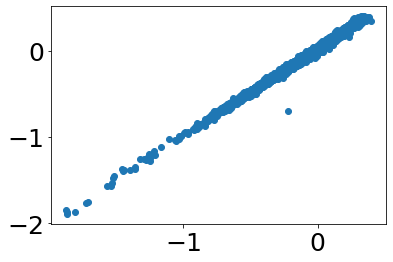

In [7]:
from astropy.io import ascii

kasc672 = fits.getdata('/Users/joshuapovick/Desktop/Research/APOKASC/APOKASC_cat_v6.7.2.fits.gz')
kasc3 = ascii.read('MLtesterr3bDR16A3PalphaM_july5.out')
dr17 = fits.getdata('/Users/joshuapovick/Desktop/Research/fits/allStarLite-dr17-synspec.fits.gz')

# xmatch APOKASC Catalogs
_, k672idx, k3idx = np.intersect1d(kasc672['2MASS_ID'],kasc3['2MASSID'],return_indices=True)
k672 = kasc672[k672idx]
k3 = kasc3[k3idx]

# xmatch APOKASC with DR17
_, k3idx, dr17idx = np.intersect1d(k3['2MASSID'],dr17['APOGEE_ID'],return_indices=True)

k672dr17 = k672[k3idx]
k3dr17 = k3[k3idx]
kdr17 = dr17[dr17idx]

# Select RGB stars
ageevs = np.where((k3dr17['IntAge']>-10.)&(k672dr17['APOKASC3_CONS_EVSTATES']==1.0)&
                  (kdr17['GAIAEDR3_PARALLAX']/kdr17['GAIAEDR3_PARALLAX_ERROR']>3.0))

k672dr17 = k672dr17[ageevs]
k3dr17 = k3dr17[ageevs]
kdr17 = kdr17[ageevs]

apoafe = kdr17['ALPHA_M']+kdr17['M_H']-kdr17['FE_H']
apoafe_err = np.sqrt(kdr17['ALPHA_M']**2+kdr17['M_H']**2-kdr17['FE_H']**2)

plt.scatter(kdr17['FE_H'],k3dr17['Fe/H'])

In [8]:
# pfilters = np.array(['G_BPmag','G_RPmag','Jmag','Hmag'])
# kfilters = np.array(['GAIAEDR3_PHOT_BP_MEAN_MAG','GAIAEDR3_PHOT_RP_MEAN_MAG','J','H'])
# ylabels = np.array(['BP - K','RP - K','J - K','H - K'])

# teffcut = np.where((massive['logTe']<np.log10(5500.))&(massive['logTe']>np.log10(3000.)))

# for i in range(len(pfilters)):

#     plt.figure(figsize=[10,10])
#     plt.scatter(10**massive['logTe'][teffcut][::50],(massive[pfilters[i]]-massive['Ksmag'])[teffcut][::50])
#     plt.scatter(kdr17['TEFF'],kdr17[kfilters[i]]-kdr17['K'],s=10)
#     plt.xlabel('Teff')
#     plt.ylabel(r'{}'.format(ylabels[i]))
#     plt.savefig('../plots/colorteff_{}APOKASC.pdf'.format(kfilters[i]),bbox_inches='tight')
#     plt.show()

In [9]:
# ### Resd in APOKASC Catalogs
# from astropy.io import ascii
# kasc672 = fits.getdata('/Users/joshuapovick/Desktop/Research/APOKASC/APOKASC_cat_v6.7.2.fits.gz')
# kasc3 = ascii.read('MLtesterr3bDR16A3PalphaM_july5.out')

# ### xmatch the APOKASC Catlaogs
# _, k3_idx, k672_idx = np.intersect1d(kasc3['2MASSID'],kasc672['2MASS_ID'],return_indices=True)

# kasc672 = kasc672[k672_idx]
# kasc3 = kasc3[k3_idx]

# ### Check
# print(np.where((kasc3['2MASSID']==kasc672['2MASS_ID'])==False))

# ### Read in DR17
# dr17 = fits.getdata('/Users/joshuapovick/Desktop/Research/fits/allStarLite-dr17-synspec.fits.gz')

# ### xmatch APOKASC and APOGEE
# _, kasc_idx, apo_idx = np.intersect1d(kasc3['2MASSID'],dr17['APOGEE_ID'],return_indices=True)

# kasc672 = kasc672[kasc_idx]
# kasc3 = kasc3[kasc_idx]
# kasc3dr17 = dr17[apo_idx] 

# ### Select RGB stars
# ageevs = np.where((kasc3['IntAge']>-10.)&(kasc672['APOKASC3_CONS_EVSTATES']==1.0)&
#                   (kasc3dr17['GAIAEDR3_PARALLAX']/kasc3dr17['GAIAEDR3_PARALLAX_ERROR']>3.0))

# kasc672 = kasc672[ageevs]
# kasc3 = kasc3[ageevs]
# kasc3dr17 = dr17[ageevs] 

In [10]:
# dr16 = fits.getdata('/Users/joshuapovick/Desktop/Research/fits/allStarLite-r12-l33.fits.gz')

# #### dr16 last
# _, d16test, d17test = np.intersect1d(dr16['APOGEE_ID'],kasc3dr17['APOGEE_ID'], return_indices=True)

# dr16test = dr16[d16test]
# kasc3dr17test = kasc3dr17[d17test]
# kasc3test = kasc3[d17test]
# ksc672test = kasc672[d17test]

In [11]:
# kasc672 = fits.getdata('/Users/joshuapovick/Desktop/Research/APOKASC/APOKASC_cat_v6.7.2.fits.gz')
# kasc3 = ascii.read('MLtesterr3bDR16A3PalphaM_july5.out')

# ### Check
# print(np.where((kasc3['2MASSID']==kasc672['2MASS_ID'])==False))

# ### dr16
# _, d16idx, d17idx = np.intersect1d(dr16['APOGEE_ID'],dr17['APOGEE_ID'], return_indices=True)

# kasc672 = kasc672[d17idx]
# kasc3 = kasc3[d17idx]
# dr17a = dr17[d17idx]
# dr16a = dr16[d16idx]

In [12]:
# _, d16_idx, d17_idx = np.intersect1d(dr16['APOGEE_ID'],dr17['APOGEE_ID'], return_indices=True)
# d16 = dr16[d16_idx]
# d17 = dr17[d17_idx]

# _, k_idx, a_idx = np.intersect1d(kasc3['2MASSID'],d17['APOGEE_ID'], return_indices=True)

# d16 = d16[a_idx]
# d17 = d17[a_idx]
# ka3 = kasc3[k_idx]

# Gaia Magnitude Errors

In [13]:
from scipy.stats import binned_statistic
gaiaedr3 = fits.getdata('/Users/joshuapovick/Desktop/Research/gaia/GAIAEDR3allStar.fits.gz')

In [14]:
binnum = 75

### BP
bp_fin = np.where(np.isfinite(gaiaedr3['phot_bp_mean_mag'])==True)

bpmin = min(gaiaedr3['phot_bp_mean_mag'][bp_fin])
bpmax = max(gaiaedr3['phot_bp_mean_mag'][bp_fin])

bpdiff = bpmax-bpmin
bpfluxerr = (2.5*0.434)/gaiaedr3['phot_bp_mean_flux_over_error'][bp_fin]
bpmagerr = np.sqrt((bpfluxerr)**2+0.0027901700**2)

bpbin ,_,_ = binned_statistic(gaiaedr3['phot_bp_mean_mag'][bp_fin],np.log10(bpmagerr),'median',bins=binnum)

### RP 
rp_fin = np.where(np.isfinite(gaiaedr3['phot_rp_mean_mag'])==True)

rpmin = min(gaiaedr3['phot_rp_mean_mag'][rp_fin])
rpmax = max(gaiaedr3['phot_rp_mean_mag'][rp_fin])

rpdiff = rpmax-rpmin
rpfluxerr = (2.5*0.434)/gaiaedr3['phot_rp_mean_flux_over_error'][rp_fin]
rpmagerr = np.sqrt((rpfluxerr)**2+0.0037793818**2)

rpbin ,_,_ = binned_statistic(gaiaedr3['phot_rp_mean_mag'][rp_fin],np.log10(rpmagerr),'median',bins=binnum)

bperrfunc = IUS(np.arange(bpmin,bpmax,bpdiff/binnum),bpbin)
rperrfunc = IUS(np.arange(rpmin,rpmax,rpdiff/binnum),rpbin)

bperr = 10**bperrfunc(kdr17['GAIAEDR3_PHOT_BP_MEAN_MAG'])
rperr = 10**rperrfunc(kdr17['GAIAEDR3_PHOT_RP_MEAN_MAG'])

# [Fe/H]

In [15]:
finfeh = np.where((np.isfinite(kdr17['FE_H'])==True)&(np.isfinite(k3dr17['Fe/H'])==True))

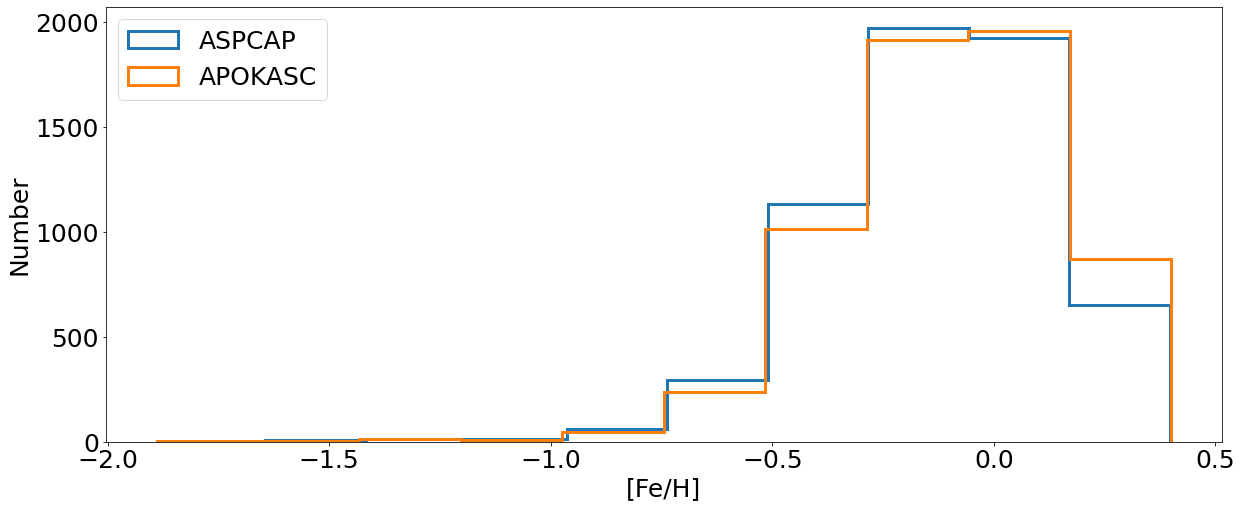

In [16]:
plt.figure(figsize=[20,8])
plt.hist(kdr17['FE_H'],histtype='step',lw=3.0,label='ASPCAP')
plt.hist(k3dr17['Fe/H'],histtype='step',lw=3.0,label='APOKASC')
plt.legend(loc='upper left')
plt.xlabel(r'[Fe/H]')
plt.ylabel(r'Number')
# plt.savefig('../plots/kasc_aspcap_feh_hist.pdf',dpi=300,bbox_inches='tight')
plt.show()

In [17]:
k3dr17.columns

<TableColumns names=('KICID','Mass','Logg','Fe/H','Al/Fe','Teff','C/N','M_err','Logg_err','Fe/H_err','Al/Fe_err','Teff_err','2MASSID','IntTeff','IntML','IntAge','IntC12','IntC13','IntN14','IntXsurf')>

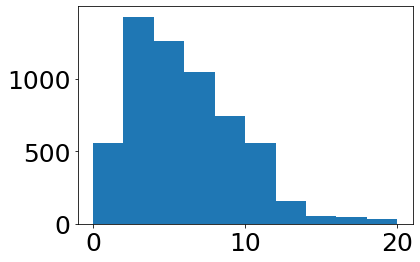

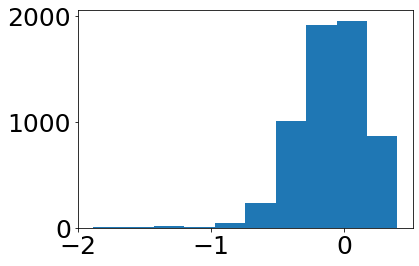

(-3.8320285, 20.0)

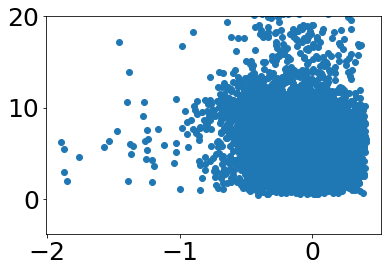

In [18]:
plt.hist(k3dr17['IntAge'],range=(0,20))
plt.show()

plt.hist(k3dr17['Fe/H'])
plt.show()

plt.scatter(k3dr17['Fe/H'],k3dr17['IntAge'])
plt.ylim(top=20)

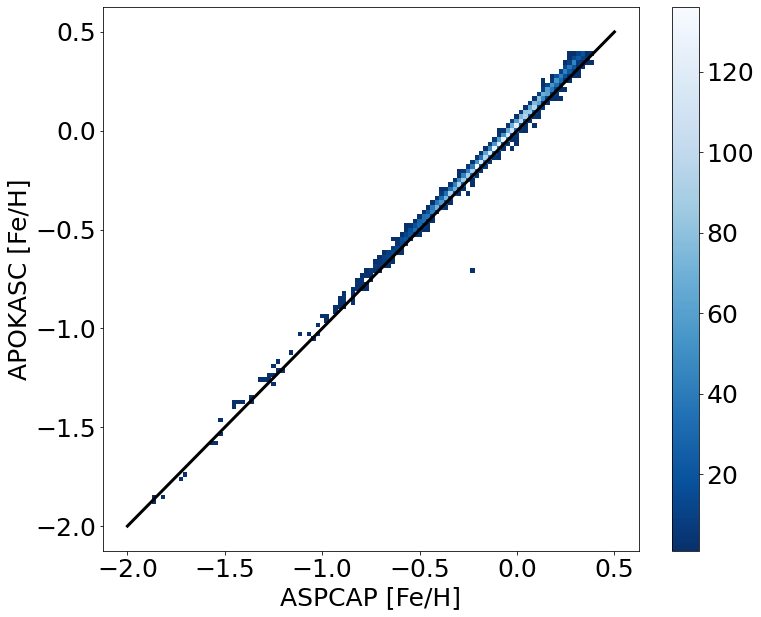

In [19]:
ret = binned_statistic_2d(kdr17['FE_H'][finfeh],k3dr17['Fe/H'][finfeh],
                          kdr17['FE_H'][finfeh],'count',bins=100)

ret.statistic[ret.statistic == 0.0] = np.nan

### Plot
plt.figure(figsize=[12,10])

plt.imshow(ret.statistic.T, origin='lower',extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
       aspect='auto',interpolation='nearest',cmap='Blues_r')

plt.colorbar()

# plt.figure(figsize=[10,10])
plt.plot([-2,0.5],[-2,0.5],c='k',lw=3.0)

plt.xlabel(r'ASPCAP [Fe/H]')
plt.ylabel(r'APOKASC [Fe/H]')

plt.savefig('../plots/kasc_aspcap_feh_density.pdf',dpi=300,bbox_inches='tight')
plt.show()

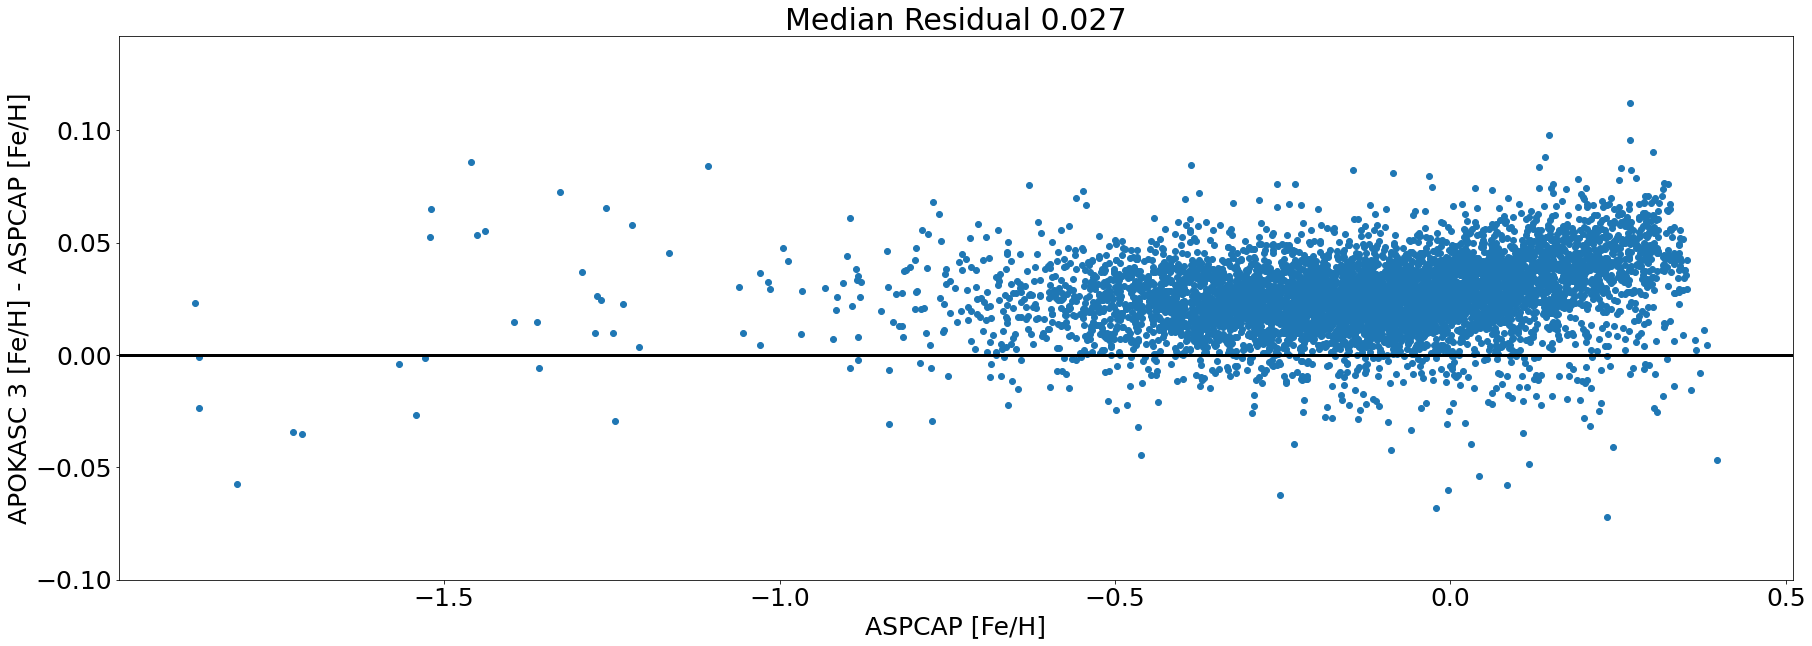

In [20]:
plt.figure(figsize=[30,10])
plt.scatter(kdr17['FE_H'][finfeh],k3dr17['Fe/H'][finfeh]-kdr17['FE_H'][finfeh])

plt.axhline(0.0,c='k',lw=3.0)

plt.title(r'Median Residual {:.3f}'.format(np.median(k3dr17['Fe/H'][finfeh]-kdr17['FE_H'][finfeh])))
plt.xlabel(r'ASPCAP [Fe/H]')
plt.ylabel(r'APOKASC 3 [Fe/H] - ASPCAP [Fe/H]')
plt.ylim(bottom=-0.1)
plt.savefig('../plots/kasc_aspcap_feh_resid_density.pdf',dpi=300,bbox_inches='tight')

[0.01872331 0.02949475]


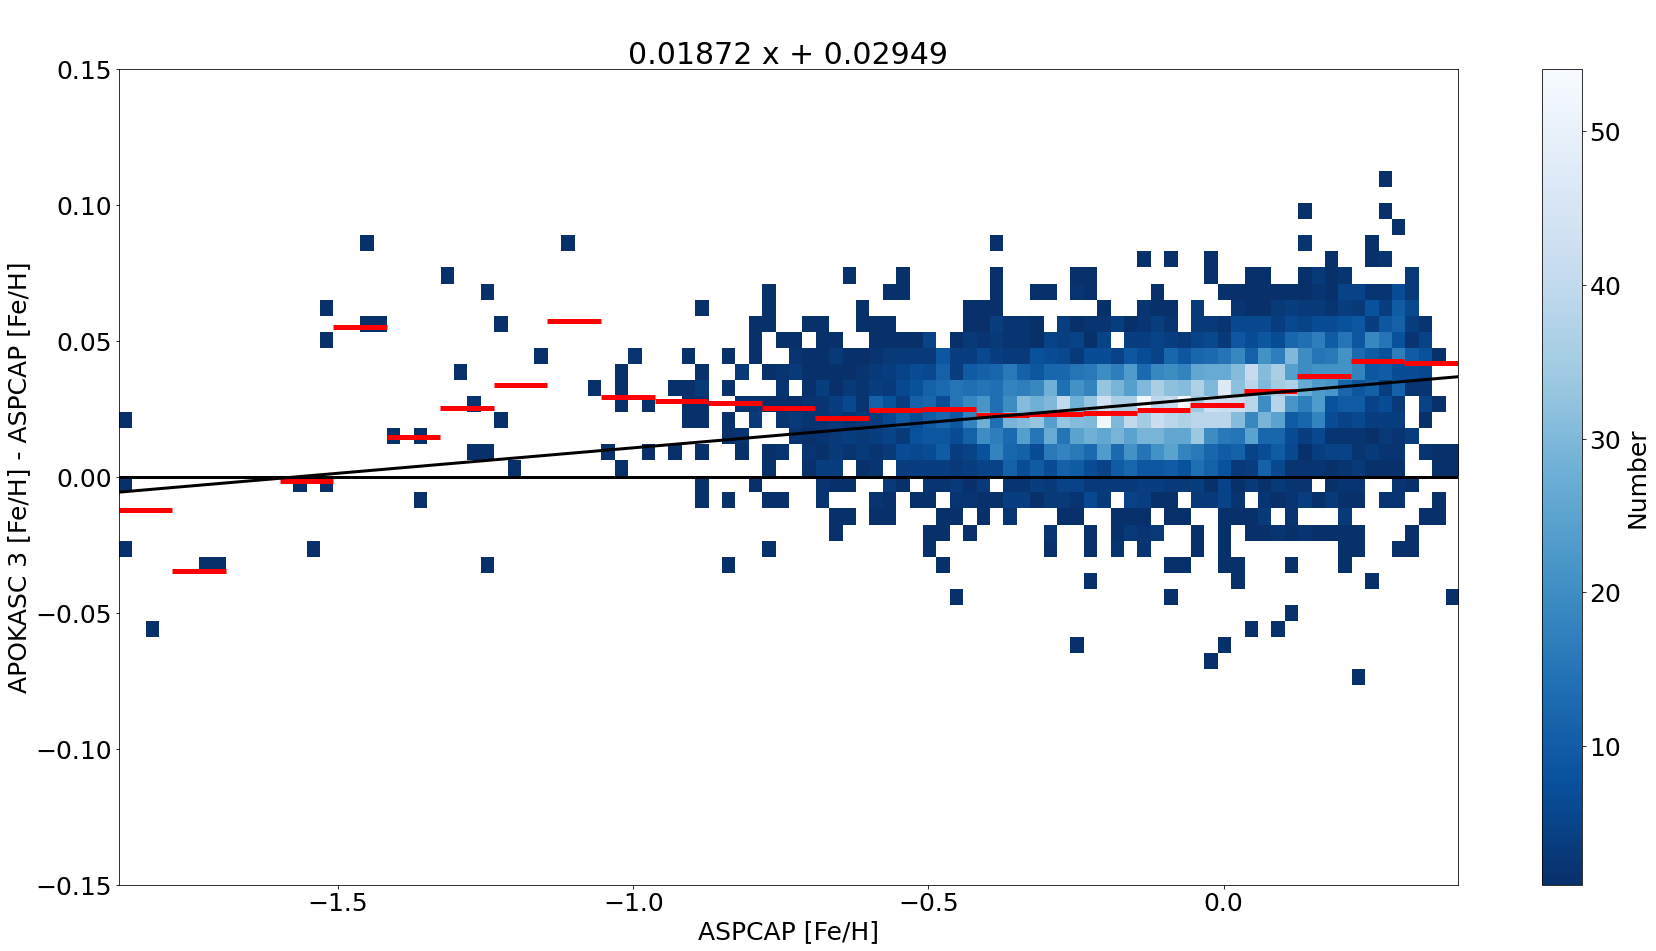

In [21]:
coeff = robust.polyfit(kdr17['FE_H'][finfeh],(k3dr17['Fe/H']-kdr17['FE_H'])[finfeh],1)
print(coeff)

page = np.poly1d(coeff)

### residuals

bin_means, bin_edges, _ = binned_statistic(kdr17['FE_H'][finfeh],(k3dr17['Fe/H']-kdr17['FE_H'])[finfeh],
                                           statistic='median',bins=25)
### number

ret = binned_statistic_2d(kdr17['FE_H'][finfeh],(k3dr17['Fe/H']-kdr17['FE_H'])[finfeh],
                          kdr17['FE_H'][finfeh],'count',bins=100)

ret.statistic[ret.statistic == 0.0] = np.nan

### Plot
plt.figure(figsize=[30,15])

plt.imshow(ret.statistic.T, origin='lower',extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
       aspect='auto',interpolation='nearest',cmap='Blues_r')
cbar = plt.colorbar()
cbar.set_label('Number')

plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='r', lw=5.)
plt.axhline(0.,c='k',lw=3.0)

plt.ylim(-0.15,0.15)

polyxs = np.linspace(min(kdr17['FE_H'][finfeh]),max(kdr17['FE_H'][finfeh]))

plt.plot(polyxs,page(polyxs),c='k',lw=3.0)

plt.title(r'{}'.format(page))
plt.xlabel(r'ASPCAP [Fe/H]')
plt.ylabel(r'APOKASC 3 [Fe/H] - ASPCAP [Fe/H]')

plt.savefig('../plots/kasc_feh_resid_2dhist.pdf',dpi=300,bbox_inches='tight')
plt.show()

# Isochrone Plots

It might be interesting to try something similar to what they did in the Alist paper.
Take a narrow range in metallicity and APOKASC3 age, then plot those stars in
logg vs. Teff (using APOKASC logg) and overplot the isochrone to compare.
You can then do this for a variety of metallicities and ages.

(-0.1, 0.14194499574422836)

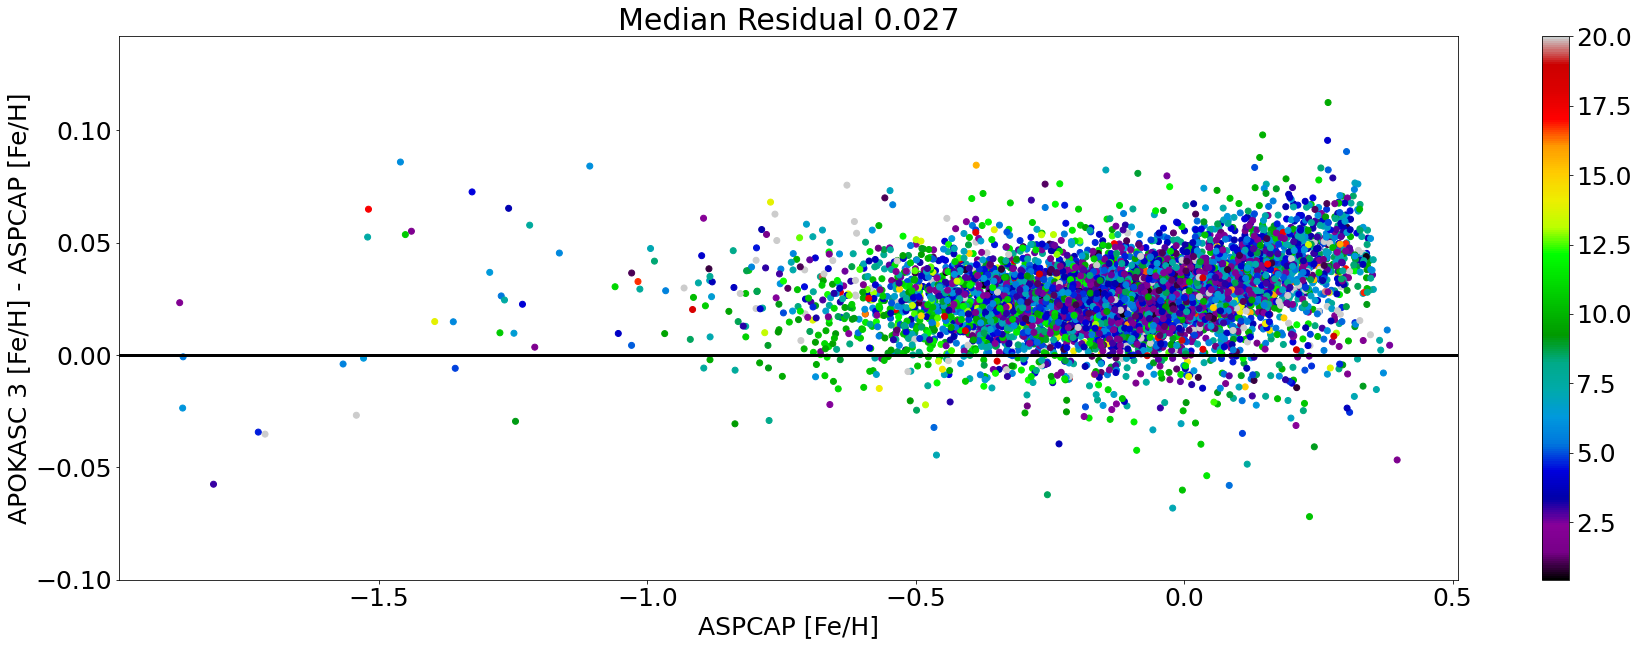

In [22]:
plt.figure(figsize=[30,10])
plt.scatter(kdr17['FE_H'][finfeh],k3dr17['Fe/H'][finfeh]-kdr17['FE_H'][finfeh],
            c=k3dr17['IntAge'][finfeh],cmap='nipy_spectral',vmax=20)
plt.colorbar()

plt.axhline(0.0,c='k',lw=3.0)

plt.title(r'Median Residual {:.3f}'.format(np.median(k3dr17['Fe/H'][finfeh]-kdr17['FE_H'][finfeh])))
plt.xlabel(r'ASPCAP [Fe/H]')
plt.ylabel(r'APOKASC 3 [Fe/H] - ASPCAP [Fe/H]')
plt.ylim(bottom=-0.1)

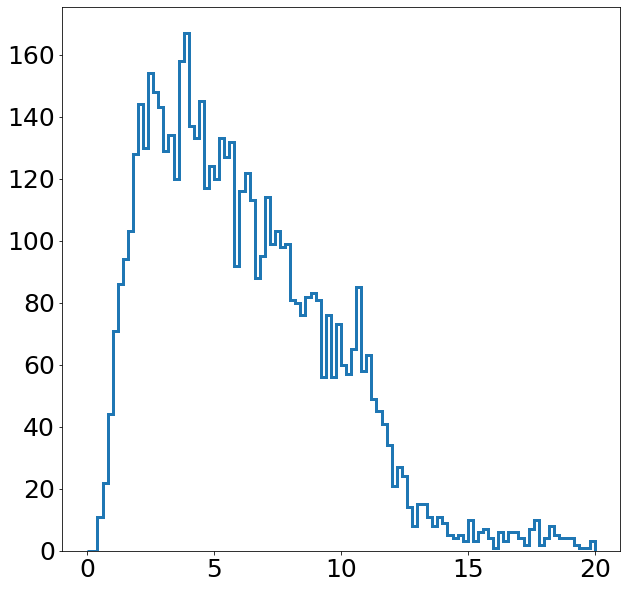

In [23]:
min(k3dr17['IntAge'])
plt.figure(figsize=[10,10])
plt.hist(k3dr17['IntAge'],range=(0,20),bins=100,histtype='step',lw=3.0)
plt.show()

In [24]:
# ### Age: 10 Gyr; [Fe/H]: -0.5
# f_05a10 = np.where((k3dr17['IntAge']>=9.75)&(k3dr17['IntAge']<=10.25)&
#                   (k3dr17['Fe/H']<=-0.45)&(k3dr17['Fe/H']>=-0.55))

# iso_f_05a10 = massive[np.where((massive['MH']==closest(massive['MH'],-0.5))&
#                               (massive['logAge']==closest(massive['logAge'],np.log10(10*10**9))))]

# iso_f_05a10 = iso_f_05a10[np.argsort(iso_f_05a10['logTe'])]

# plt.figure(figsize=[10,10])
# plt.scatter(k3dr17['Teff'][f_05a8],k3dr17['Logg'][f_05a8])

# plt.plot(10**iso_f_05a10['logTe'],iso_f_05a10['logg'])

# plt.gca().invert_xaxis()
# plt.gca().invert_yaxis()

# plt.title(r'Age: 10 Gyr; [Fe/H]: -0.5')
# plt.xlabel(r'Teff')
# plt.ylabel(r'Log(g)')
# plt.show()


# ### Age: 5 Gyr; [Fe/H]: 0.0
# f00a5 = np.where((k3dr17['IntAge']>=4.75)&(k3dr17['IntAge']<=5.25)&
#                   (k3dr17['Fe/H']<=0.05)&(k3dr17['Fe/H']>=-0.05))

# iso_f00a5 = massive[np.where((massive['MH']==closest(massive['MH'],0.0))&
#                               (massive['logAge']==closest(massive['logAge'],np.log10(5*10**9))))]

# iso_f00a5 = iso_f00a5[np.argsort(iso_f00a5['logTe'])]

# plt.figure(figsize=[10,10])
# plt.scatter(k3dr17['Teff'][f00a5],k3dr17['Logg'][f00a5])

# plt.plot(10**iso_f00a5['logTe'],iso_f00a5['logg'])

# plt.gca().invert_xaxis()
# plt.gca().invert_yaxis()

# plt.title(r'Age: 5 Gyr; [Fe/H]: 0.0')
# plt.xlabel(r'Teff')
# plt.ylabel(r'Log(g)')
# plt.show()


# ### Age: 3.5 Gyr; [Fe/H]: -0.25
# f_025a35 = np.where((k3dr17['IntAge']>=3.25)&(k3dr17['IntAge']<=3.75)&
#                   (k3dr17['Fe/H']<=-0.20)&(k3dr17['Fe/H']>=-0.30))

# iso_f_025a35 = massive[np.where((massive['MH']==closest(massive['MH'],-0.25))&
#                               (massive['logAge']==closest(massive['logAge'],np.log10(3.5*10**9))))]

# iso_f_025a35 = iso_f_025a35[np.argsort(iso_f_025a35['logTe'])]

# plt.figure(figsize=[10,10])
# plt.scatter(k3dr17['Teff'][f_025a35],k3dr17['Logg'][f_025a35])

# plt.plot(10**iso_f_025a35['logTe'],iso_f_025a35['logg'])

# plt.gca().invert_xaxis()
# plt.gca().invert_yaxis()

# plt.title(r'Age: 3.5 Gyr; [Fe/H]: -0.25')
# plt.xlabel(r'Teff')
# plt.ylabel(r'Log(g)')
# plt.show()

In [25]:
from scipy.interpolate import InterpolatedUnivariateSpline as IUS

In [26]:
# fehs = np.array([0.25,0.0,-0.25,-0.5])
# ages = np.array([10,8.125,6.25,4.375,2.5])

# mse_arr = np.zeros((4,5))

# fig, ax = plt.subplots(4,5,figsize=[60,50])
# for i in range(4):
#     for j in range(5):
#         stars = k3dr17[np.where((k3dr17['IntAge']>=ages[j]-0.25)&(k3dr17['IntAge']<=ages[j]+0.25)&
#                                 (k3dr17['Fe/H']<=fehs[i]+0.25)&(k3dr17['Fe/H']>=fehs[i]-0.25))]
        
#         stars = stars[np.argsort(stars['Teff'])]
        
#         stars_iso = massive[np.where((massive['MH']==closest(massive['MH'],fehs[i]))&
#                                      (massive['logAge']==closest(massive['logAge'],np.log10(ages[j]*10**9))))]
        
#         stars_iso = stars_iso[np.argsort(stars_iso['logTe'])]
        
#         line = (np.poly1d(robust.polyfit(stars['Teff'],stars['Logg'],1)))
#         line_xs = np.linspace(min(10**stars_iso['logTe']),max(10**stars_iso['logTe']))
        
        
#         teffrange = np.where((stars_iso['logTe']>=closest(stars_iso['logTe'],np.log10(min(stars['Teff']))))&
#                              (stars_iso['logTe']<=closest(stars_iso['logTe'],np.log10(max(stars['Teff'])))))
        
#         mse = (np.sum(np.square((stars_iso['logg']-line(10**stars_iso['logTe']))[teffrange]))/
#                len(np.squeeze(teffrange)))
#         mse_arr[i,j] = mse
        
#         ax[i,j].scatter(stars['Teff'],stars['Logg'],c='tab:orange',label='APOKASC')
#         ax[i,j].plot(10**stars_iso['logTe'],stars_iso['logg'],c='tab:blue',label='Isochrone')
        
#         ax[i,j].plot(line_xs,line(line_xs),c='tab:green',label='Best Fit')
        
#         ax[i,j].legend()
        
#         ax[i,j].invert_xaxis()
#         ax[i,j].invert_yaxis()
        
#         ax[i,j].set_title(r'Age: {}; [Fe/H]: {}; MSE: {:.5f}'.format(ages[j],fehs[i],mse))
        
#         ax[i,j].set_xlabel(r'Teff')
#         ax[i,j].set_ylabel(r'Log(g)')
        
# # plt.suptitle(r'Without Salaris Correction')
# plt.savefig('../plots/isochrone_compare.pdf',dpi=300,bbox_inches='tight')
# plt.show()

In [37]:
# fehs = np.array([0.25,0.0,-0.25,-0.5])
# ages = np.array([10,8.125,6.25,4.375,2.5])

# # mse_arr = np.ones((4,5))

# fig, ax = plt.subplots(4,5,figsize=[60,50])
# for i in range(4):
#     for j in range(5):
        
#         stars_select = np.where((k3dr17['IntAge']>=ages[j]-0.25)&(k3dr17['IntAge']<=ages[j]+0.25)&
#                                 (k3dr17['Fe/H']<=fehs[i]+0.05)&(k3dr17['Fe/H']>=fehs[i]-0.05))
        
#         starslogg = k3dr17['Logg'][stars_select]
#         starsteff = kdr17['TEFF'][stars_select]
        
#         salcorr = 0 #np.median(np.log10(0.655*(10**(apoafe[stars_select]))+0.345))
        
#         teffsort=np.argsort(starsteff)
        
#         stars_iso = massive[np.where((massive['MH']==closest(massive['MH'],fehs[i]+salcorr))&
#                                      (massive['logAge']==closest(massive['logAge'],np.log10(ages[j]*10**9))))]
        
#         stars_iso = stars_iso[np.argsort(stars_iso['logTe'])]
        
#         spl = IUS(10**stars_iso['logTe'][::2],stars_iso['logg'][::2])
#         spl_xs = np.linspace(min(10**stars_iso['logTe']),max(10**stars_iso['logTe']))
        
# #         mse = np.sum(np.square(starslogg-spl(kdr17[stars_select]['TEFF'])))/len(stars)
# #         mse_arr[i,j] = mse
        
#         ax[i,j].scatter(starsteff,starslogg,c='tab:orange',label='APOKASC')
        
#         ax[i,j].plot(spl_xs,spl(spl_xs),c='tab:blue',label='Isochrone')
        
#         ax[i,j].legend()
        
#         ax[i,j].invert_xaxis()
#         ax[i,j].invert_yaxis()
        
#         ax[i,j].set_title(r'Age: {}; [Fe/H]: {}'.format(ages[j],fehs[i]))#,mse))
        
#         ax[i,j].set_xlabel(r'Teff')
#         ax[i,j].set_ylabel(r'Log(g)')
        
# plt.suptitle(r'Without Salaris Correction',y=0.91)
# plt.savefig('../plots/isochrone_compareTEFF.pdf',dpi=300,bbox_inches='tight')
# plt.show()

In [38]:
# fehs = np.array([0.25,0.0,-0.25,-0.5])
# ages = np.array([10,8.125,6.25,4.375,2.5])

# fig, ax = plt.subplots(4,5,figsize=[60,50])
# for i in range(4):
#     for j in range(5):
        
#         stars_select = np.where((k3dr17['IntAge']>=ages[j]-0.25)&(k3dr17['IntAge']<=ages[j]+0.25)&
#                                 (k3dr17['Fe/H']<=fehs[i]+0.05)&(k3dr17['Fe/H']>=fehs[i]-0.05))
        
#         starslogg = k3dr17['Logg'][stars_select]
#         starsteff = kdr17['TEFF'][stars_select]
        
#         salcorr = np.median(np.log10(0.655*(10**(apoafe[stars_select]))+0.345))
        
#         stars = stars[np.argsort(stars['Teff'])]
        
#         stars_iso = massive[np.where((massive['MH']==closest(massive['MH'],fehs[i]+salcorr))&
#                                      (massive['logAge']==closest(massive['logAge'],np.log10(ages[j]*10**9))))]
        
#         stars_iso = stars_iso[np.argsort(stars_iso['logTe'])]
        
#         spl = IUS(10**stars_iso['logTe'][::2],stars_iso['logg'][::2])
#         spl_xs = np.linspace(min(10**stars_iso['logTe']),max(10**stars_iso['logTe']))
        
#         mse = np.sum(np.square(stars['Logg']-spl(stars['Teff'])))/len(stars)
#         mse_arr[i,j] = mse
        
#         ax[i,j].scatter(starsteff,starslogg,c='tab:orange',label='APOKASC')
        
#         ax[i,j].plot(spl_xs,spl(spl_xs),c='tab:blue',label='Isochrone')
        
#         ax[i,j].legend()
        
#         ax[i,j].invert_xaxis()
#         ax[i,j].invert_yaxis()
        
#         ax[i,j].set_title(r'Age: {}; [Fe/H]: {}'.format(ages[j],fehs[i]))#,mse))
        
#         ax[i,j].set_xlabel(r'Teff')
#         ax[i,j].set_ylabel(r'Log(g)')
        
# plt.suptitle(r'With Salaris Correction',y=0.91)
# plt.savefig('../plots/isochrone_compare_salarisTEFF.pdf',dpi=300,bbox_inches='tight')
# plt.show()

In [128]:
# fehs = np.array([0.25,0.0,-0.25,-0.5])
# ages = np.array([10,8.125,6.25,4.375,2.5])

# dlogg_arr = np.zeros((4,5))

# fig, ax = plt.subplots(4,5,figsize=[60,50])
# for i in range(4):
#     for j in range(5):
        
#         stars_select = np.where((k3dr17['IntAge']>=ages[j]-0.25)&(k3dr17['IntAge']<=ages[j]+0.25)&
#                                 (k3dr17['Fe/H']<=fehs[i]+0.05)&(k3dr17['Fe/H']>=fehs[i]-0.05))
        
#         starslogg = k3dr17['Logg'][stars_select]
#         starsteff = kdr17['TEFF'][stars_select]
        
#         starslogg = starslogg[np.argsort(starsteff)]
#         starsteff = starsteff[np.argsort(starsteff)]
        
#         salcorr = 0 #np.median(np.log10(0.655*(10**(apoafe[stars_select]))+0.345))
        
#         stars_iso = massive[np.where((massive['MH']==closest(massive['MH'],fehs[i]+salcorr))&
#                                      (massive['logAge']==closest(massive['logAge'],np.log10(ages[j]*10**9))))]
#         stars_iso = stars_iso[np.argsort(stars_iso['logTe'])]
        
#         spl = IUS(10**stars_iso['logTe'][::2],stars_iso['logg'][::2])
#         spl_xs = np.linspace(min(10**stars_iso['logTe']),max(10**stars_iso['logTe']))
        
#         dlogs = starslogg-spl(starsteff)
#         dlogg_arr[i,j] = np.nanmedian(dlogs)
        
#         ax[i,j].scatter(starsteff,starslogg,c='tab:orange')
        
#         for k in range(len(dlogs)):
#             ax[i,j].vlines(x=starsteff[k],ymin=starslogg[k],ymax=starslogg[k]-dlogs[k],color='tab:green',zorder=0)
        
#         ax[i,j].plot(spl_xs,spl(spl_xs),c='tab:blue')
        
#         ax[i,j].invert_xaxis()
#         ax[i,j].invert_yaxis()
        
#         ax[i,j].set_title(r'Age: {}; [Fe/H]: {}; dlogg: {:.3f}'.format(ages[j],fehs[i],np.nanmedian(dlogs)))
        
#         ax[i,j].set_xlabel(r'Teff')
#         ax[i,j].set_ylabel(r'Log(g)')

# plt.suptitle(r'Without Salaris Correction',y=0.91)
# plt.savefig('../plots/isochrone_compare_dloggTEFF.pdf',dpi=300,bbox_inches='tight')
# plt.show()

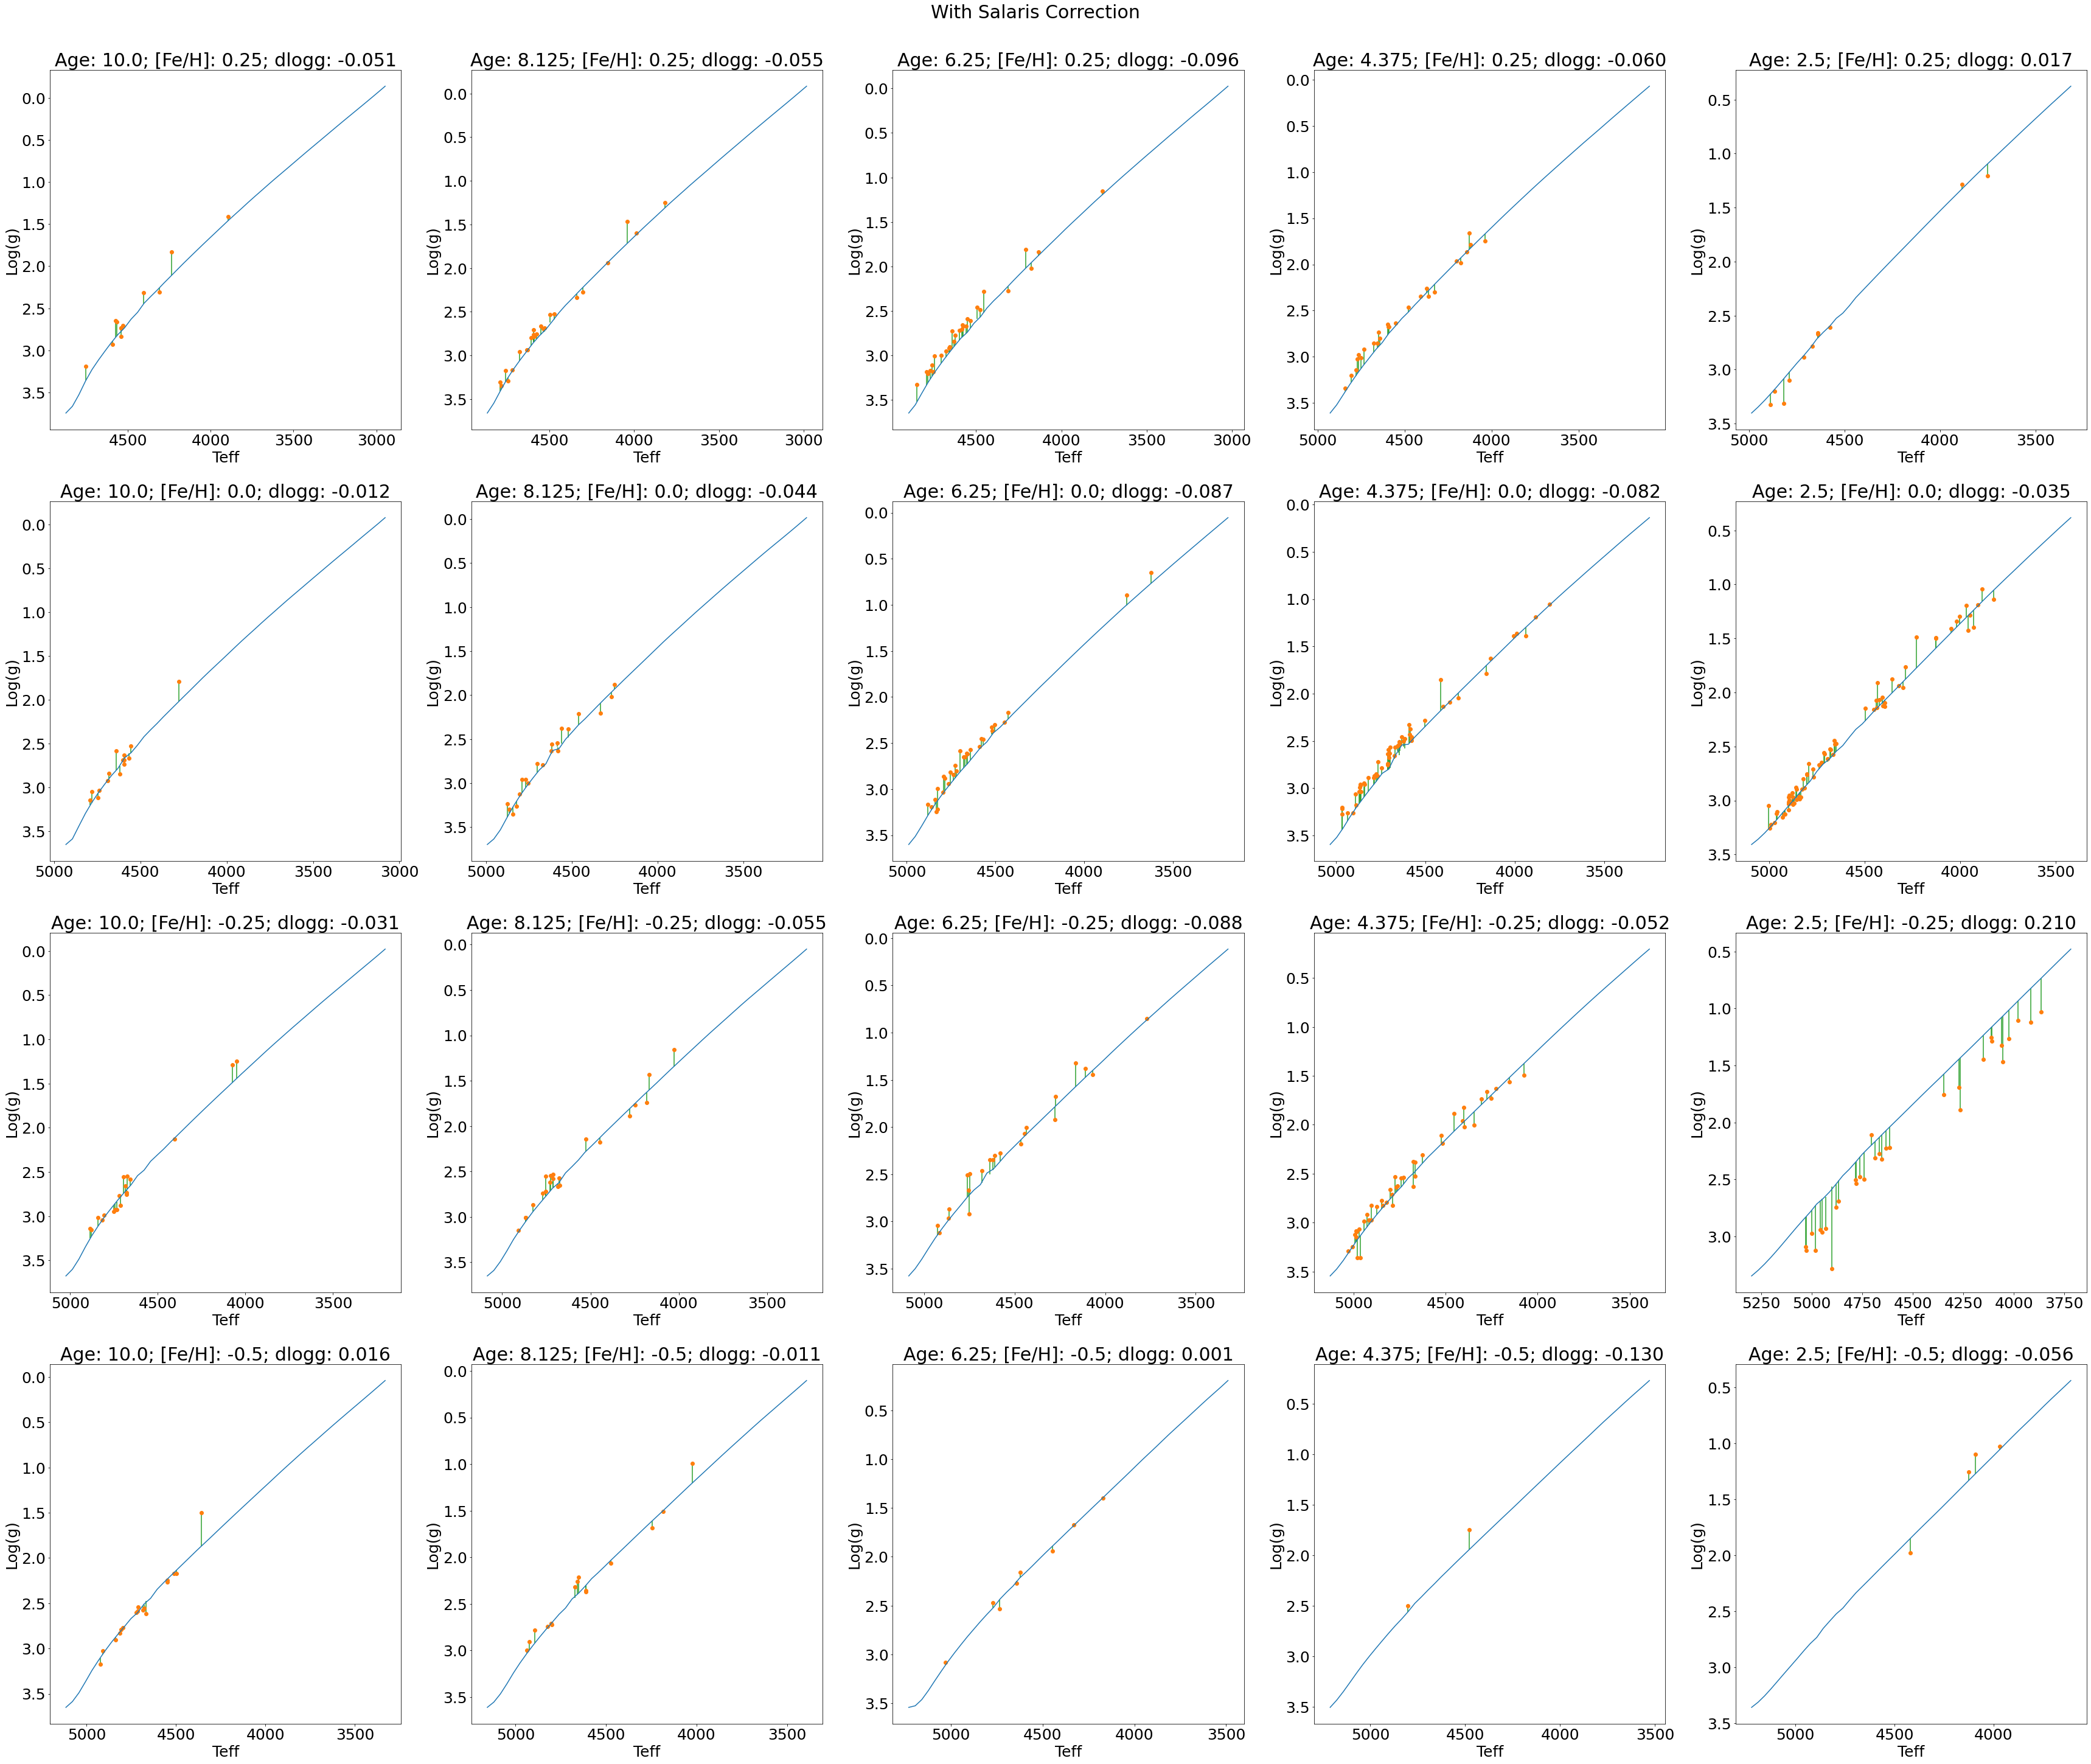

In [55]:
# fehs = np.array([0.25,0.0,-0.25,-0.5])
# ages = np.array([10,8.125,6.25,4.375,2.5])

# dlogg_arr_salaris = np.zeros((4,5))

# fig, ax = plt.subplots(4,5,figsize=[60,50])
# for i in range(4):
#     for j in range(5):
        
#         stars_select = np.where((k3dr17['IntAge']>=ages[j]-0.25)&(k3dr17['IntAge']<=ages[j]+0.25)&
#                                 (k3dr17['Fe/H']<=fehs[i]+0.05)&(k3dr17['Fe/H']>=fehs[i]-0.05))
        
#         starslogg = k3dr17['Logg'][stars_select]
#         starsteff = kdr17['TEFF'][stars_select]
        
#         starslogg = starslogg[np.argsort(starsteff)]
#         starsteff = starsteff[np.argsort(starsteff)]
        
#         salcorr = np.median(np.log10(0.655*(10**(apoafe[stars_select]))+0.345))
        
#         stars_iso = massive[np.where((massive['MH']==closest(massive['MH'],fehs[i]+salcorr))&
#                                      (massive['logAge']==closest(massive['logAge'],np.log10(ages[j]*10**9))))]
#         stars_iso = stars_iso[np.argsort(stars_iso['logTe'])]
        
#         spl = IUS(10**stars_iso['logTe'][::2],stars_iso['logg'][::2])
#         spl_xs = np.linspace(min(10**stars_iso['logTe']),max(10**stars_iso['logTe']))
        
#         dlogs = starslogg-spl(starsteff)
#         dlogg_arr_salaris[i,j] = np.nanmedian(dlogs)
        
#         ax[i,j].scatter(starsteff,starslogg,c='tab:orange')
        
#         for k in range(len(dlogs)):
#             ax[i,j].vlines(x=starsteff[k],ymin=starslogg[k],ymax=starslogg[k]-dlogs[k],color='tab:green',zorder=0)
        
#         ax[i,j].plot(spl_xs,spl(spl_xs),c='tab:blue')
        
#         ax[i,j].invert_xaxis()
#         ax[i,j].invert_yaxis()
        
#         ax[i,j].set_title(r'Age: {}; [Fe/H]: {}; dlogg: {:.3f}'.format(ages[j],fehs[i],np.nanmedian(dlogs)))
        
#         ax[i,j].set_xlabel(r'Teff')
#         ax[i,j].set_ylabel(r'Log(g)')

# plt.suptitle(r'With Salaris Correction',y=0.91)
# plt.savefig('../plots/isochrone_compare_dloggSalarisTEFF.pdf',dpi=300,bbox_inches='tight')
# plt.show()

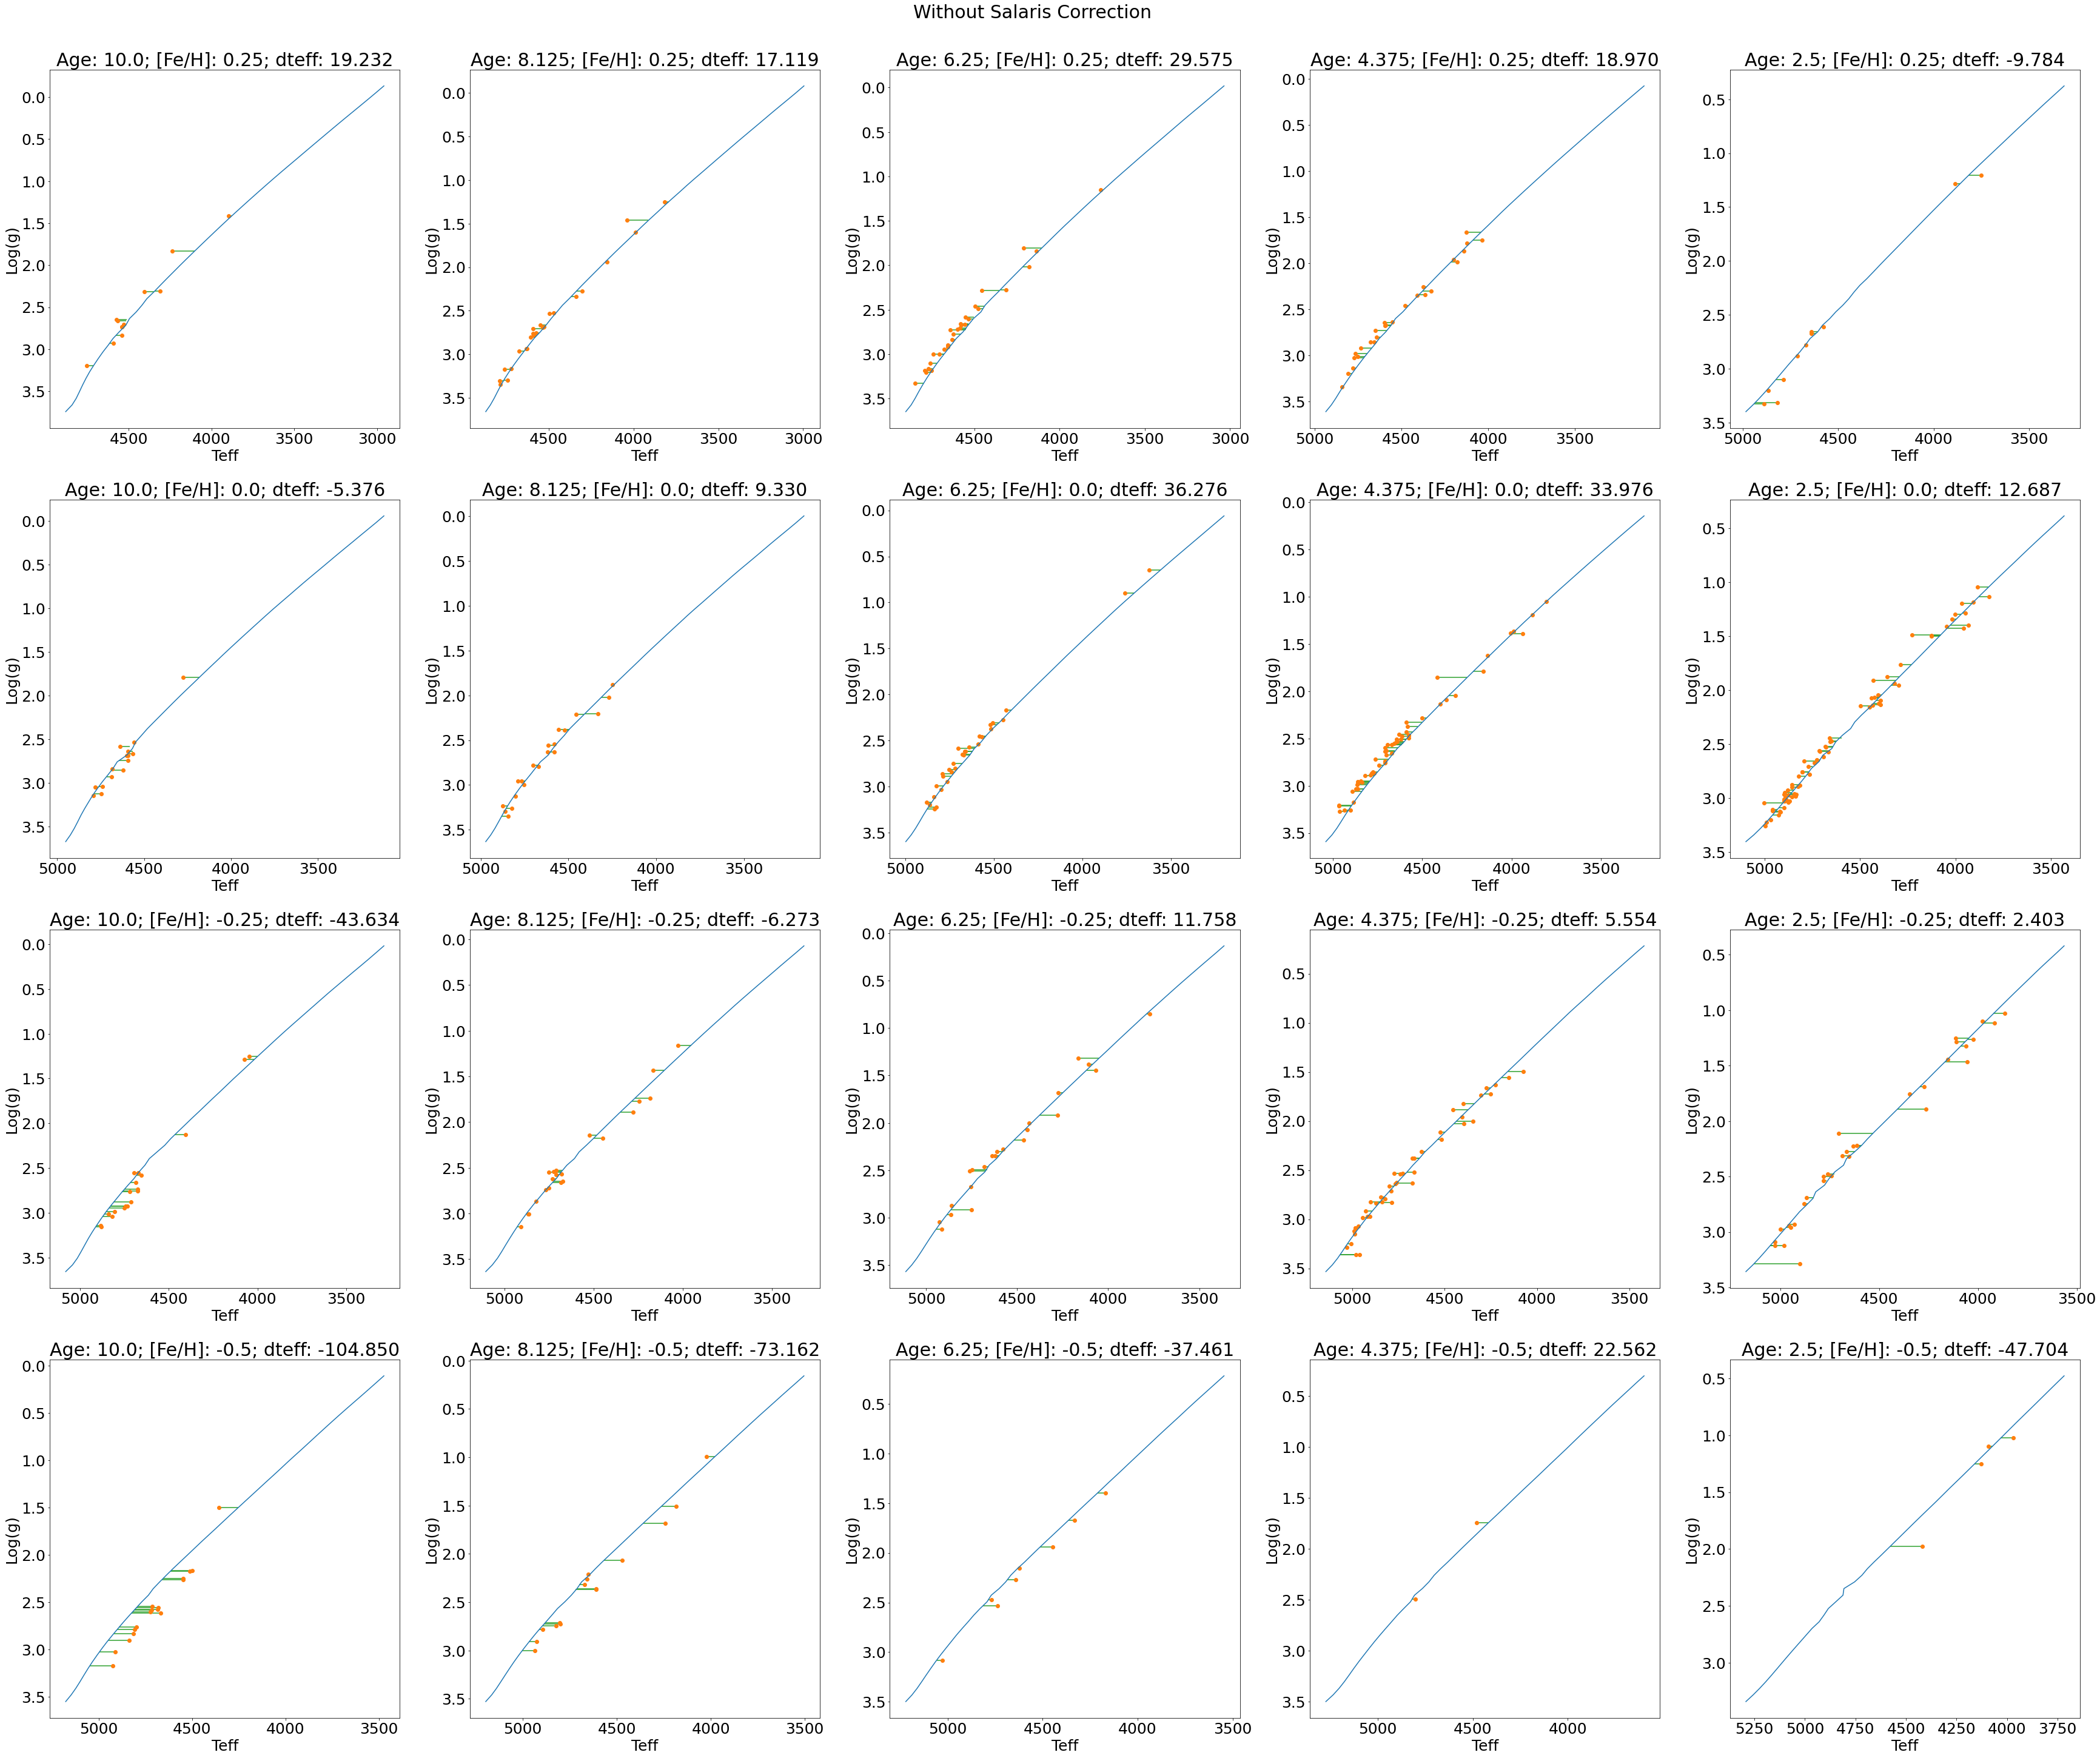

In [74]:
# fehs = np.array([0.25,0.0,-0.25,-0.5])
# ages = np.array([10,8.125,6.25,4.375,2.5])

# # feh_arr = np.zeros((4,5))
# # ages_arr = np.zeros((4,5))

# # alpha_arr = np.zeros((4,5))
# # sal_arr = np.zeros((4,5))

# # dteff_arr_salaris = np.zeros((4,5))

# dteff_arr = np.zeros((4,5))

# fig, ax = plt.subplots(4,5,figsize=[60,50])
# for i in range(4):
#     for j in range(5):
        
#         stars_select = np.where((k3dr17['IntAge']>=ages[j]-0.25)&(k3dr17['IntAge']<=ages[j]+0.25)&
#                                 (k3dr17['Fe/H']<=fehs[i]+0.05)&(k3dr17['Fe/H']>=fehs[i]-0.05))
        
#         starslogg = k3dr17['Logg'][stars_select]
#         starsteff = kdr17['TEFF'][stars_select]
        
#         starslogg = starslogg[np.argsort(starsteff)]
#         starsteff = starsteff[np.argsort(starsteff)]
        
#         salcorr = 0 #np.median(np.log10(0.655*(10**(apoafe[stars_select]))+0.345))
        
#         stars_iso = massive[np.where((massive['MH']==closest(massive['MH'],fehs[i]+salcorr))&
#                                      (massive['logAge']==closest(massive['logAge'],np.log10(ages[j]*10**9))))]
#         stars_iso = stars_iso[np.argsort(stars_iso['logg'])]
        
#         spl = IUS(stars_iso['logg'][::2],10**stars_iso['logTe'][::2])
#         spl_xs = np.linspace(min(stars_iso['logg']),max(stars_iso['logg']))
        
#         dteffs = starsteff-spl(starslogg)
#         dteff_arr[i,j] = np.nanmedian(dteffs)
        
#         ax[i,j].scatter(starsteff,starslogg,c='tab:orange')
        
#         for k in range(len(dteffs)):
#             ax[i,j].hlines(y=starslogg[k],xmin=starsteff[k],xmax=starsteff[k]-dteffs[k],
#                            color='tab:green',zorder=0)
        
#         ax[i,j].plot(spl(spl_xs),spl_xs,c='tab:blue')
        
#         ax[i,j].invert_xaxis()
#         ax[i,j].invert_yaxis()
        
#         ax[i,j].set_title(r'Age: {}; [Fe/H]: {}; dteff: {:.3f}'.format(ages[j],fehs[i],np.nanmedian(dteffs)))
        
#         ax[i,j].set_xlabel(r'Teff')
#         ax[i,j].set_ylabel(r'Log(g)')

# plt.suptitle(r'Without Salaris Correction',y=0.91)
# plt.savefig('../plots/isochrone_compare_dteffTEFF.pdf',dpi=300,bbox_inches='tight')
# plt.show()

In [200]:
# fehs = np.array([0.25,0.0,-0.25,-0.5])
# ages = np.array([10,8.125,6.25,4.375,2.5])

# fehs_arr = np.zeros((4,5))#
# ages_arr = np.zeros((4,5))#

# alpha_arr = np.zeros((4,5))#
# salcorr_arr = np.zeros((4,5))#

# dteff_arr_salaris = np.zeros((4,5))#

# fig, ax = plt.subplots(4,5,figsize=[60,50])
# for i in range(4):
#     for j in range(5):
        
#         fehs_arr[i,j] = fehs[i]
#         ages_arr[i,j] = ages[j]
        
#         stars_select = np.where((k3dr17['IntAge']>=ages[j]-0.25)&(k3dr17['IntAge']<=ages[j]+0.25)&
#                                 (k3dr17['Fe/H']<=fehs[i]+0.05)&(k3dr17['Fe/H']>=fehs[i]-0.05))
        
#         starslogg = k3dr17['Logg'][stars_select]
#         starsteff = kdr17['TEFF'][stars_select]
        
#         starslogg = starslogg[np.argsort(starsteff)]
#         starsteff = starsteff[np.argsort(starsteff)]
        
#         salcorr = np.nanmedian(np.log10(0.655*(10**(apoafe[stars_select]))+0.345))
#         salcorr_arr[i,j] = salcorr
#         alpha_arr[i,j] = np.nanmedian(apoafe[stars_select]) 
        
#         stars_iso = massive[np.where((massive['MH']==closest(massive['MH'],fehs[i]+salcorr))&
#                                      (massive['logAge']==closest(massive['logAge'],np.log10(ages[j]*10**9))))]
#         stars_iso = stars_iso[np.argsort(stars_iso['logg'])]
        
#         spl = IUS(stars_iso['logg'][::2],10**stars_iso['logTe'][::2])
#         spl_xs = np.linspace(min(stars_iso['logg']),max(stars_iso['logg']))
        
#         dteffs = starsteff-spl(starslogg)
#         dteff_arr_salaris[i,j] = np.nanmedian(dteffs)
        
#         ax[i,j].scatter(starsteff,starslogg,c='tab:orange')
        
#         for k in range(len(dteffs)):
#             ax[i,j].hlines(y=starslogg[k],xmin=starsteff[k],xmax=starsteff[k]-dteffs[k],
#                            color='tab:green',zorder=0)
        
#         ax[i,j].plot(spl(spl_xs),spl_xs,c='tab:blue')
        
#         ax[i,j].invert_xaxis()
#         ax[i,j].invert_yaxis()
        
#         ax[i,j].set_title(r'Age: {}; [Fe/H]: {}; dteff: {:.3f}'.format(ages[j],fehs[i],np.nanmedian(dteffs)))
        
#         ax[i,j].set_xlabel(r'Teff')
#         ax[i,j].set_ylabel(r'Log(g)')

# plt.suptitle(r'With Salaris Correction',y=0.91)
# plt.savefig('../plots/isochrone_compare_dteffSalarisTEFF.pdf',dpi=300,bbox_inches='tight')
# plt.show()

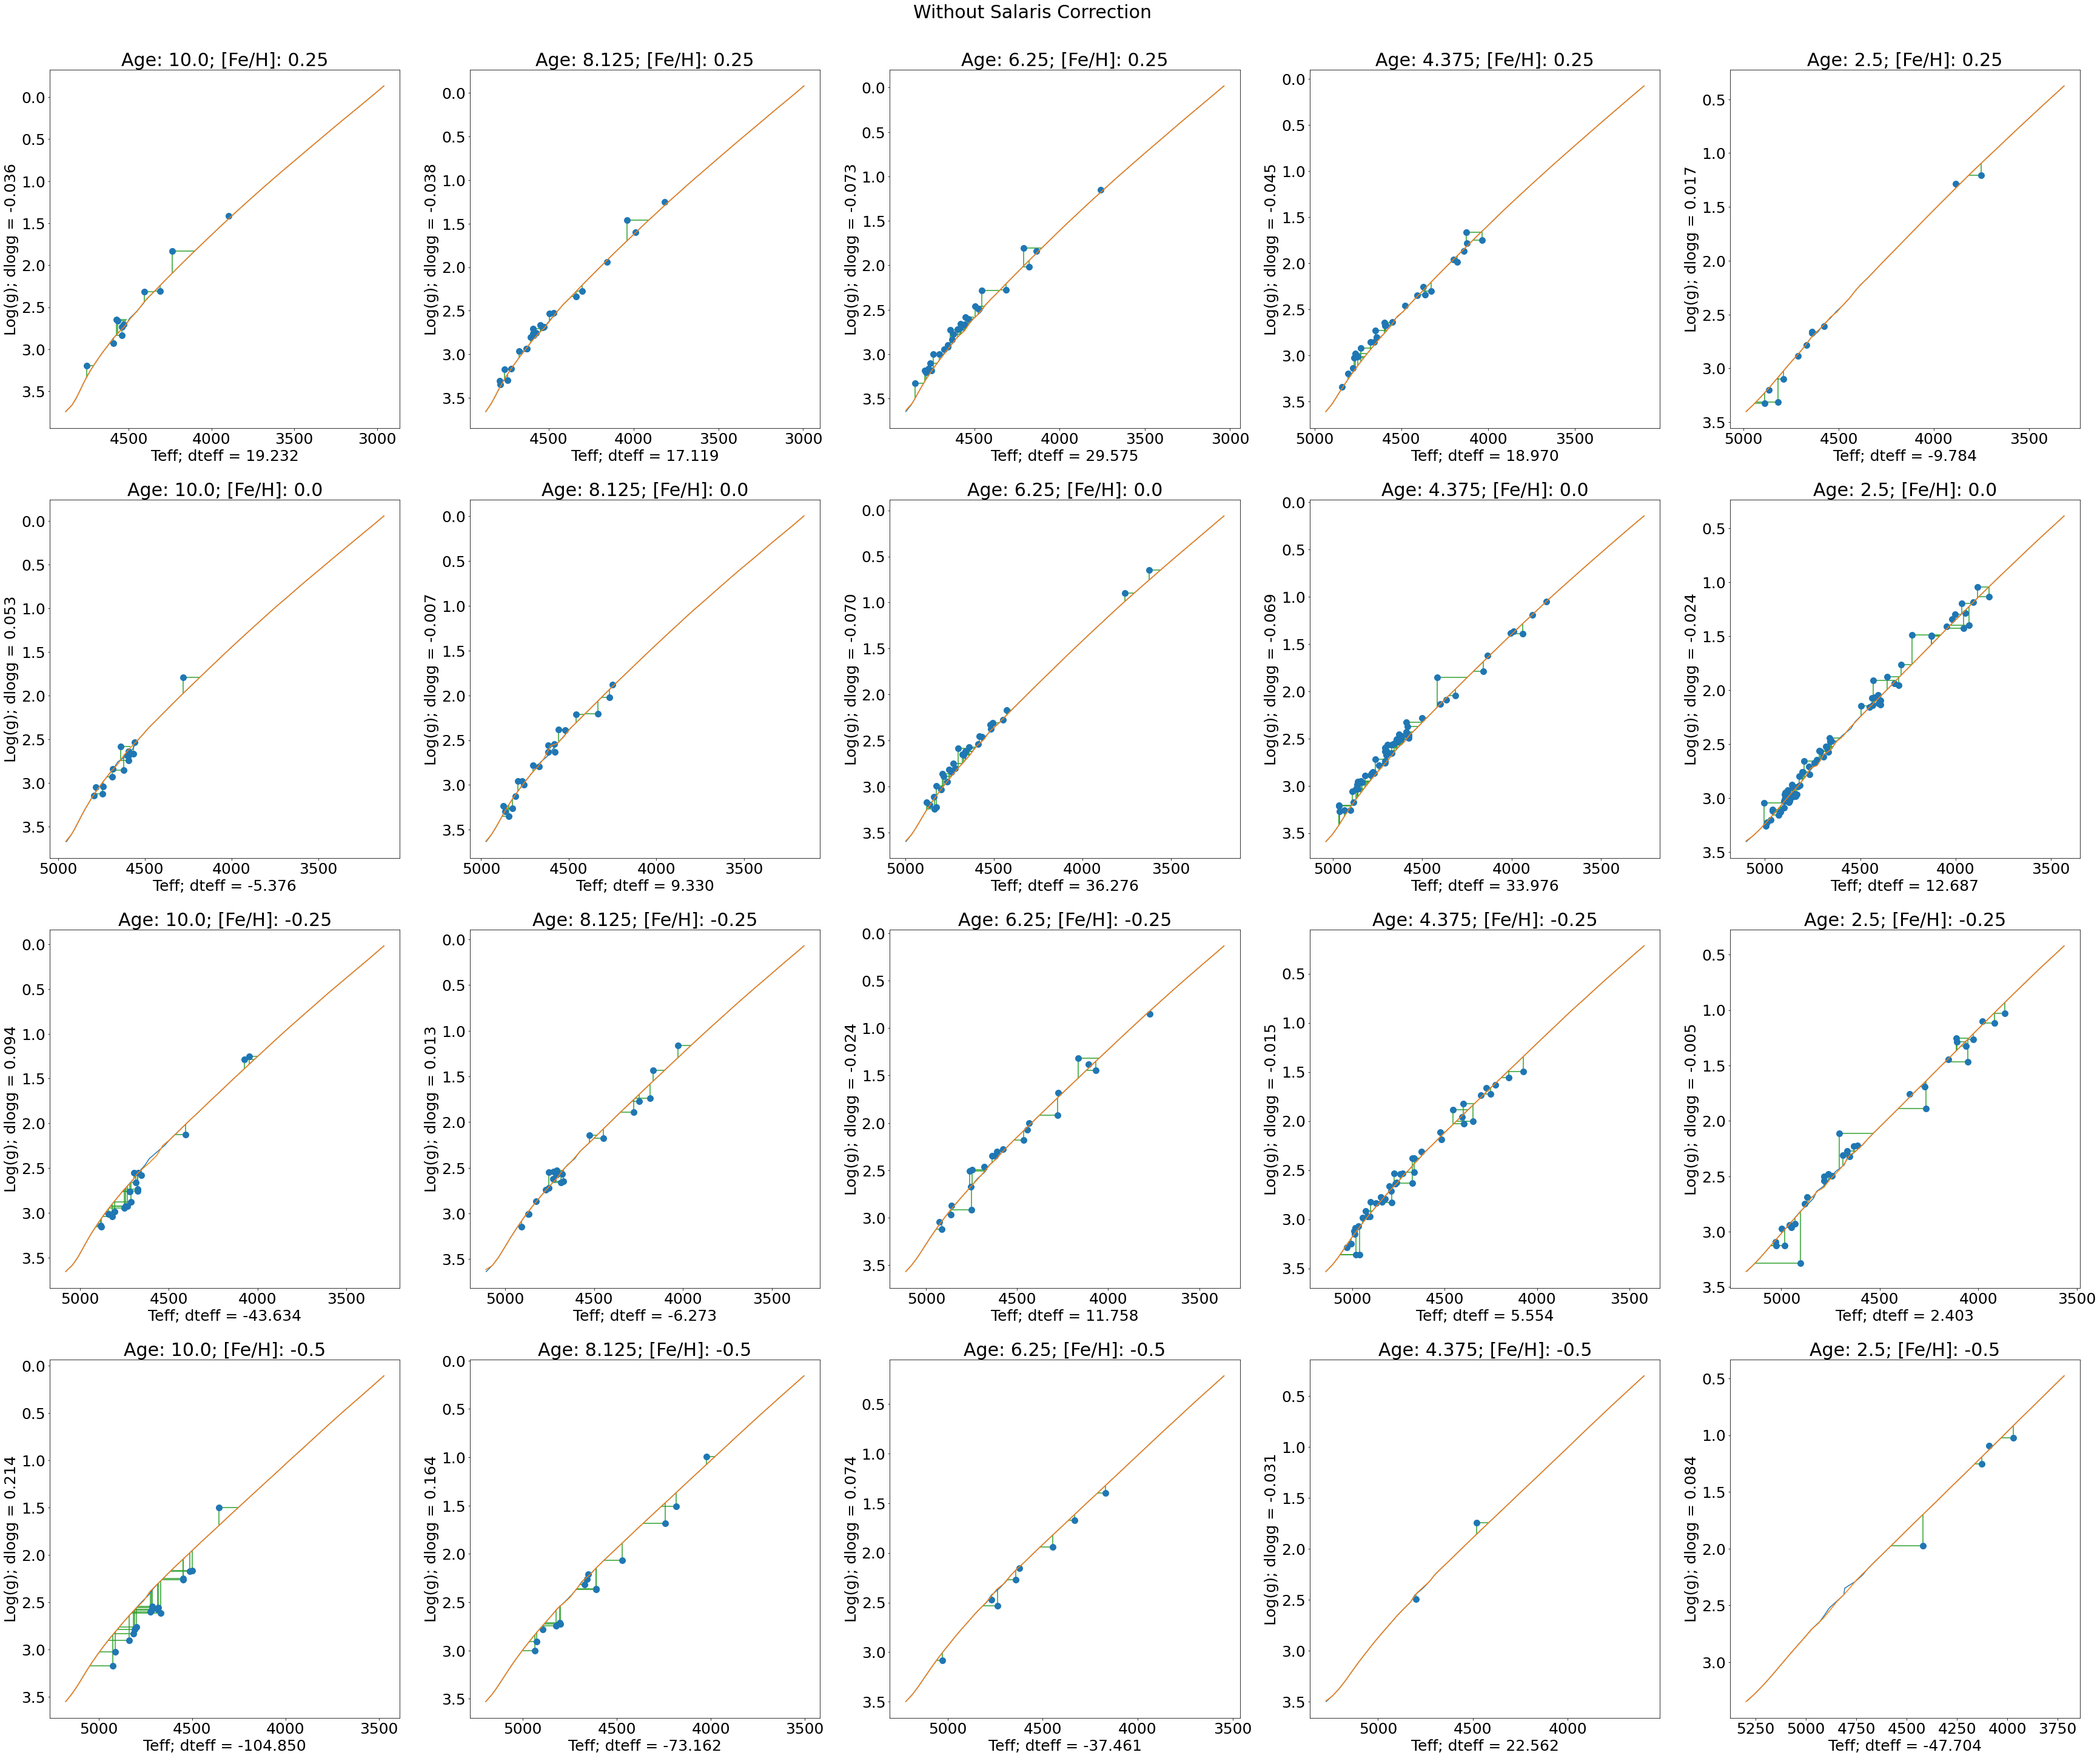

In [201]:
fehs = np.array([0.25,0.0,-0.25,-0.5])
ages = np.array([10,8.125,6.25,4.375,2.5])

dteff_arr = np.zeros((4,5))
dlogg_arr = np.zeros((4,5))

fig, ax = plt.subplots(4,5,figsize=[60,50])
for i in range(4):
    for j in range(5):
        
        ### Select stars and isochrone
        stars_select = np.where((k3dr17['IntAge']>=ages[j]-0.25)&(k3dr17['IntAge']<=ages[j]+0.25)&
                                (k3dr17['Fe/H']<=fehs[i]+0.05)&(k3dr17['Fe/H']>=fehs[i]-0.05))
        
        starslogg = k3dr17['Logg'][stars_select]
        starsteff = kdr17['TEFF'][stars_select]
        
        starslogg = starslogg[np.argsort(starsteff)]
        starsteff = starsteff[np.argsort(starsteff)]
        
        salcorr = 0 #np.median(np.log10(0.655*(10**(apoafe[stars_select]))+0.345))
        
        stars_iso = massive[np.where((massive['MH']==closest(massive['MH'],fehs[i]+salcorr))&
                                     (massive['logAge']==closest(massive['logAge'],np.log10(ages[j]*10**9))))]
        
        ### plot stars
        ax[i,j].scatter(starsteff,starslogg,s=100)
        
        ### dteff 
        stars_iso = stars_iso[np.argsort(stars_iso['logg'])]

        spl1 = US(stars_iso['logg'][::2],10**stars_iso['logTe'][::2],s=0)
        spl_xs1 = np.linspace(min(stars_iso['logg']),max(stars_iso['logg']))
        dteffs = starsteff-spl1(starslogg)
        dteff_arr[i,j] = np.nanmedian(dteffs)
        
        for k in range(len(dteffs)):
            ax[i,j].hlines(y=starslogg[k],xmin=starsteff[k],xmax=starsteff[k]-dteffs[k],
                           color='tab:green',zorder=0)
        
        ax[i,j].plot(spl1(spl_xs1),spl_xs1)
        
        ### dlogg
        stars_iso = stars_iso[np.argsort(stars_iso['logTe'])]
        
        spl2 = US(10**stars_iso['logTe'][::2],stars_iso['logg'][::2],s=0)
        spl_xs2 = np.linspace(min(10**stars_iso['logTe']),max(10**stars_iso['logTe']))
        dloggs = starslogg - spl2(starsteff)
        dlogg_arr[i,j] = np.nanmedian(dloggs)
        
        for k in range(len(dloggs)):
            ax[i,j].vlines(x=starsteff[k],ymin=starslogg[k],ymax=starslogg[k]-dloggs[k],
                           color='tab:green',zorder=0)
            
        ax[i,j].plot(spl_xs2,spl2(spl_xs2))
        
        ### Formatting
        ax[i,j].invert_xaxis()
        ax[i,j].invert_yaxis()
        
        ax[i,j].set_title(r'Age: {}; [Fe/H]: {}'.format(ages[j],fehs[i]))
        
        ax[i,j].set_xlabel(r'Teff; dteff = {:.3f}'.format(np.nanmedian(dteffs)))
        ax[i,j].set_ylabel(r'Log(g); dlogg = {:.3f}'.format(np.nanmedian(dloggs)))

plt.suptitle(r'Without Salaris Correction',y=0.91)
plt.savefig('../plots/isochrone_compare_NoSalaris.pdf',dpi=300,bbox_inches='tight')
plt.show()

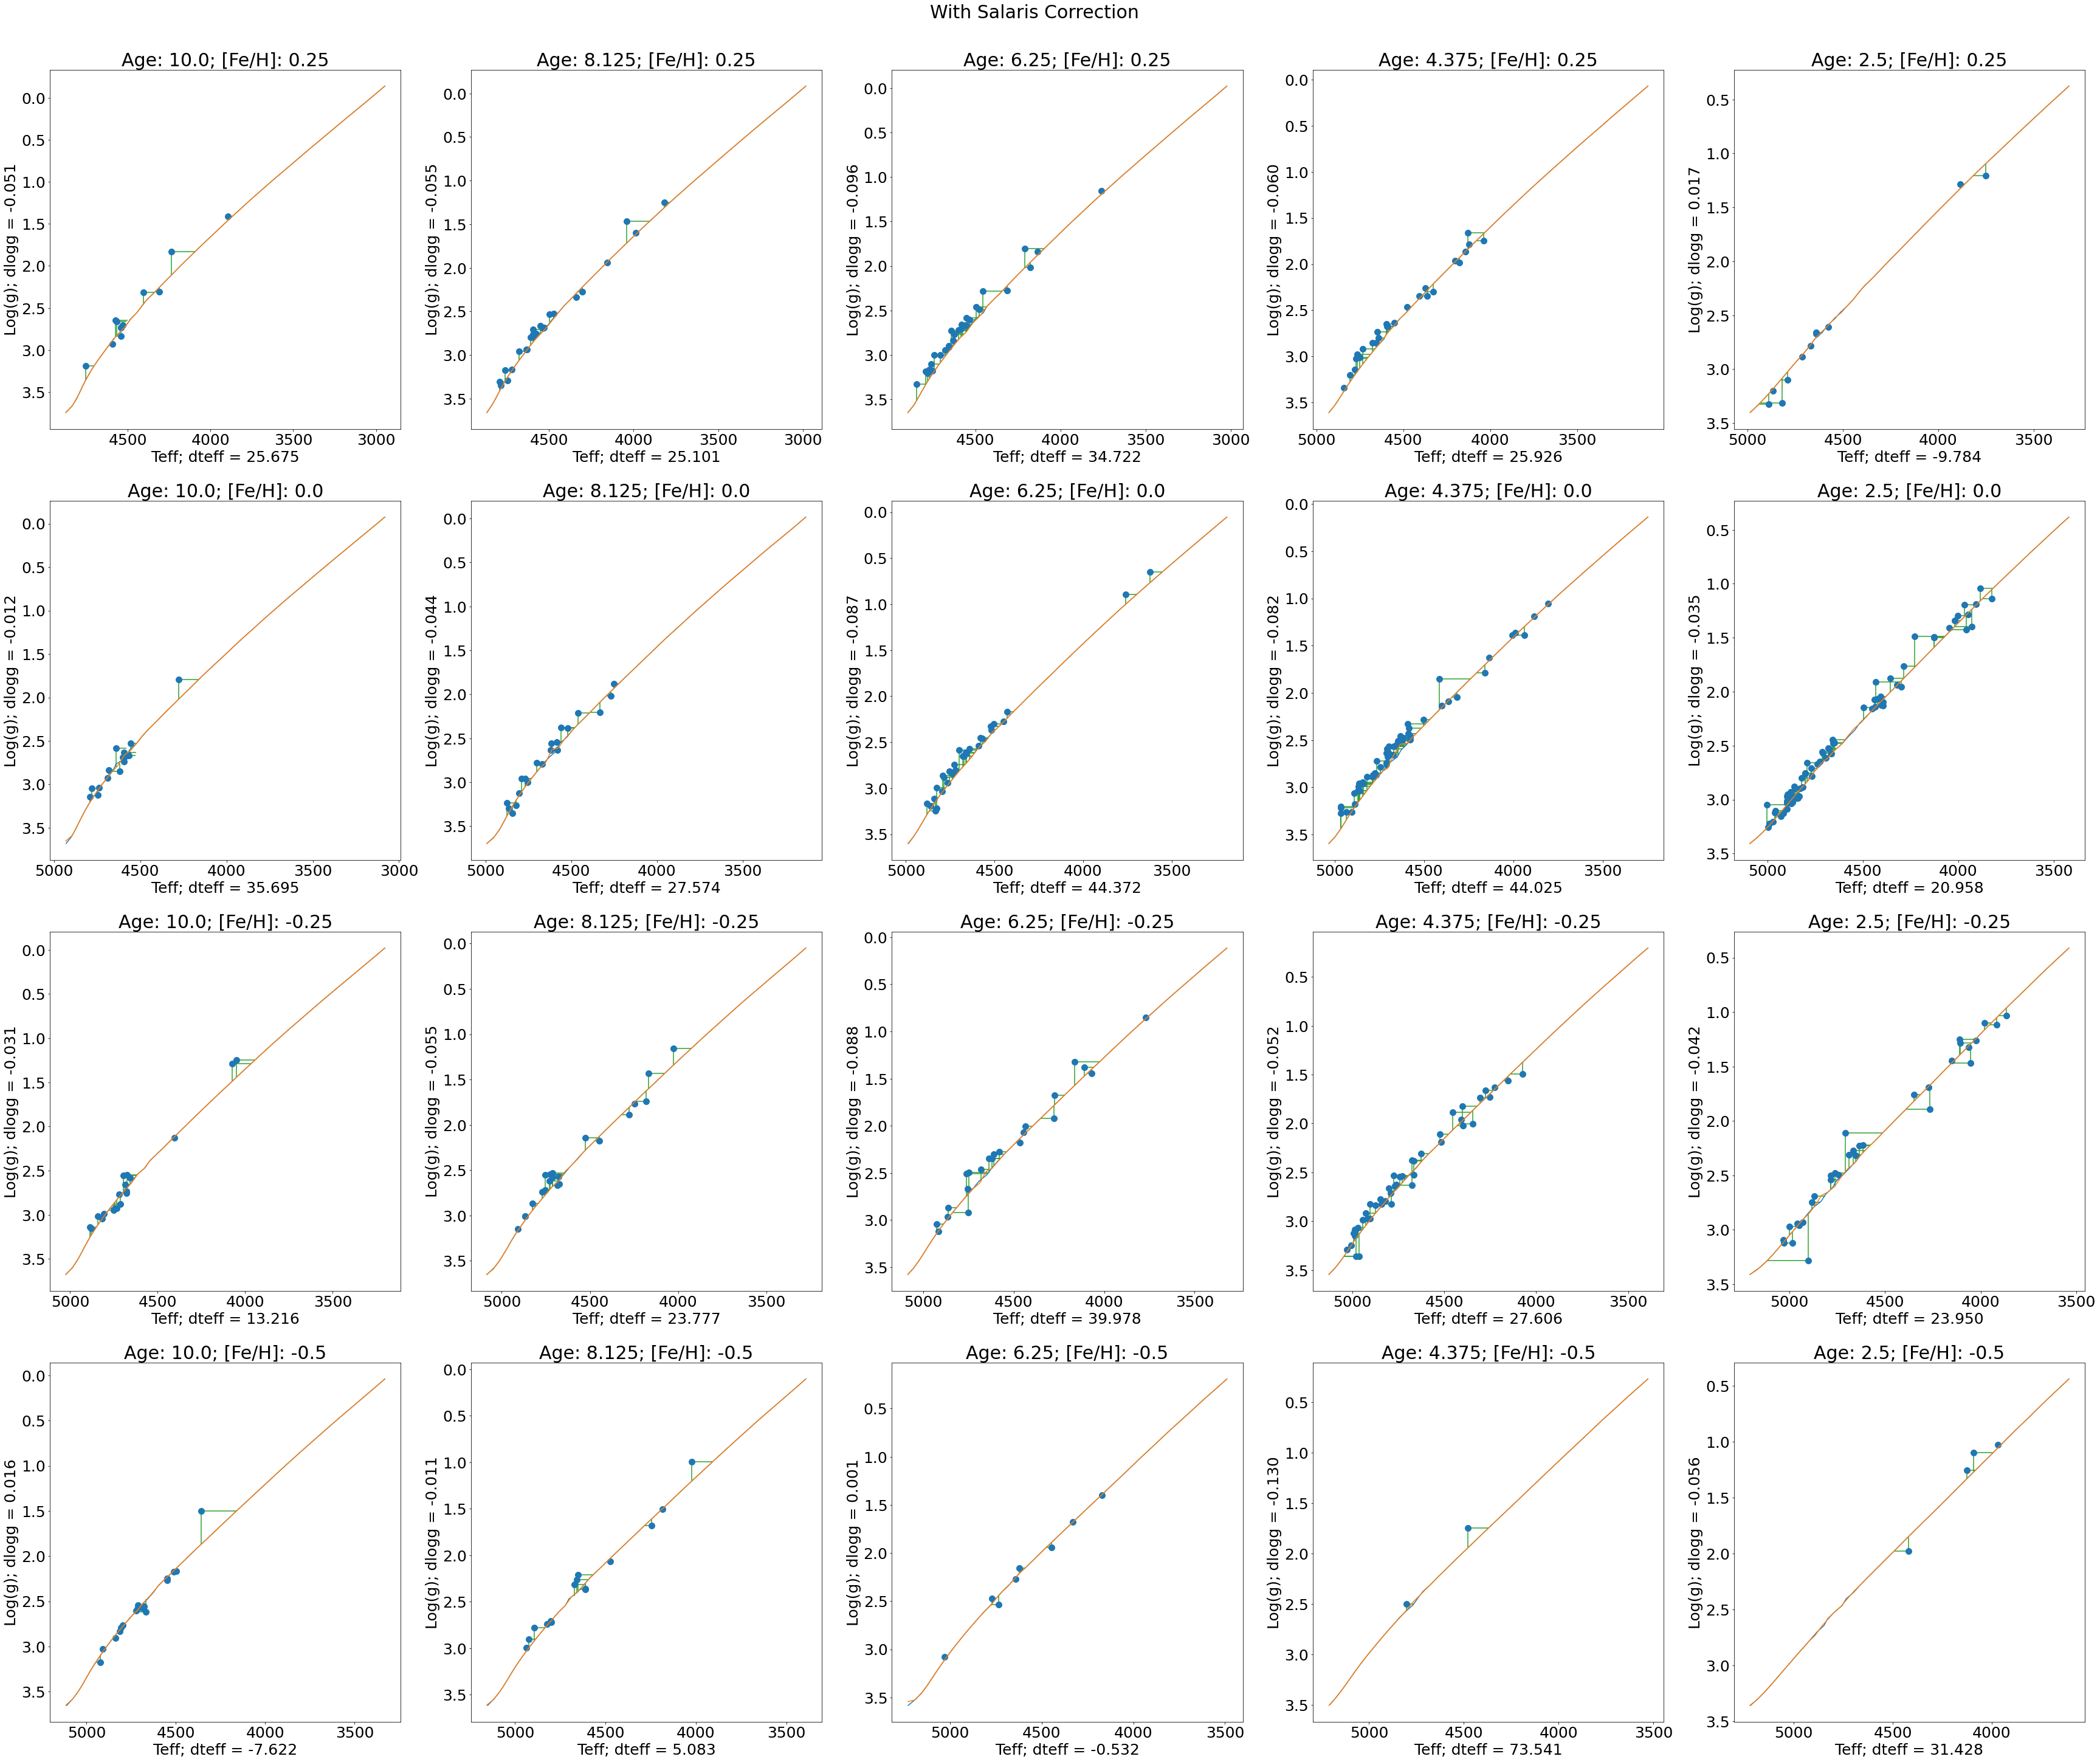

In [248]:
fehs = np.array([0.25,0.0,-0.25,-0.5])
ages = np.array([10,8.125,6.25,4.375,2.5])

dteff_arr_salaris = np.zeros((4,5))
dlogg_arr_salaris = np.zeros((4,5))

fehs_arr = np.zeros((4,5))
ages_arr = np.zeros((4,5))

alpha_arr = np.zeros((4,5))
salcorr_arr = np.zeros((4,5))

ids_single = np.array([])

sal_dlg_single = np.array([])
sal_dlt_single = np.array([])

fig, ax = plt.subplots(4,5,figsize=[60,50])
for i in range(4):
    for j in range(5):
        
        fehs_arr[i,j] = fehs[i]
        ages_arr[i,j] = ages[j]
        
        ### Select stars and their properties
        stars_select = np.where((k3dr17['IntAge']>=ages[j]-0.25)&(k3dr17['IntAge']<=ages[j]+0.25)&
                                (k3dr17['Fe/H']<=fehs[i]+0.05)&(k3dr17['Fe/H']>=fehs[i]-0.05))
        
        starslogg = k3dr17['Logg'][stars_select]
        starsids = kdr17['APOGEE_ID'][stars_select]
        starsteff = kdr17['TEFF'][stars_select]
        
        salcorr = np.nanmedian(np.log10(0.655*(10**(apoafe[stars_select]))+0.345))
        starsals = np.log10(0.655*(10**(apoafe[stars_select]))+0.345)
        alpha_arr[i,j] = np.nanmedian(apoafe[stars_select])
        salcorr_arr[i,j] = salcorr
        
        starsids = starsids[np.argsort(starsteff)]
        ids_single = np.append(ids_single,starsids)

        ### Select isochrone
        stars_iso = massive[np.where((massive['MH']==closest(massive['MH'],fehs[i]+salcorr))&
                                     (massive['logAge']==closest(massive['logAge'],np.log10(ages[j]*10**9))))]
        
        ### plot stars
        ax[i,j].scatter(starsteff,starslogg,s=100)
        
        ### dteff
        stars_iso = stars_iso[np.argsort(stars_iso['logg'])]

        spl1 = US(stars_iso['logg'][::2],10**stars_iso['logTe'][::2],s=0)
        spl_xs1 = np.linspace(min(stars_iso['logg']),max(stars_iso['logg']))
        dteffs = starsteff-spl1(starslogg)
        sal_dlt_single = np.append(sal_dlt_single,dteffs)
        dteff_arr_salaris[i,j] = np.nanmedian(dteffs)
        
        for k in range(len(dteffs)):
            ax[i,j].hlines(y=starslogg[k],xmin=starsteff[k],xmax=starsteff[k]-dteffs[k],
                           color='tab:green',zorder=0)
        
        ax[i,j].plot(spl1(spl_xs1),spl_xs1)
        
        ### dlogg
        stars_iso = stars_iso[np.argsort(stars_iso['logTe'])]
        
        spl2 = US(10**stars_iso['logTe'][::2],stars_iso['logg'][::2],s=0)
        spl_xs2 = np.linspace(min(10**stars_iso['logTe']),max(10**stars_iso['logTe']))
        dloggs = starslogg - spl2(starsteff)
        sal_dlg_single = np.append(sal_dlg_single,dloggs)
        dlogg_arr_salaris[i,j] = np.nanmedian(dloggs)
        
        for k in range(len(dloggs)):
            ax[i,j].vlines(x=starsteff[k],ymin=starslogg[k],ymax=starslogg[k]-dloggs[k],
                           color='tab:green',zorder=0)
            
        ax[i,j].plot(spl_xs2,spl2(spl_xs2))
        
        ### Formatting
        ax[i,j].invert_xaxis()
        ax[i,j].invert_yaxis()
        
        ax[i,j].set_title(r'Age: {}; [Fe/H]: {}'.format(ages[j],fehs[i]))
        
        ax[i,j].set_xlabel(r'Teff; dteff = {:.3f}'.format(np.nanmedian(dteffs)))
        ax[i,j].set_ylabel(r'Log(g); dlogg = {:.3f}'.format(np.nanmedian(dloggs)))

plt.suptitle(r'With Salaris Correction',y=0.91)
plt.savefig('../plots/isochrone_compare_Salaris.pdf',dpi=300,bbox_inches='tight')
plt.show()

In [208]:
c1 = fits.Column(name='FE_H', array=fehs_arr.ravel(), format='E')
c2 = fits.Column(name='FE_H_SALARIS', array=salcorr_arr.ravel(), format='E')
c3 = fits.Column(name='ALPHA_FE', array=alpha_arr.ravel(), format='E')
c4 = fits.Column(name='AGE', array=ages_arr.ravel(), format='E')
c5 = fits.Column(name='DTEFF', array=dteff_arr.ravel(), format='E')
c6 = fits.Column(name='DTEFF_SALARIS', array=dteff_arr_salaris.ravel(), format='E')
c7 = fits.Column(name='DLOGG', array=dlogg_arr.ravel(), format='E')
c8 = fits.Column(name='DLOGG_SALARIS', array=dlogg_arr_salaris.ravel(), format='E')

table_hdu = fits.BinTableHDU.from_columns([c1, c2, c3, c4, c5, c6, c7, c8])
table_hdu.writeto('isochrone_shifts.fits',overwrite=True)

shift = Table(fits.getdata('isochrone_shifts.fits'))
shift.columns

<TableColumns names=('FE_H','FE_H_SALARIS','ALPHA_FE','AGE','DTEFF','DTEFF_SALARIS','DLOGG','DLOGG_SALARIS')>

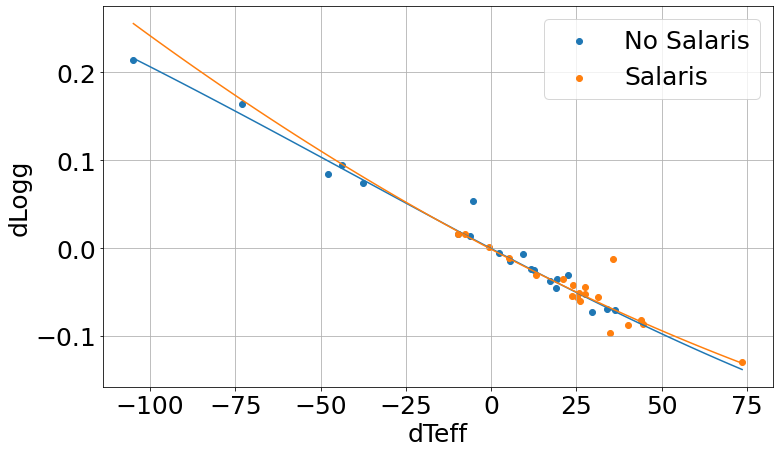

In [209]:
plt.figure(figsize=[12,7])
plt.scatter(shift['DTEFF'],shift['DLOGG'],label='No Salaris')

poly = np.poly1d(robust.polyfit(shift['DTEFF'][np.argsort(shift['DTEFF'])]
                            ,shift['DLOGG'][np.argsort(shift['DTEFF'])],3))
poly_xs = np.linspace(min(shift['DTEFF']),max(shift['DTEFF_SALARIS']))
plt.plot(poly_xs,poly(poly_xs),c='tab:blue')

plt.scatter(shift['DTEFF_SALARIS'],shift['DLOGG_SALARIS'],label='Salaris')

poly_sal = np.poly1d(robust.polyfit(shift['DTEFF_SALARIS'][np.argsort(shift['DTEFF_SALARIS'])]
                            ,shift['DLOGG_SALARIS'][np.argsort(shift['DTEFF_SALARIS'])],2))
poly_sal_xs = np.linspace(min(shift['DTEFF']),max(shift['DTEFF_SALARIS']))
plt.plot(poly_sal_xs,poly_sal(poly_sal_xs),c='tab:orange')

plt.legend()

plt.grid()

plt.xlabel(r'dTeff')
plt.ylabel(r'dLogg')
plt.savefig('../plots/dloggdteff.pdf',dpi=300,bbox_inches='tight')
plt.show()

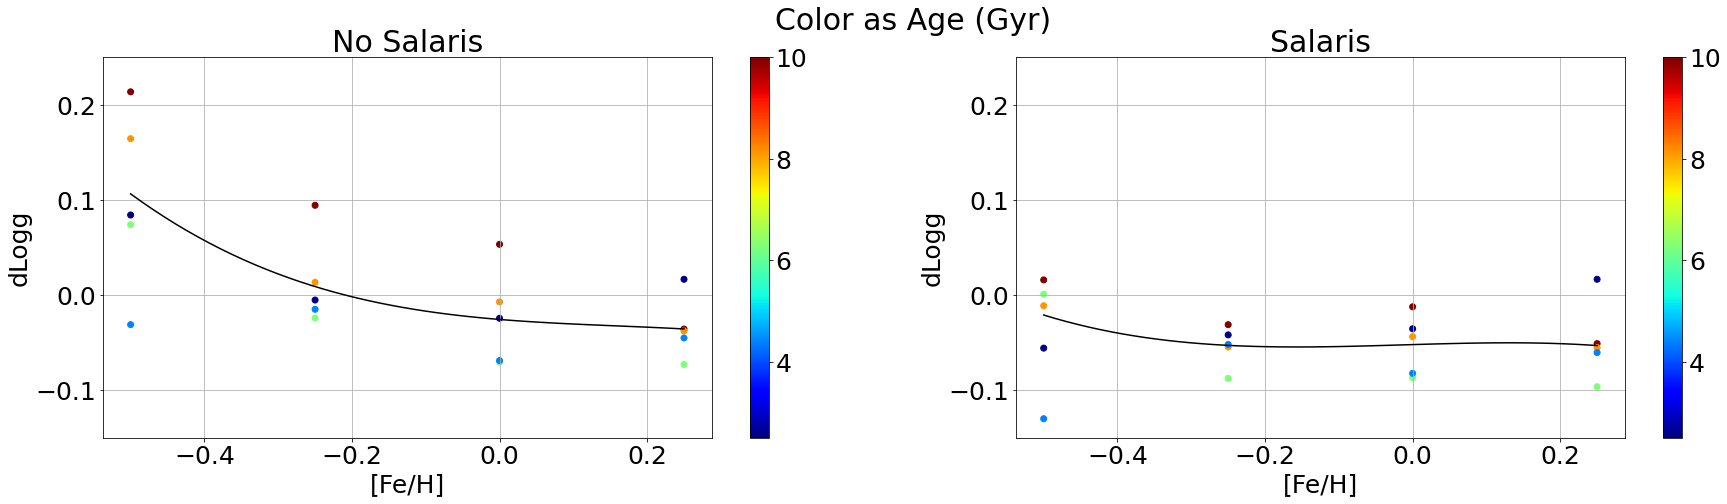

In [210]:
plt.figure(figsize=[30,7])
plt.suptitle(r'Color as Age (Gyr)')

plt.subplot(121)
plt.scatter(shift['FE_H'],shift['DLOGG'],c=shift['AGE'],cmap='jet',label='No Salaris')
plt.colorbar()

poly = np.poly1d(robust.polyfit(shift['FE_H'][np.argsort(shift['FE_H'])],
                                shift['DLOGG'][np.argsort(shift['FE_H'])],3))
poly_xs = np.linspace(min(shift['FE_H'][np.argsort(shift['FE_H'])]),
                           max(shift['FE_H'][np.argsort(shift['FE_H'])]))
plt.plot(poly_xs,poly(poly_xs),c='k')

plt.title(r'No Salaris')
plt.ylabel(r'dLogg')
plt.xlabel(r'[Fe/H]')

plt.ylim(-0.15,0.25)

plt.grid()

plt.subplot(122)
plt.scatter(shift['FE_H'],shift['DLOGG_SALARIS'],c=shift['AGE'],cmap='jet',label='Salaris')
plt.colorbar()

poly_sal = np.poly1d(robust.polyfit(shift['FE_H'][np.argsort(shift['FE_H'])],
                                shift['DLOGG_SALARIS'][np.argsort(shift['FE_H'])],3))
poly_sal_xs = np.linspace(min(shift['FE_H'][np.argsort(shift['FE_H'])]),
                           max(shift['FE_H'][np.argsort(shift['FE_H'])]))
plt.plot(poly_sal_xs,poly_sal(poly_sal_xs),c='k')

plt.title(r'Salaris')
plt.ylabel(r'dLogg')
plt.xlabel(r'[Fe/H]')

plt.ylim(-0.15,0.25)

plt.grid()

plt.savefig('../plots/feh_dlogg_age.pdf',dpi=300,bbox_inches='tight')
plt.show()

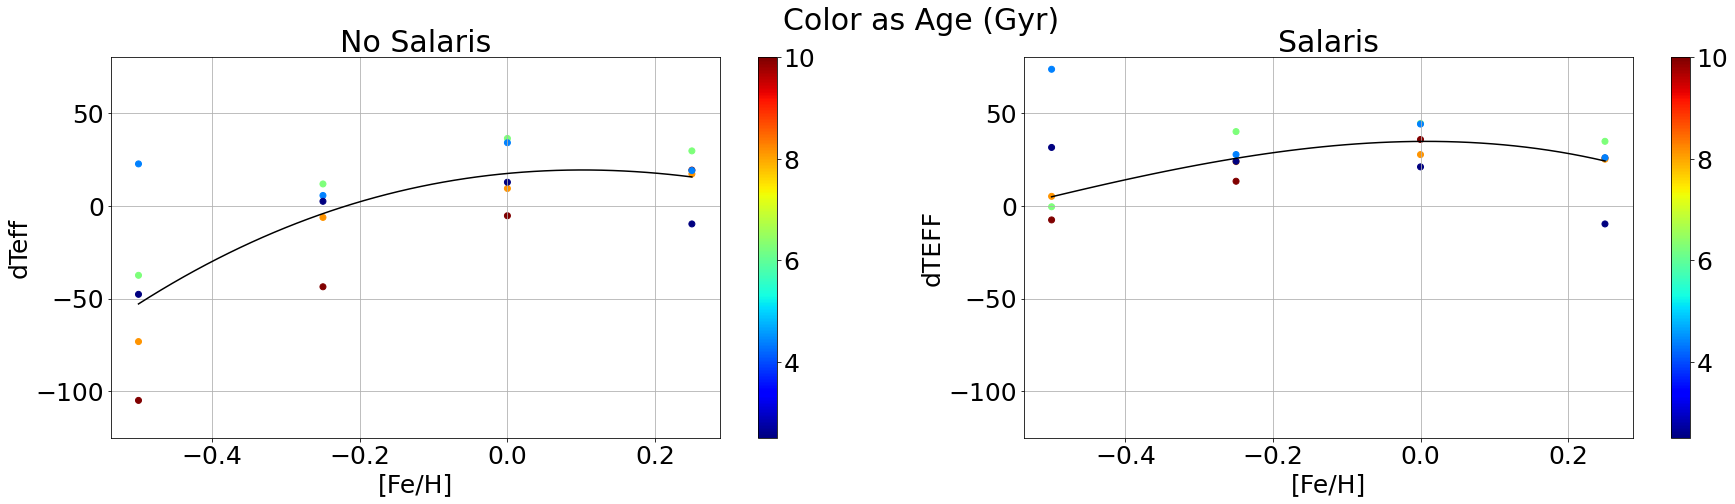

In [211]:
plt.figure(figsize=[30,7])
plt.suptitle(r'Color as Age (Gyr)')

plt.subplot(121)
plt.scatter(shift['FE_H'],shift['DTEFF'],c=shift['AGE'],cmap='jet',label='No Salaris')
plt.colorbar()

poly = np.poly1d(robust.polyfit(shift['FE_H'][np.argsort(shift['FE_H'])],
                                shift['DTEFF'][np.argsort(shift['FE_H'])],3))
poly_xs = np.linspace(min(shift['FE_H'][np.argsort(shift['FE_H'])]),
                           max(shift['FE_H'][np.argsort(shift['FE_H'])]))
plt.plot(poly_xs,poly(poly_xs),c='k')

plt.title(r'No Salaris')
plt.ylabel(r'dTeff')
plt.xlabel(r'[Fe/H]')

plt.ylim(-125,80)

plt.grid()

plt.subplot(122)
plt.scatter(shift['FE_H'],shift['DTEFF_SALARIS'],c=shift['AGE'],cmap='jet',label='Salaris')
plt.colorbar()

poly_sal = np.poly1d(robust.polyfit(shift['FE_H'][np.argsort(shift['FE_H'])],
                                shift['DTEFF_SALARIS'][np.argsort(shift['FE_H'])],3))
poly_sal_xs = np.linspace(min(shift['FE_H'][np.argsort(shift['FE_H'])]),
                           max(shift['FE_H'][np.argsort(shift['FE_H'])]))
plt.plot(poly_sal_xs,poly_sal(poly_sal_xs),c='k')

plt.title(r'Salaris')
plt.ylabel(r'dTEFF')
plt.xlabel(r'[Fe/H]')

plt.ylim(-125,80)

plt.grid()

plt.savefig('../plots/feh_dteff_age.pdf',dpi=300,bbox_inches='tight')
plt.show()

In [212]:
shift

<Table length=20>
  FE_H  FE_H_SALARIS   ALPHA_FE  ... DTEFF_SALARIS     DLOGG     DLOGG_SALARIS
float32   float32      float32   ...    float32       float32       float32   
------- ------------ ----------- ... ------------- ------------- -------------
   0.25   0.03930176   0.0586555 ...     25.674973  -0.035659403   -0.05098512
   0.25  0.023674851 0.035644554 ...     25.100933   -0.03773554  -0.055155568
   0.25   0.02425673   0.0365085 ...      34.72181   -0.07292667  -0.096344545
   0.25  0.020876773  0.03148225 ...     25.926023   -0.04507876  -0.060408287
   0.25  0.005464894 0.008315995 ...     -9.783704   0.016646001   0.016646001
    0.0  0.062582605   0.0922446 ...     35.694954   0.053368397  -0.012287725
    0.0  0.033403516   0.0500158 ...     27.573906 -0.0071319477  -0.043690797
    0.0  0.029361835   0.0440642 ...     44.372166  -0.070391424   -0.08680267
    0.0   0.02366926   0.0356362 ...     44.024635   -0.06877852   -0.08219561
    0.0  0.017096732 0.025838064 ...     20.958391  -0.024365278  -0.035378445
  -0.25   0.13567537  0.19308501 ...     13.215996    0.09440671  -0.031075085
  -0.25   0.07114339  0.10440099 ...     23.776585   0.013442946   -0.05454655
  -0.25  0.061084248   0.0901065 ...      39.97792   -0.02408685   -0.08753062
  -0.25  0.054454297 0.080607496 ...     27.605988  -0.014915615  -0.051861573
  -0.25  0.046033468 0.068450496 ...     23.949995  -0.005177798  -0.041820254
   -0.5   0.19355305  0.26888502 ...    -7.6222196    0.21369582    0.01595445
   -0.5    0.1608606  0.22645502 ...     5.0827694    0.16446203  -0.011206514
   -0.5   0.08145423  0.11890599 ...    -0.5319545    0.07401775  0.0009856545
   -0.5    0.1096721    0.154874 ...      73.54111  -0.031017398     -0.129908
   -0.5    0.1794326     0.25061 ...      31.42817    0.08419652  -0.055740234

# Individual Stars

In [349]:
kdteffs = 999999.0*np.ones(len(kdr17))
kdloggs = 999999.0*np.ones(len(kdr17))

for i in tqdm_notebook(range(len(kdr17))):
    
    salcorr = np.nanmedian(np.log10(0.655*(10**(apoafe[i]))+0.345))

    stars_iso = massive[np.where((massive['MH']==closest(massive['MH'],kdr17['FE_H'][i]+salcorr))&
                             (massive['logAge']==closest(massive['logAge'],np.log10(k3dr17['IntAge'][i]*10**9))))]
    
    try:
        
        ### dteff 
        stars_iso = stars_iso[np.argsort(stars_iso['logg'])]
        spl1 = US(stars_iso['logg'][::2],10**stars_iso['logTe'][::2],s=0)
        kdteffs[i] = kdr17['Teff'][i]-spl1(k3dr17['Logg'][i])

        ### dlogg
        stars_iso = stars_iso[np.argsort(stars_iso['logTe'])]
        spl2 = US(10**stars_iso['logTe'][::2],stars_iso['logg'][::2],s=0)
        kdloggs[i] = k3dr17['Logg'][i] - spl2(k3dr17['Teff'][i])
    
    except:
        
        try:
            ### dteff 
            stars_iso = stars_iso[np.argsort(stars_iso['logg'])]
            spl1 = US(stars_iso['logg'][::3],10**stars_iso['logTe'][::3],s=0)
            kdteffs[i] = kdr17['Teff'][i]-spl1(k3dr17['Logg'][i])

            ### dlogg
            stars_iso = stars_iso[np.argsort(stars_iso['logTe'])]
            spl2 = US(10**stars_iso['logTe'][::3],stars_iso['logg'][::3],s=0)
            kdloggs[i] = k3dr17['Logg'][i] - spl2(k3dr17['Teff'][i])
            
        except:
            kdteffs[i] = 999999.0
            kdloggs[i] = 999999.0


<ipython-input-349-035391b272fb>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(len(kdr17))):


Text(0, 0.5, 'dLogg')

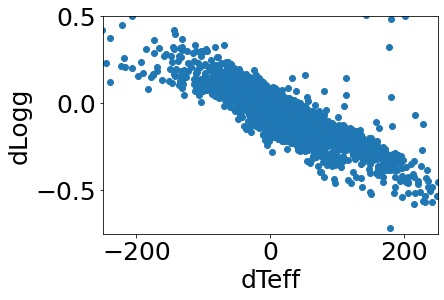

In [360]:
plt.scatter(kdteffs,kdloggs)
plt.xlim(-250,250)
plt.ylim(-0.75,0.5)
plt.xlabel(r'dTeff')
plt.ylabel(r'dLogg')

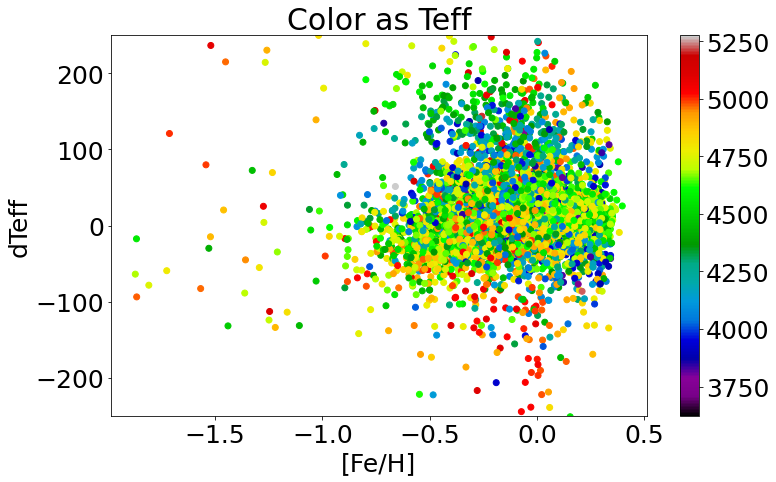

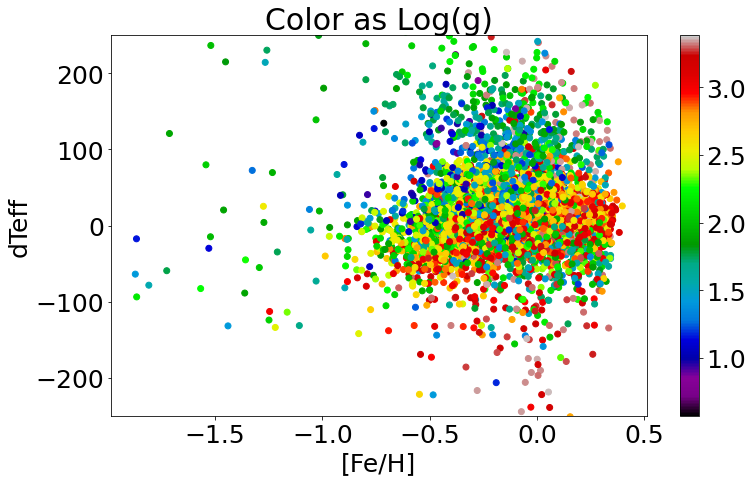

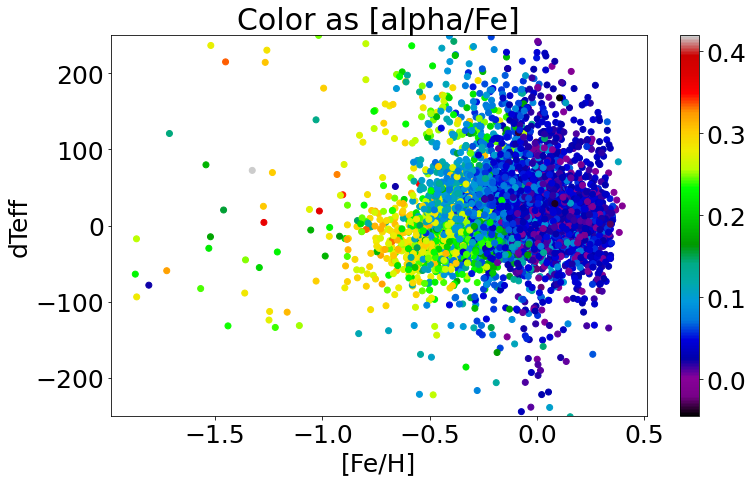

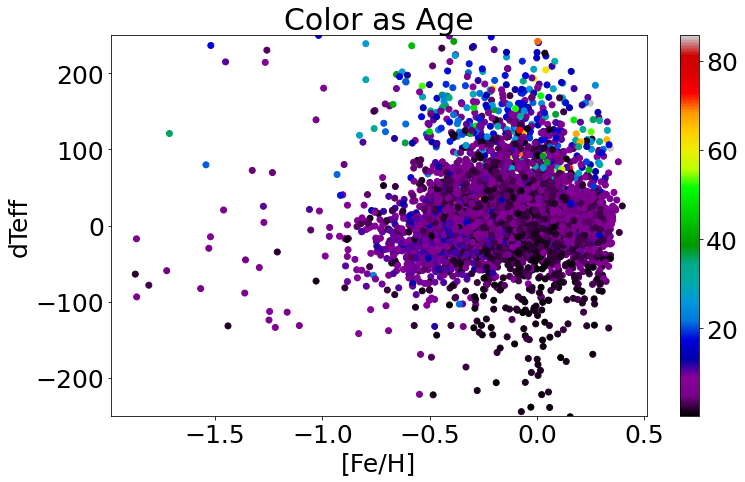

In [377]:
dfull_colors = np.array([kdr17['TEFF'],k3dr17['Logg'],apoafe,k3dr17['IntAge']])
dfull_titles = np.array(['Teff','Log(g)','[alpha/Fe]','Age'])

for i in range(len(dfull_colors)):

    plt.figure(figsize=[12,7])
    plt.scatter(kdr17['FE_H'],kdteffs,c=dfull_colors[i],cmap='nipy_spectral')
    plt.colorbar()
    plt.ylim(-250,250)

    plt.title(r'Color as {}'.format(dfull_titles[i]))
    plt.xlabel(r'[Fe/H]')
    plt.ylabel(r'dTeff')

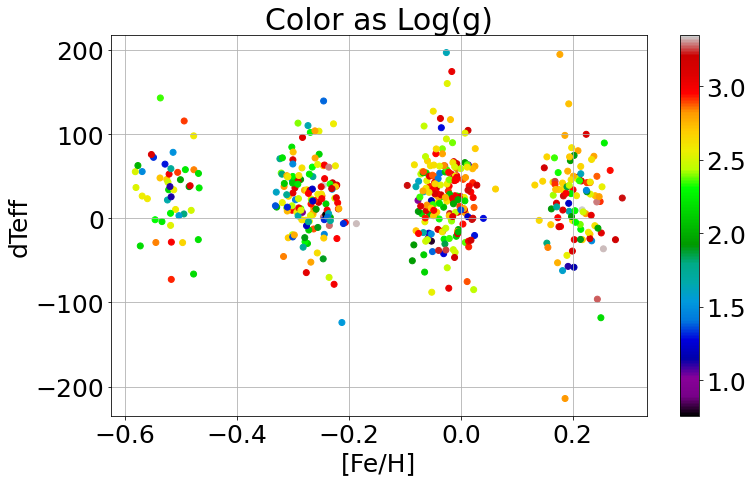

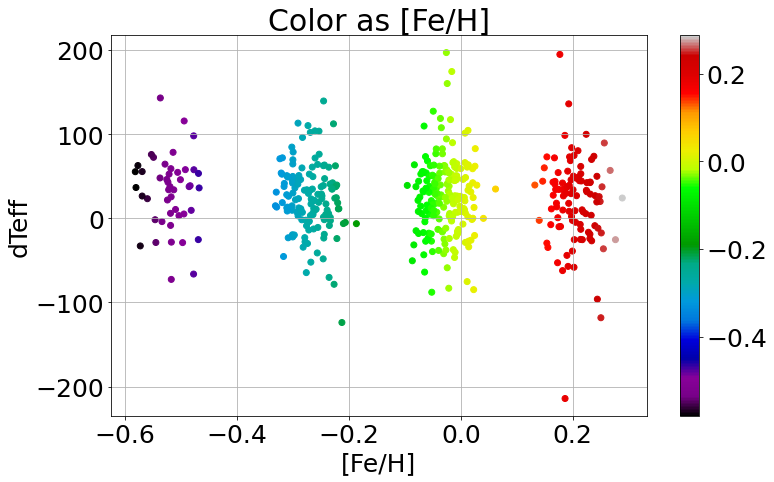

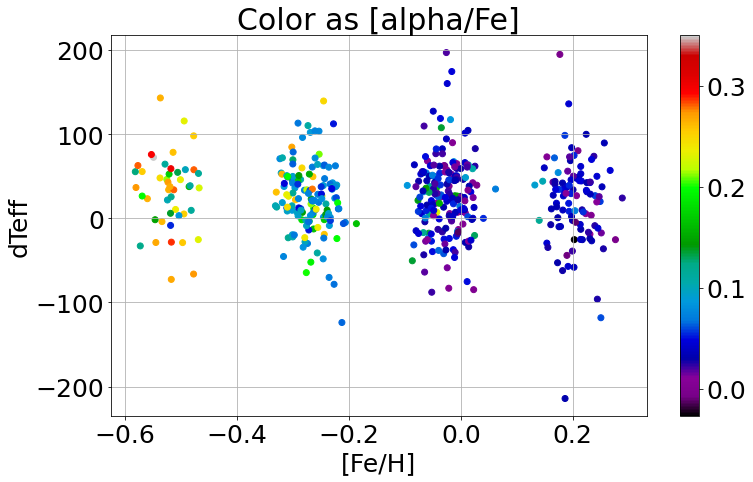

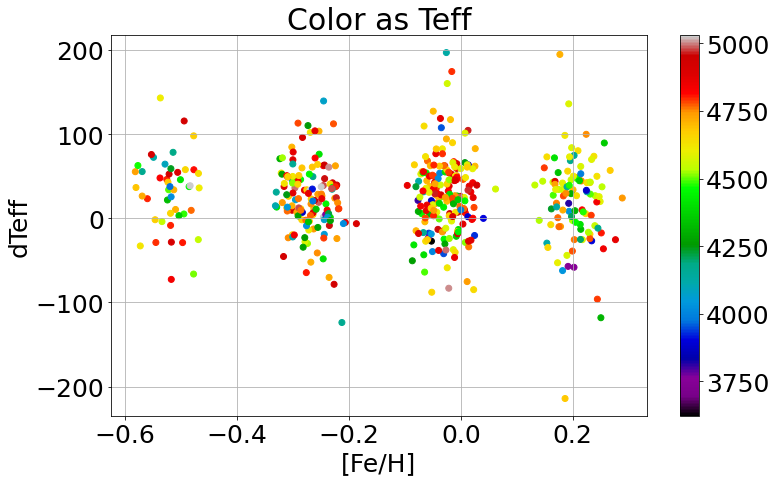

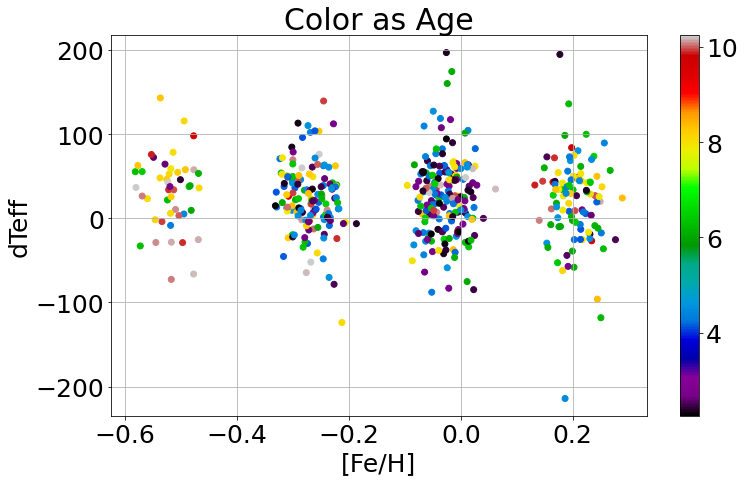

In [302]:
_, ids_idx, _ = np.intersect1d(kdr17['APOGEE_ID'],np.array(ids_single),return_indices=True)

d_colors = np.array([kdr17['LOGG'],kdr17['FE_H'],apoafe,kdr17['TEFF'],k3dr17['IntAge']])
d_titles = np.array(['Log(g)','[Fe/H]','[alpha/Fe]','Teff','Age'])


for i in range(len(d_colors)):
    plt.figure(figsize=[12,7])
    plt.scatter(kdr17['FE_H'][ids_idx],sal_dlt_single,c=d_colors[i][ids_idx],cmap='nipy_spectral')
    plt.colorbar()
    plt.grid()

    plt.title('Color as {}'.format(d_titles[i]))
    plt.xlabel(r'[Fe/H]')
    plt.ylabel(r'dTeff')
    plt.show()
    
# for i in range(len(d_colors)):
#     plt.figure(figsize=[12,7])
#     plt.scatter(kdr17['FE_H'][ids_idx],sal_dlg_single,c=d_colors[i][ids_idx],cmap='nipy_spectral')
#     plt.colorbar()
#     plt.grid()

#     plt.title('Color as {}'.format(d_titles[i]))
#     plt.xlabel(r'[Fe/H]')
#     plt.ylabel(r'dLog(g)')
#     plt.show()

In [316]:
_, ids_idx, _ = np.intersect1d(kdr17['APOGEE_ID'],np.array(ids_single),return_indices=True)

fincut = np.where((np.isfinite(kdr17['FE_H'][ids_idx])==True)&(np.isfinite(kdr17['TEFF'][ids_idx])==True)&
                  (np.isfinite(apoafe[ids_idx])==True)&(np.isfinite(kdr17['LOGG'][ids_idx])==True)&
                  (np.isfinite(sal_dlt_single)==True))


### [Fe/H] [Alpha/Fe] ###
print('Model: [Fe/H], [Alpha/Fe]')
pmodl = np.array([kdr17['FE_H'][ids_idx][fincut],apoafe[ids_idx][fincut]]).T
pmodl = sm.add_constant(pmodl)
model = sm.OLS(sal_dlt_single[fincut],pmodl).fit()
# print(model.summary())
predictions = model.predict(pmodl)
residual = predictions - sal_dlt_single[fincut]
print('Params:',np.asarray(model.params))
print('Max Resid:',np.max(np.absolute(residual)))
print('Mad of Resid:',mad(residual))
print(r'-----')

### [Fe/H] Teff ###
print('Model: [Fe/H], Teff')
pmodl = np.array([kdr17['FE_H'][ids_idx][fincut],kdr17['TEFF'][ids_idx][fincut]]).T
pmodl = sm.add_constant(pmodl)
model = sm.OLS(sal_dlt_single[fincut],pmodl).fit()
# print(model.summary())
predictions = model.predict(pmodl)
residual = predictions - sal_dlt_single[fincut]
print('Params:',np.asarray(model.params))
print('Max Resid:',np.max(np.absolute(residual)))
print('Mad of Resid:',mad(residual))
print(r'-----')

### [Fe/H] Log(g) ###
print('Model: [Fe/H], Log(g)')
pmodl = np.array([kdr17['FE_H'][ids_idx][fincut],kdr17['LOGG'][ids_idx][fincut]]).T
pmodl = sm.add_constant(pmodl)
model = sm.OLS(sal_dlt_single[fincut],pmodl).fit()
# print(model.summary())
predictions = model.predict(pmodl)
residual = predictions - sal_dlt_single[fincut]
print('Params:',np.asarray(model.params))
print('Max Resid:',np.max(np.absolute(residual)))
print('Mad of Resid:',mad(residual))
print(r'-----')

### [Fe/H] Age ###
print('Model: [Fe/H], Age')
pmodl = np.array([kdr17['FE_H'][ids_idx][fincut],k3dr17['IntAge'][ids_idx][fincut]]).T
pmodl = sm.add_constant(pmodl)
model = sm.OLS(sal_dlt_single[fincut],pmodl).fit()
# print(model.summary())
predictions = model.predict(pmodl)
residual = predictions - sal_dlt_single[fincut]
print('Params:',np.asarray(model.params))
print('Max Resid:',np.max(np.absolute(residual)))
print('Mad of Resid:',mad(residual))
print(r'-----')

Model: [Fe/H], [Alpha/Fe]
Params: [ 22.57509884 -10.60751564   5.18317764]
Max Resid: 234.9434183230107
Mad of Resid: 25.141776488690073
-----
Model: [Fe/H], Teff
Params: [-3.45825526e+01 -1.06427043e+01  1.25258356e-02]
Max Resid: 236.21905350809917
Mad of Resid: 24.79465561795534
-----
Model: [Fe/H], Log(g)
Params: [  7.41846864 -14.74638496   6.09466923]
Max Resid: 236.09254346241042
Mad of Resid: 24.320458262323548
-----
Model: [Fe/H], Age
Params: [ 2.28563257e+01 -1.18240066e+01  2.32086760e-03]
Max Resid: 234.84350460863664
Mad of Resid: 25.114661019168576
-----


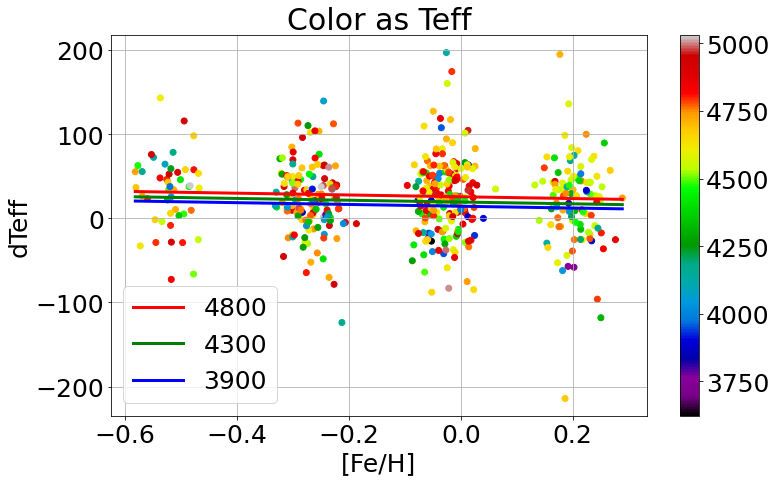

In [324]:
def fehteff(feh,teff):
    return (-3.45825526e+01) + (-1.06427043e+01)*feh + (1.25258356e-02)*teff

xs = np.linspace(min(kdr17['FE_H'][ids_idx]),max(kdr17['FE_H'][ids_idx]))

###
plt.figure(figsize=[12,7])
plt.scatter(kdr17['FE_H'][ids_idx],sal_dlt_single,c=kdr17['TEFF'][ids_idx],cmap='nipy_spectral')
plt.colorbar()
plt.grid()

plt.plot(xs,fehteff(xs,4800),label='4800',c='r',lw=3.0)
plt.plot(xs,fehteff(xs,4300),label='4300',c='g',lw=3.0)
plt.plot(xs,fehteff(xs,3900),label='3900',c='b',lw=3.0)
plt.legend()

plt.title('Color as Teff')
plt.xlabel(r'[Fe/H]')
plt.ylabel(r'dTeff')
plt.show()

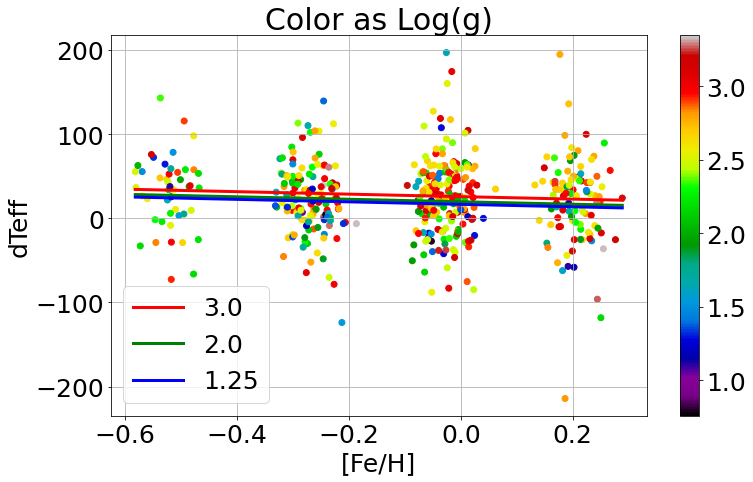

In [335]:
def fehlogg(feh,logg):
    return (7.41846864) + (-14.74638496)*feh + (6.09466923)*logg

xs = np.linspace(min(kdr17['FE_H'][ids_idx]),max(kdr17['FE_H'][ids_idx]))

###
plt.figure(figsize=[12,7])
plt.scatter(kdr17['FE_H'][ids_idx],sal_dlt_single,c=kdr17['LOGG'][ids_idx],cmap='nipy_spectral')
plt.colorbar()
plt.grid()

plt.plot(xs,fehlogg(xs,3.0),label='3.0',c='r',lw=3.0)
plt.plot(xs,fehlogg(xs,2.0),label='2.0',c='g',lw=3.0)
plt.plot(xs,fehlogg(xs,1.5),label='1.25',c='b',lw=3.0)
plt.legend()

plt.title('Color as Log(g)')
plt.xlabel(r'[Fe/H]')
plt.ylabel(r'dTeff')
plt.show()

In [334]:
## [Fe/H] [Alpha/Fe] ###
print('Model: [Fe/H], [Fe/H]**2, [Alpha/Fe]')
pmodl = np.array([kdr17['FE_H'][ids_idx][fincut],np.square(kdr17['FE_H'][ids_idx][fincut]),
                  apoafe[ids_idx][fincut]]).T
pmodl = sm.add_constant(pmodl)
model = sm.OLS(sal_dlt_single[fincut],pmodl).fit()
# print(model.summary())
predictions = model.predict(pmodl)
residual = predictions - sal_dlt_single[fincut]
print('Params:',np.asarray(model.params))
print('Max Resid:',np.max(np.absolute(residual)))
print('Mad of Resid:',mad(residual))
print(r'-----')

### [Fe/H] Teff ###
print('Model: [Fe/H], [Fe/H]**2, Teff')
pmodl = np.array([kdr17['FE_H'][ids_idx][fincut],np.square(kdr17['FE_H'][ids_idx][fincut]),
                  kdr17['TEFF'][ids_idx][fincut]]).T
pmodl = sm.add_constant(pmodl)
model = sm.OLS(sal_dlt_single[fincut],pmodl).fit()
# print(model.summary())
predictions = model.predict(pmodl)
residual = predictions - sal_dlt_single[fincut]
print('Params:',np.asarray(model.params))
print('Max Resid:',np.max(np.absolute(residual)))
print('Mad of Resid:',mad(residual))
print(r'-----')

### [Fe/H] Log(g) ###
print('Model: [Fe/H], [Fe/H]**2, Log(g)')
pmodl = np.array([kdr17['FE_H'][ids_idx][fincut],np.square(kdr17['FE_H'][ids_idx][fincut]),
                  kdr17['LOGG'][ids_idx][fincut]]).T
pmodl = sm.add_constant(pmodl)
model = sm.OLS(sal_dlt_single[fincut],pmodl).fit()
# print(model.summary())
predictions = model.predict(pmodl)
residual = predictions - sal_dlt_single[fincut]
print('Params:',np.asarray(model.params))
print('Max Resid:',np.max(np.absolute(residual)))
print('Mad of Resid:',mad(residual))
print(r'-----')

### [Fe/H] Age ###
print('Model: [Fe/H], [Fe/H]**2, Age')
pmodl = np.array([kdr17['FE_H'][ids_idx][fincut],np.square(kdr17['FE_H'][ids_idx][fincut]),
                  k3dr17['IntAge'][ids_idx][fincut]]).T
pmodl = sm.add_constant(pmodl)
model = sm.OLS(sal_dlt_single[fincut],pmodl).fit()
# print(model.summary())
predictions = model.predict(pmodl)
residual = predictions - sal_dlt_single[fincut]
print('Params:',np.asarray(model.params))
print('Max Resid:',np.max(np.absolute(residual)))
print('Mad of Resid:',mad(residual))
print(r'-----')

Model: [Fe/H], [Fe/H]**2, [Alpha/Fe]
Params: [ 22.59332607 -10.89472299  -1.77104783   5.87734271]
Max Resid: 234.86884616254812
Mad of Resid: 25.12956876874953
-----
Model: [Fe/H], [Fe/H]**2, Teff
Params: [-3.53613497e+01 -8.90223018e+00  6.79513149e+00  1.26474554e-02]
Max Resid: 236.56898988016596
Mad of Resid: 25.01920455058553
-----
Model: [Fe/H], [Fe/H]**2, Log(g)
Params: [  7.33099979 -14.18974948   2.19950658   6.1009583 ]
Max Resid: 236.20278313599206
Mad of Resid: 24.406179908791504
-----
Model: [Fe/H], [Fe/H]**2, Age
Params: [ 2.28579336e+01 -1.17402035e+01  3.44186415e-01 -1.75038855e-05]
Max Resid: 234.8622423117492
Mad of Resid: 25.122849074801003
-----


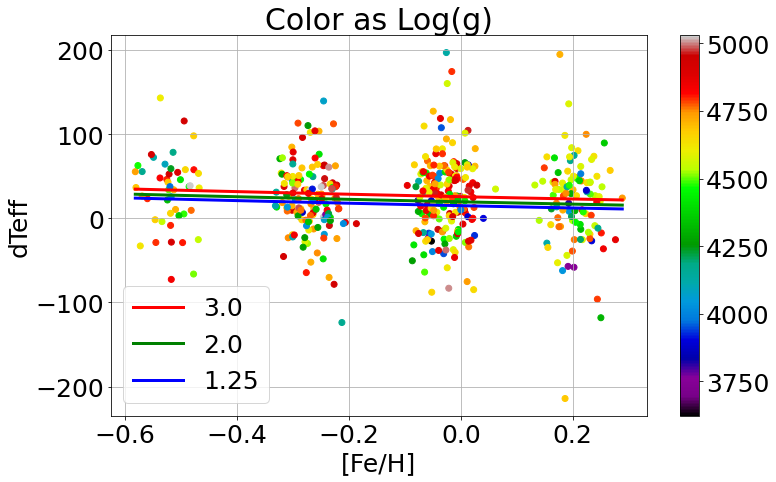

In [337]:
def fehsqlogg(feh,logg):
    return (7.33099979) + (-14.18974948)*feh + (2.19950658*feh**2) + (6.1009583)*logg

xs = np.linspace(min(kdr17['FE_H'][ids_idx]),max(kdr17['FE_H'][ids_idx]))

###
plt.figure(figsize=[12,7])
plt.scatter(kdr17['FE_H'][ids_idx],sal_dlt_single,c=kdr17['TEFF'][ids_idx],cmap='nipy_spectral')
plt.colorbar()
plt.grid()

plt.plot(xs,fehsqlogg(xs,3.0),label='3.0',c='r',lw=3.0)
plt.plot(xs,fehsqlogg(xs,2.0),label='2.0',c='g',lw=3.0)
plt.plot(xs,fehsqlogg(xs,1.25),label='1.25',c='b',lw=3.0)
plt.legend()

plt.title('Color as Log(g)')
plt.xlabel(r'[Fe/H]')
plt.ylabel(r'dTeff')
plt.show()

In [ ]:
def fehsqlogg(feh,logg):
    return (-3.53613497e+01) + (-8.90223018e+00)*feh + (6.79513149e+00*feh**2) + (1.26474554e-02)*logg

xs = np.linspace(min(kdr17['FE_H'][ids_idx]),max(kdr17['FE_H'][ids_idx]))

###
plt.figure(figsize=[12,7])
plt.scatter(kdr17['FE_H'][ids_idx],sal_dlt_single,c=kdr17['LOGG'][ids_idx],cmap='nipy_spectral')
plt.colorbar()
plt.grid()

plt.plot(xs,fehlogg(xs,3.0),label='3.0',c='r',lw=3.0)
plt.plot(xs,fehlogg(xs,2.0),label='2.0',c='g',lw=3.0)
plt.plot(xs,fehlogg(xs,1.5),label='1.5',c='b',lw=3.0)
plt.legend()

plt.title('Color as Log(g)')
plt.xlabel(r'[Fe/H]')
plt.ylabel(r'dTeff')
plt.show()

In [338]:
### [Fe/H] Teff ###
print('Model: [Fe/H], [Fe/H]**2, [Fe/H]**3, Teff')
pmodl = np.array([kdr17['FE_H'][ids_idx][fincut],np.square(kdr17['FE_H'][ids_idx][fincut]),
                  np.power(kdr17['FE_H'][ids_idx][fincut],3),kdr17['TEFF'][ids_idx][fincut]]).T
pmodl = sm.add_constant(pmodl)
model = sm.OLS(sal_dlt_single[fincut],pmodl).fit()
# print(model.summary())
predictions = model.predict(pmodl)
residual = predictions - sal_dlt_single[fincut]
print('Params:',np.asarray(model.params))
print('Max Resid:',np.max(np.absolute(residual)))
print('Mad of Resid:',mad(residual))
print(r'-----')

### [Fe/H] Teff ###
print('Model: [Fe/H], [Fe/H]**2, [Fe/H]**3, Log(g)')
pmodl = np.array([kdr17['FE_H'][ids_idx][fincut],np.square(kdr17['FE_H'][ids_idx][fincut]),
                  np.power(kdr17['FE_H'][ids_idx][fincut],3),kdr17['LOGG'][ids_idx][fincut]]).T
pmodl = sm.add_constant(pmodl)
model = sm.OLS(sal_dlt_single[fincut],pmodl).fit()
# print(model.summary())
predictions = model.predict(pmodl)
residual = predictions - sal_dlt_single[fincut]
print('Params:',np.asarray(model.params))
print('Max Resid:',np.max(np.absolute(residual)))
print('Mad of Resid:',mad(residual))
print(r'-----')

Model: [Fe/H], [Fe/H]**2, [Fe/H]**3, Teff
Params: [-3.12038171e+01  2.68349580e+00 -9.27727052e+01 -2.34573616e+02
  1.23172770e-02]
Max Resid: 236.37209253006023
Mad of Resid: 24.786503248418054
-----
Model: [Fe/H], [Fe/H]**2, [Fe/H]**3, Log(g)
Params: [  10.35106669   -2.34552458  -98.33904296 -237.16221449    5.96213011]
Max Resid: 236.01825743889037
Mad of Resid: 24.55371214038516
-----


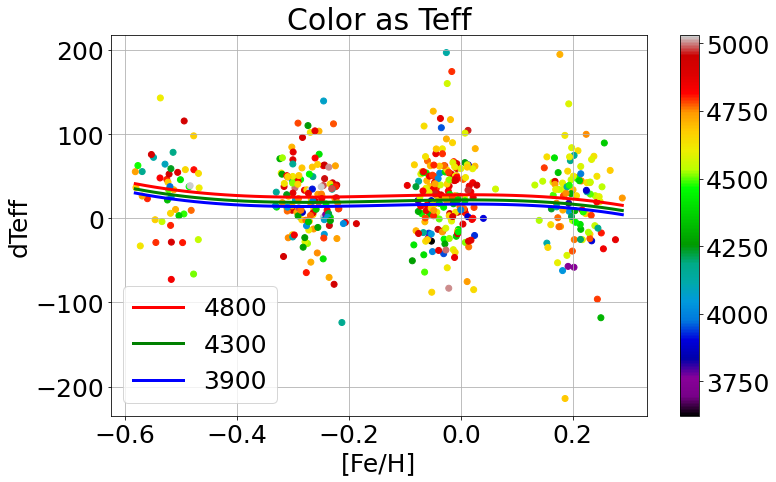

In [328]:
def fehcuteff(feh,teff):
    return ((-3.12038171e+01)+(2.68349580e+00)*feh+(-9.27727052e+01)*feh**2+(-2.34573616e+02)*feh**3+
            (1.23172770e-02)*teff)

xs = np.linspace(min(kdr17['FE_H'][ids_idx]),max(kdr17['FE_H'][ids_idx]))

###
plt.figure(figsize=[12,7])
plt.scatter(kdr17['FE_H'][ids_idx],sal_dlt_single,c=kdr17['TEFF'][ids_idx],cmap='nipy_spectral')
plt.colorbar()
plt.grid()

plt.plot(xs,fehcuteff(xs,4800),label='4800',c='r',lw=3.0)
plt.plot(xs,fehcuteff(xs,4300),label='4300',c='g',lw=3.0)
plt.plot(xs,fehcuteff(xs,3900),label='3900',c='b',lw=3.0)
plt.legend()

plt.title('Color as Teff')
plt.xlabel(r'[Fe/H]')
plt.ylabel(r'dTeff')
plt.show()

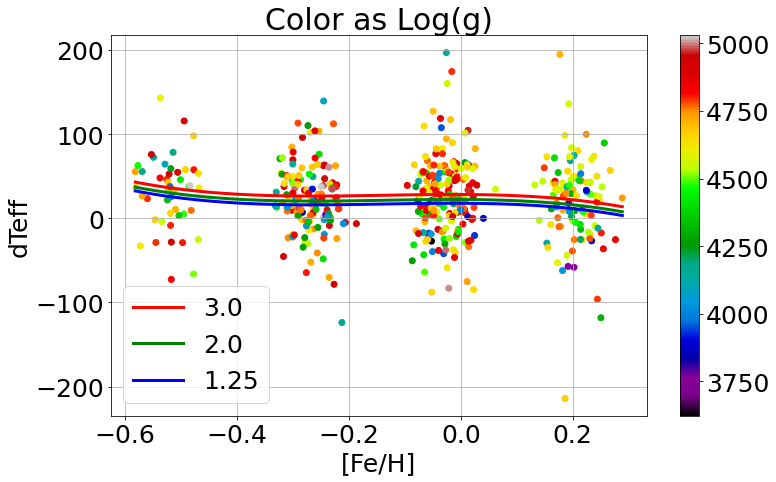

In [340]:
def fehculogg(feh,logg):
              
    return ((10.35106669)+(-2.34552458)*feh+(-98.33904296)*feh**2+(-237.16221449)*feh**3+(5.96213011)*logg)

xs = np.linspace(min(kdr17['FE_H'][ids_idx]),max(kdr17['FE_H'][ids_idx]))

###
plt.figure(figsize=[12,7])
plt.scatter(kdr17['FE_H'][ids_idx],sal_dlt_single,c=kdr17['TEFF'][ids_idx],cmap='nipy_spectral')
plt.colorbar()
plt.grid()

plt.plot(xs,fehculogg(xs,3.0),label='3.0',c='r',lw=3.0)
plt.plot(xs,fehculogg(xs,2.0),label='2.0',c='g',lw=3.0)
plt.plot(xs,fehculogg(xs,1.25),label='1.25',c='b',lw=3.0)
plt.legend()

plt.title('Color as Log(g)')
plt.xlabel(r'[Fe/H]')
plt.ylabel(r'dTeff')
plt.show()

In [318]:
### [Fe/H] Teff Log(g) ###
print('Model: [Fe/H], Teff, Log(g)')
pmodl = np.array([kdr17['FE_H'][ids_idx][fincut],kdr17['TEFF'][ids_idx][fincut],kdr17['TEFF'][ids_idx][fincut]]).T
pmodl = sm.add_constant(pmodl)
model = sm.OLS(sal_dlt_single[fincut],pmodl).fit()
# print(model.summary())
predictions = model.predict(pmodl)
residual = predictions - sal_dlt_single[fincut]
print('Params:',np.asarray(model.params))
print('Max Resid:',np.max(np.absolute(residual)))
print('Mad of Resid:',mad(residual))
print(r'-----')

Model: [Fe/H], Teff, Log(g)
Params: [-3.45825526e+01 -1.06427043e+01  6.26291786e-03  6.26291776e-03]
Max Resid: 236.21905350809118
Mad of Resid: 24.794655617955176
-----


In [298]:
import statsmodels.api as sm 
import itertools as it

_, ids_idx, _ = np.intersect1d(kdr17['APOGEE_ID'],np.array(ids_single),return_indices=True)

fincut = np.where((np.isfinite(kdr17['FE_H'][ids_idx])==True)&(np.isfinite(kdr17['TEFF'][ids_idx])==True)&
                  (np.isfinite(apoafe[ids_idx])==True)&(np.isfinite(kdr17['LOGG'][ids_idx])==True)&
                  (np.isfinite(sal_dlt_single)==True))

# linear terms
x1 = kdr17['FE_H'][ids_idx][fincut]
x2 = kdr17['TEFF'][ids_idx][fincut]
x3 = apoafe[ids_idx][fincut]
x4 = kdr17['LOGG'][ids_idx][fincut]

# linear int
x12 = np.multiply(x1,x2)
x13 = np.multiply(x1,x3)
x14 = np.multiply(x1,x4)
x23 = np.multiply(x2,x3)
x24 = np.multiply(x2,x4)

# squares
x1sq = x1**2
x2sq = x2**2
x3sq = x3**2
x4sq = x4**2

# cubes
x1cu = x1**3
x2cu = x2**3
x3cu = x3**3
x4cu = x4**3


# find all possible models
models = []
models_str = []

all_var_str = ['x1','x2','x3','x12','x13','x14','x23','x24','x1sq','x2sq','x3sq','x4sq',
               'x1cu','x2cu','x3cu','x4cu']
all_var = [x1,x2,x3,x12,x13,x14,x23,x24,x1sq,x2sq,x3sq,x4sq,x1cu,x2cu,x3cu,x4cu]

for i in range(1,len(all_var)+1):
    for subset in it.combinations(all_var,i):
        models.append(subset)
    for subset_str in it.combinations(all_var_str,i):
        models_str.append(np.array(subset_str))
        
models = np.array(models)
models_str = np.array(models_str)

### Require the first variable is x1 ([Fe/H]) 
ffirst = []
for i in range(len(models_str)):
    if models_str[i][0]=='x1':
        ffirst.append(1)
    else:
        ffirst.append(0)
        
models = np.array(models)[np.where(np.asarray(ffirst)==1)]
models_str = np.array(models_str)[np.where(np.asarray(ffirst)==1)]
    
### Fit All Models

all_params = []
summaries = []
max_resid = []
mads = []
resids = []
predict = []
ll = []
for i in tqdm_notebook(range(len(models)),desc='Done?'):
    pmodl = np.array(models[i]).T
    pmodl = sm.add_constant(pmodl)
    model = sm.OLS(sal_dlt_single[fincut],pmodl).fit()
    summaries.append(model.summary())
    predictions = model.predict(pmodl)
    predict.append(predictions)
    residual = predictions - sal_dlt_single[fincut]
    resids.append(residual)
    all_params.append(np.asarray(model.params))
    max_resid.append(np.max(np.absolute(residual)))
    mads.append(mad(residual))
    ll.append(model.llf)

<ipython-input-298-c25380220e79>:50: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  models = np.array(models)
<ipython-input-298-c25380220e79>:51: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  models_str = np.array(models_str)
<ipython-input-298-c25380220e79>:72: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(len(models)),desc='Done?'):


(array([    0,    16,    17, ..., 65531, 65532, 65534]),)

In [301]:
wht_mdl = np.where(ll==max(ll))

print(np.asarray(summaries)[wht_mdl])
print(models_str[wht_mdl])

[<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.046
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     1.478
Date:                Mon, 07 Feb 2022   Prob (F-statistic):              0.109
Time:                        14:25:59   Log-Likelihood:                -2481.0
No. Observations:                 478   AIC:                             4994.
Df Residuals:                     462   BIC:                             5061.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
con

In [281]:
ffirst = np.array([])
for i in tqdm_notebook(range(len(models_str))):
    if models_str[i][0]==x1:
        ffirst = np.append(ffirst,1)
    else:
        ffirst = np.append(ffirst,0)

<ipython-input-281-b57e47f1bc5c>:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(len(models_str))):


<ipython-input-281-b57e47f1bc5c>:3: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if models_str[i][0]==x1:


In [283]:
np.where(ffirst==1)

(array([], dtype=int64),)

In [ ]:
plt.figure(figsize=[12,7])
plt.scatter(shift['FE_H'],shift['DTEFF_SALARIS'])#,c=shift['AGE'],cmap='jet',label='Salaris')
plt.colorbar()

for i in range(len(4)):
    poly_sal = np.poly1d(robust.polyfit(shift['FE_H'][np.argsort(shift['FE_H'])],
                                shift['DTEFF_SALARIS'][np.argsort(shift['FE_H'])],3))
    poly_sal_xs = np.linspace(min(shift['FE_H'][np.argsort(shift['FE_H'])]),
                           max(shift['FE_H'][np.argsort(shift['FE_H'])]))
    plt.plot(poly_sal_xs,poly_sal(poly_sal_xs),c='k')
    
    
    
plt.title(r'Salaris')
plt.ylabel(r'dTEFF')
plt.xlabel(r'[Fe/H]')

plt.ylim(-125,80)

plt.grid()
plt.show()

In [84]:
np.squeeze(np.where((massive['MH']==closest(massive['MH'],-0.25+salcorr))&
                             (massive['logAge']==closest(massive['logAge'],np.log10(2.5*10**9)))))==np.squeeze(np.where((massive['MH']==closest(massive['MH'],-0.25+salcorr))&
                             (massive['logAge']==closest(massive['logAge'],np.log10(2.5*10**9)))))

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True])

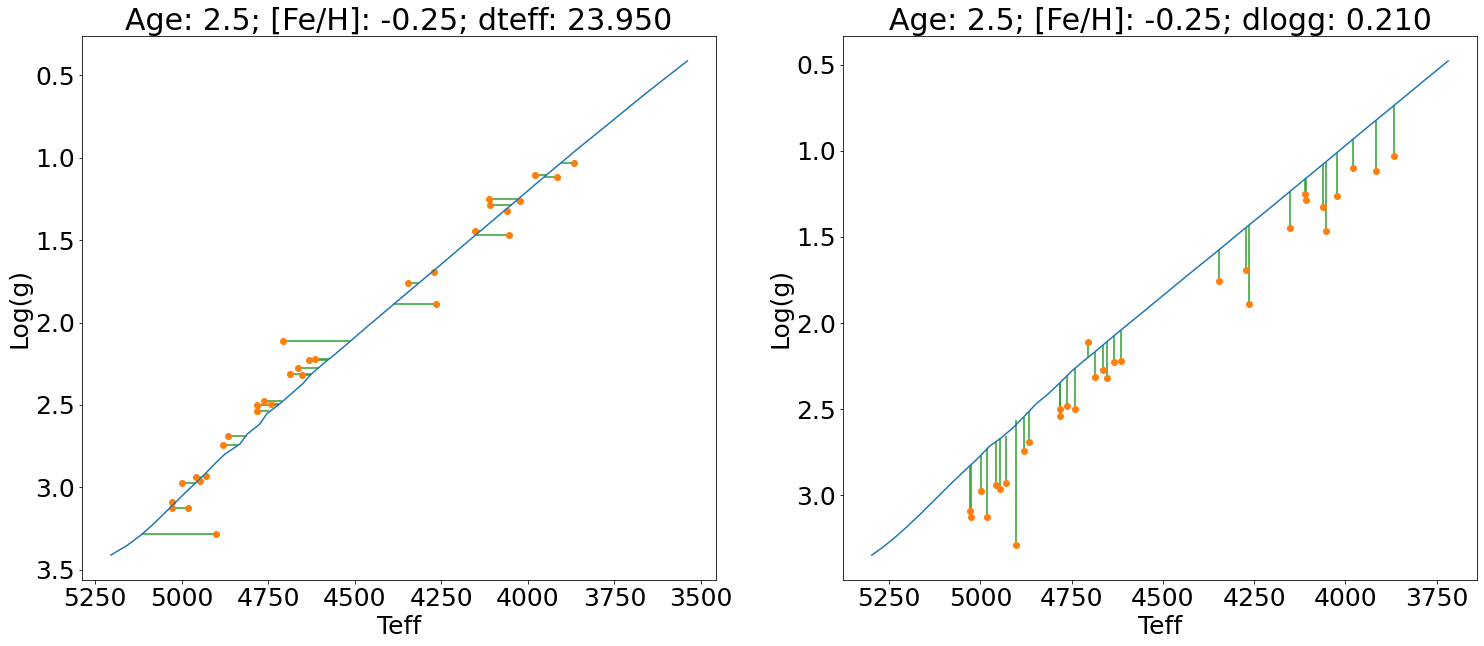

In [79]:
plt.figure(figsize=[25,10])
plt.subplot(121)
stars_select = np.where((k3dr17['IntAge']>=2.5-0.25)&(k3dr17['IntAge']<=2.5+0.25)&
                                (k3dr17['Fe/H']<=-0.25+0.05)&(k3dr17['Fe/H']>=-0.25-0.05))
        
starslogg = k3dr17['Logg'][stars_select]
starsteff = kdr17['TEFF'][stars_select]

starslogg = starslogg[np.argsort(starsteff)]
starsteff = starsteff[np.argsort(starsteff)]

salcorr = np.nanmedian(np.log10(0.655*(10**(apoafe[stars_select]))+0.345)) 

stars_iso = massive[np.where((massive['MH']==closest(massive['MH'],-0.25+salcorr))&
                             (massive['logAge']==closest(massive['logAge'],np.log10(2.5*10**9))))]
stars_iso = stars_iso[np.argsort(stars_iso['logg'])]

spl = IUS(stars_iso['logg'][::2],10**stars_iso['logTe'][::2])
spl_xs = np.linspace(min(stars_iso['logg']),max(stars_iso['logg']))

dteffs = starsteff-spl(starslogg)

plt.scatter(starsteff,starslogg,c='tab:orange')

for k in range(len(dteffs)):
    plt.hlines(y=starslogg[k],xmin=starsteff[k],xmax=starsteff[k]-dteffs[k],
                   color='tab:green',zorder=0)

plt.plot(spl(spl_xs),spl_xs,c='tab:blue')

plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

plt.title(r'Age: {}; [Fe/H]: {}; dteff: {:.3f}'.format(2.5,-0.25,np.nanmedian(dteffs)))

plt.xlabel(r'Teff')
plt.ylabel(r'Log(g)')

plt.subplot(122)
stars_select = np.where((k3dr17['IntAge']>=2.5-0.25)&(k3dr17['IntAge']<=2.5+0.25)&
                                (k3dr17['Fe/H']<=-0.25+0.05)&(k3dr17['Fe/H']>=-0.25-0.05))
        
starslogg = k3dr17['Logg'][stars_select]
starsteff = kdr17['TEFF'][stars_select]

starslogg = starslogg[np.argsort(starsteff)]
starsteff = starsteff[np.argsort(starsteff)]

salcorr = np.median(np.log10(0.655*(10**(apoafe[stars_select]))+0.345))

stars_iso = massive[np.where((massive['MH']==closest(massive['MH'],-0.25+salcorr))&
                             (massive['logAge']==closest(massive['logAge'],np.log10(2.5*10**9))))]

stars_iso = stars_iso[np.argsort(stars_iso['logTe'])]

spl = IUS(10**stars_iso['logTe'][::2],stars_iso['logg'][::2])
spl_xs = np.linspace(min(10**stars_iso['logTe']),max(10**stars_iso['logTe']))

dlogs = starslogg-spl(starsteff)

plt.scatter(starsteff,starslogg,c='tab:orange')

for k in range(len(dlogs)):
    plt.vlines(x=starsteff[k],ymin=starslogg[k],ymax=starslogg[k]-dlogs[k],color='tab:green',zorder=0)

plt.plot(spl_xs,spl(spl_xs),c='tab:blue')

plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

plt.title(r'Age: {}; [Fe/H]: {}; dlogg: {:.3f}'.format(2.5,-0.25,np.nanmedian(dlogs)))

plt.xlabel(r'Teff')
plt.ylabel(r'Log(g)')

plt.show()

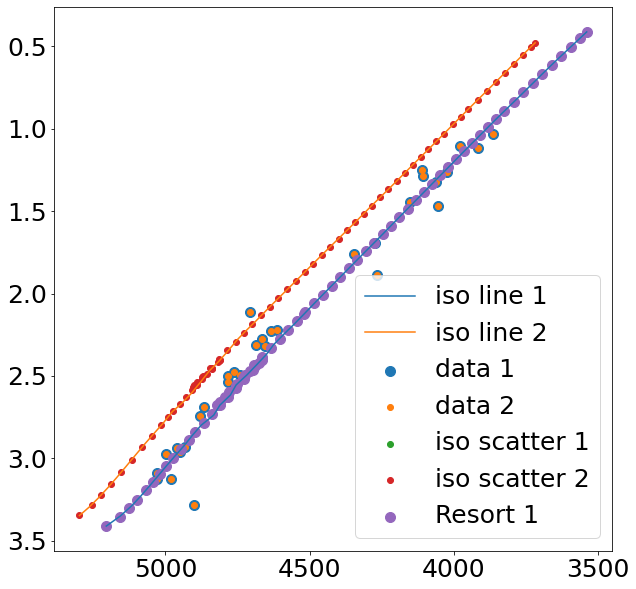

In [92]:
plt.figure(figsize=[10,10])

### dteff
stars_select1 = np.where((k3dr17['IntAge']>=2.5-0.25)&(k3dr17['IntAge']<=2.5+0.25)&
                                (k3dr17['Fe/H']<=-0.25+0.05)&(k3dr17['Fe/H']>=-0.25-0.05))

starslogg1 = k3dr17['Logg'][stars_select1]
starsteff1 = kdr17['TEFF'][stars_select1]

starslogg1 = starslogg1[np.argsort(starsteff1)]
starsteff1 = starsteff1[np.argsort(starsteff1)]

salcorr1 = np.nanmedian(np.log10(0.655*(10**(apoafe[stars_select1]))+0.345)) 

stars_iso1 = massive[np.where((massive['MH']==closest(massive['MH'],-0.25+salcorr1))&
                             (massive['logAge']==closest(massive['logAge'],np.log10(2.5*10**9))))]
stars_iso1 = stars_iso1[np.argsort(stars_iso1['logg'])]

spl1 = IUS(stars_iso1['logg'][::2],10**stars_iso1['logTe'][::2])
spl_xs1 = np.linspace(min(stars_iso1['logg']),max(stars_iso1['logg']))
dteffs = starsteff1-spl(starslogg1)

###dlogg
stars_select2 = np.where((k3dr17['IntAge']>=2.5-0.25)&(k3dr17['IntAge']<=2.5+0.25)&
                                (k3dr17['Fe/H']<=-0.25+0.05)&(k3dr17['Fe/H']>=-0.25-0.05))
        
starslogg2 = k3dr17['Logg'][stars_select2]
starsteff2 = kdr17['TEFF'][stars_select2]

starslogg2 = starslogg2[np.argsort(starsteff2)]
starsteff2 = starsteff2[np.argsort(starsteff2)]

salcorr2 = np.median(np.log10(0.655*(10**(apoafe[stars_select2]))+0.345))

stars_iso2 = massive[np.where((massive['MH']==closest(massive['MH'],-0.25+salcorr2))&
                             (massive['logAge']==closest(massive['logAge'],np.log10(2.5*10**9))))]

stars_iso2 = stars_iso2[np.argsort(stars_iso2['logTe'])]

spl2 = IUS(10**stars_iso2['logTe'][::2],stars_iso2['logg'][::2])
spl_xs2 = np.linspace(min(10**stars_iso2['logTe']),max(10**stars_iso2['logTe']))
dlogs = starslogg2-spl(starsteff2)

### Plot
plt.scatter(starsteff1,starslogg1,label='data 1',s=100)
plt.scatter(starsteff2,starslogg2,label='data 2')

plt.plot(spl1(spl_xs1),spl_xs1,label='iso line 1')
plt.plot(spl_xs2,spl2(spl_xs2),label='iso line 2')

plt.scatter(10**stars_iso1['logTe'],stars_iso1['logg'],label='iso scatter 1')
plt.scatter(10**stars_iso2['logTe'],stars_iso2['logg'],label='iso scatter 2')

plt.scatter(10**stars_iso1['logTe'][np.argsort(stars_iso1['logTe'])],
            stars_iso1['logg'][np.argsort(stars_iso1['logTe'])],s=100,label='Resort 1')

plt.legend()

plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

plt.show()

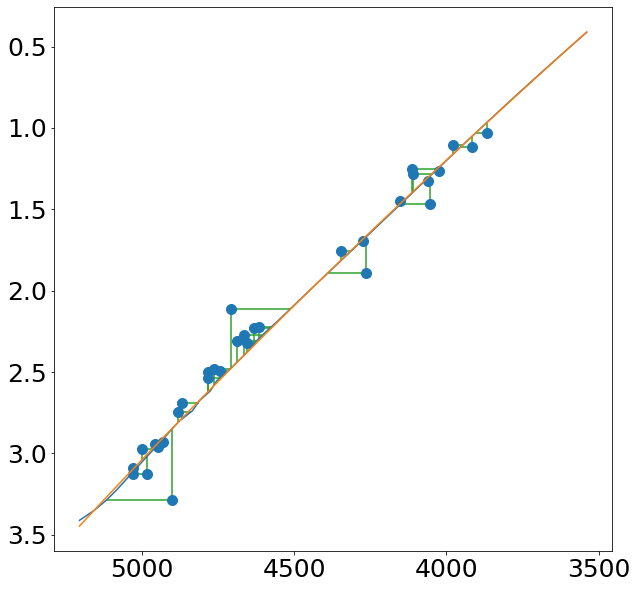

In [125]:
from scipy.interpolate import UnivariateSpline as US

plt.figure(figsize=[10,10])

### dteff
stars_select1 = np.where((k3dr17['IntAge']>=2.5-0.25)&(k3dr17['IntAge']<=2.5+0.25)&
                                (k3dr17['Fe/H']<=-0.25+0.05)&(k3dr17['Fe/H']>=-0.25-0.05))

starslogg1 = k3dr17['Logg'][stars_select1]
starsteff1 = kdr17['TEFF'][stars_select1]

starslogg1 = starslogg1[np.argsort(starsteff1)]
starsteff1 = starsteff1[np.argsort(starsteff1)]

salcorr1 = np.nanmedian(np.log10(0.655*(10**(apoafe[stars_select1]))+0.345)) 

stars_iso1 = massive[np.where((massive['MH']==closest(massive['MH'],-0.25+salcorr1))&
                             (massive['logAge']==closest(massive['logAge'],np.log10(2.5*10**9))))]
stars_iso1 = stars_iso1[np.argsort(stars_iso1['logg'])]

spl1 = US(stars_iso1['logg'][::2],10**stars_iso1['logTe'][::2],s=3)
spl_xs1 = np.linspace(min(stars_iso1['logg']),max(stars_iso1['logg']))
dteffs = starsteff1-spl1(starslogg1)

### dlogg


spl2 = US(10**stars_iso1['logTe'][::2][np.argsort(stars_iso1['logTe'][::2])],
           stars_iso1['logg'][::2][np.argsort(stars_iso1['logTe'][::2])],s=3)
spl_xs2 = np.linspace(min(10**stars_iso1['logTe']),max(10**stars_iso1['logTe']))
dloggs = starslogg1 - spl2(starsteff1)


### Plot
plt.scatter(starsteff1,starslogg1,label='data 1',s=100)


plt.plot(spl1(spl_xs1),spl_xs1,label='iso line 1')
plt.plot(spl_xs2,spl2(spl_xs2),label='iso line 2')

for k in range(len(dteffs)):
    plt.hlines(y=starslogg[k],xmin=starsteff[k],xmax=starsteff[k]-dteffs[k],
                   color='tab:green',zorder=0)

for k in range(len(dlogs)):
    plt.vlines(x=starsteff1[k],ymin=starslogg1[k],ymax=starslogg1[k]-dloggs[k],color='tab:green',zorder=0)

plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

plt.show()

dteff 23.903616528995826
dlogg -0.05147117695908476


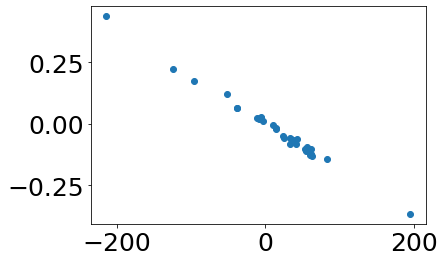

In [127]:
plt.scatter(dteffs,dloggs)
print('dteff',np.nanmedian(dteffs))
print('dlogg',np.nanmedian(dloggs))

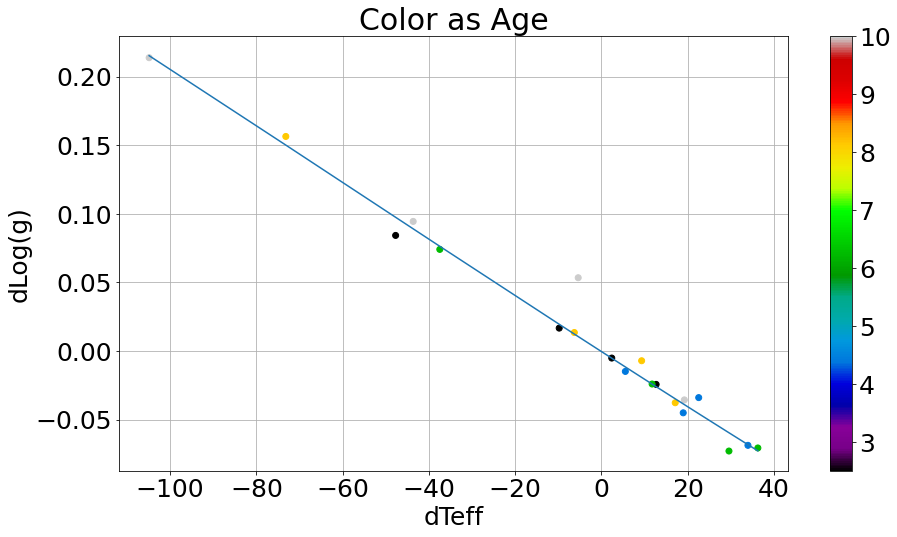

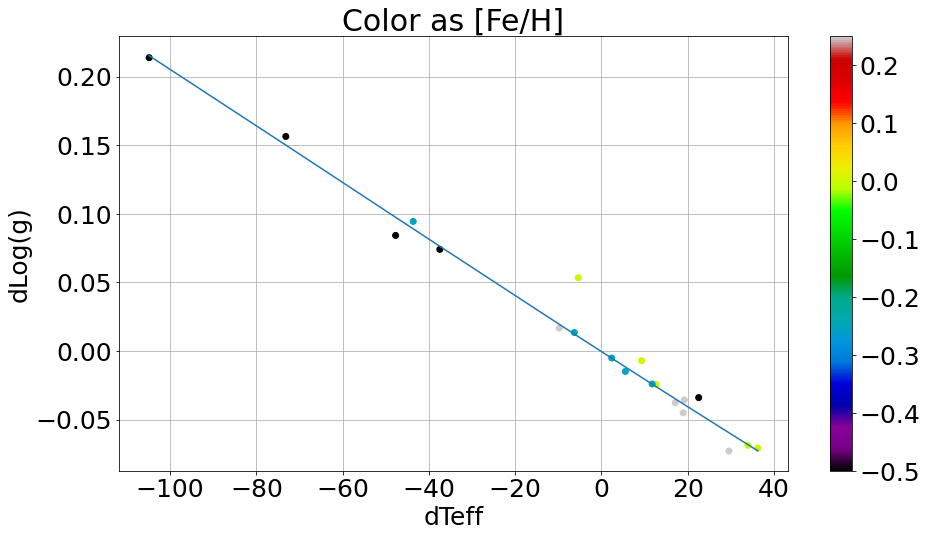

In [66]:
# shiftpoly = np.poly1d(robust.polyfit(shift['DTEFF'],shift['DLOGG'],3))

# ###
# plt.figure(figsize=[15,8])
# plt.scatter(shift['DTEFF'],shift['DLOGG'],c=shift['AGE'],cmap='nipy_spectral')
# plt.colorbar()

# plt.plot(shift['DTEFF'][np.argsort(shift['DTEFF'])],shiftpoly(shift['DTEFF'][np.argsort(shift['DTEFF'])]))

# plt.grid()
# plt.title(r'Color as Age')
# plt.xlabel(r'dTeff')
# plt.ylabel(r'dLog(g)')
# # plt.savefig('../plots/shifts_ageTEFF.png',bbox_inches='tight')
# plt.show()

# ###
# plt.figure(figsize=[15,8])
# plt.scatter(shift['DTEFF'],shift['DLOGG'],c=shift['FE_H'],cmap='nipy_spectral')
# plt.colorbar()

# plt.plot(shift['DTEFF'][np.argsort(shift['DTEFF'])],shiftpoly(shift['DTEFF'][np.argsort(shift['DTEFF'])]))

# plt.grid()
# plt.title(r'Color as [Fe/H]')
# plt.xlabel(r'dTeff')
# plt.ylabel(r'dLog(g)')
# # plt.savefig('../plots/shifts_fehTEFF.png',bbox_inches='tight')
# plt.show()

In [51]:
# fehs = np.array([0.25,0.0,-0.25,-0.5])
# ages = np.array([10,8.125,6.25,4.375,2.5])

# dlogg_arr = np.zeros((4,5))

# fig, ax = plt.subplots(4,5,figsize=[60,50])
# for i in range(4):
#     for j in range(5):
        
#         stars_select = np.where((k3dr17['IntAge']>=ages[j]-0.25)&(k3dr17['IntAge']<=ages[j]+0.25)&
#                                 (k3dr17['Fe/H']<=fehs[i]+0.05)&(k3dr17['Fe/H']>=fehs[i]-0.05))
        
#         starslogg = k3dr17['Logg'][stars_select]
#         starsteff = kdr17['TEFF'][stars_select]
        
#         salcorr = 0 #np.median(np.log10(0.655*(10**(apoafe[stars_select]))+0.345))
        
#         stars = stars[np.argsort(stars['Teff'])]
        
#         stars_iso = massive[np.where((massive['MH']==closest(massive['MH'],fehs[i]+salcorr))&
#                                      (massive['logAge']==closest(massive['logAge'],np.log10(ages[j]*10**9))))]
        
#         stars_iso = stars_iso[np.argsort(stars_iso['logTe'])]
        
#         spl = IUS(10**stars_iso['logTe'][::2],stars_iso['logg'][::2])
#         spl_xs = np.linspace(min(10**stars_iso['logTe']),max(10**stars_iso['logTe']))
        
#         dlog = np.median(stars['Logg']-spl(stars['Teff']))
#         dlogg_arr[i,j] = dlog
        
#         ax[i,j].scatter(starsteff,starslogg,c='tab:orange',label='APOKASC')
        
#         ax[i,j].plot(spl_xs,spl(spl_xs),c='tab:blue',label='Isochrone')
        
#         ax[i,j].legend()
        
#         ax[i,j].invert_xaxis()
#         ax[i,j].invert_yaxis()
        
#         ax[i,j].set_title(r'Age: {}; [Fe/H]: {}; dlog(g): {:.3f}'.format(ages[j],fehs[i],dlog))
        
#         ax[i,j].set_xlabel(r'Teff')
#         ax[i,j].set_ylabel(r'Log(g)')
        
# plt.suptitle(r'Without Salaris Correction',y=0.91)
# plt.savefig('../plots/isochrone_compare_dloggTEFF.pdf',dpi=300,bbox_inches='tight')
# plt.show()

In [50]:
# fehs = np.array([0.25,0.0,-0.25,-0.5])
# ages = np.array([10,8.125,6.25,4.375,2.5])

# dlogg_arr_salaris = np.zeros((4,5))

# fig, ax = plt.subplots(4,5,figsize=[60,50])
# for i in range(4):
#     for j in range(5):
        
#         stars_select = np.where((k3dr17['IntAge']>=ages[j]-0.25)&(k3dr17['IntAge']<=ages[j]+0.25)&
#                                 (k3dr17['Fe/H']<=fehs[i]+0.05)&(k3dr17['Fe/H']>=fehs[i]-0.05))
        
#         starslogg = k3dr17['Logg'][stars_select]
#         starsteff = kdr17['TEFF'][stars_select]
        
#         salcorr = np.median(np.log10(0.655*(10**(apoafe[stars_select]))+0.345))
        
#         stars = stars[np.argsort(stars['Teff'])]
        
#         stars_iso = massive[np.where((massive['MH']==closest(massive['MH'],fehs[i]+salcorr))&
#                                      (massive['logAge']==closest(massive['logAge'],np.log10(ages[j]*10**9))))]
        
#         stars_iso = stars_iso[np.argsort(stars_iso['logTe'])]
        
#         spl = IUS(10**stars_iso['logTe'][::2],stars_iso['logg'][::2])
#         spl_xs = np.linspace(min(10**stars_iso['logTe']),max(10**stars_iso['logTe']))
        
#         dlog = np.median(stars['Logg']-spl(stars['Teff']))
#         dlogg_arr_salaris[i,j] = dlog 
        
#         ax[i,j].scatter(starsteff,starslogg,c='tab:orange',label='APOKASC')
        
#         ax[i,j].plot(spl_xs,spl(spl_xs),c='tab:blue',label='Isochrone')
        
#         ax[i,j].legend()
        
#         ax[i,j].invert_xaxis()
#         ax[i,j].invert_yaxis()
        
#         ax[i,j].set_title(r'Age: {}; [Fe/H]: {}; dlog: {:.3f}'.format(ages[j],fehs[i],dlog))
        
#         ax[i,j].set_xlabel(r'Teff')
#         ax[i,j].set_ylabel(r'Log(g)')
        
# plt.suptitle(r'With Salaris Correction',y=0.91)
# plt.savefig('../plots/isochrone_compare_dlogg_salarisTEFF.pdf',dpi=300,bbox_inches='tight')
# plt.show()

In [56]:
# fehs = np.array([0.25,0.0,-0.25,-0.5])
# ages = np.array([10,8.125,6.25,4.375,2.5])

# feh_arr = np.zeros((4,5))
# ages_arr = np.zeros((4,5))

# dteff_arr = np.zeros((4,5))

# fig, ax = plt.subplots(4,5,figsize=[60,50])
# for i in range(4):
#     for j in range(5):
        
#         stars_select = np.where((k3dr17['IntAge']>=ages[j]-0.25)&(k3dr17['IntAge']<=ages[j]+0.25)&
#                                 (k3dr17['Fe/H']<=fehs[i]+0.05)&(k3dr17['Fe/H']>=fehs[i]-0.05))
        
#         starslogg = k3dr17['Logg'][stars_select]
#         starsteff = kdr17['TEFF'][stars_select]
        
#         salcorr = 0 #np.median(np.log10(0.655*(10**(apoafe[stars_select]))+0.345))
        
#         stars = stars[np.argsort(stars['Teff'])]
        
#         stars_iso = massive[np.where((massive['MH']==closest(massive['MH'],fehs[i]+salcorr))&
#                                      (massive['logAge']==closest(massive['logAge'],np.log10(ages[j]*10**9))))]
        
#         stars_iso = stars_iso[np.argsort(stars_iso['logTe'])]
        
#         spl = IUS(stars_iso['logg'][::2][np.argsort(stars_iso['logg'][::2])],
#                   10**stars_iso['logTe'][::2][np.argsort(stars_iso['logg'][::2])])
        
#         spl_xs = np.linspace(min(stars_iso['logg']),max(stars_iso['logg']))
        
#         dteff = np.median(stars['Teff']-spl(stars['Logg']))
#         dteff_arr[i,j] = dteff
        
#         feh_arr[i,j] = fehs[i]
#         ages_arr[i,j] = ages[j]
        
#         ax[i,j].scatter(starsteff,starslogg,c='tab:orange',label='APOKASC')
        
#         ax[i,j].plot(spl(spl_xs),spl_xs,c='tab:blue',label='Isochrone')
        
#         ax[i,j].legend()
        
#         ax[i,j].invert_xaxis()
#         ax[i,j].invert_yaxis()
        
#         ax[i,j].set_title(r'Age: {}; [Fe/H]: {}; dteff: {:.3f}'.format(ages[j],fehs[i],dteff))
        
#         ax[i,j].set_xlabel(r'Teff')
#         ax[i,j].set_ylabel(r'Log(g)')
        
# plt.suptitle(r'Without Salaris Correction',y=0.91)
# plt.savefig('../plots/isochrone_compare_dteffTEFF.pdf',dpi=300,bbox_inches='tight')
# plt.show()

In [64]:
# fehs = np.array([0.25,0.0,-0.25,-0.5])
# ages = np.array([10,8.125,6.25,4.375,2.5])

# feh_arr = np.zeros((4,5))
# ages_arr = np.zeros((4,5))

# alpha_arr = np.zeros((4,5))
# sal_arr = np.zeros((4,5))

# dteff_arr_salaris = np.zeros((4,5))

# fig, ax = plt.subplots(4,5,figsize=[60,50])
# for i in range(4):
#     for j in range(5):
        
#         stars_select = np.where((k3dr17['IntAge']>=ages[j]-0.25)&(k3dr17['IntAge']<=ages[j]+0.25)&
#                                 (k3dr17['Fe/H']<=fehs[i]+0.05)&(k3dr17['Fe/H']>=fehs[i]-0.05))
        
#         starslogg = k3dr17['Logg'][stars_select]
#         starsteff = kdr17['TEFF'][stars_select]
        
#         salcorr = np.nanmedian(np.log10(0.655*(10**(apoafe[stars_select]))+0.345))
#         alpha_arr[i,j] = np.nanmedian(apoafe[stars_select])
#         sal_arr[i,j] = fehs[i]+salcorr
        
#         stars = stars[np.argsort(stars['Teff'])]
        
#         stars_iso = massive[np.where((massive['MH']==closest(massive['MH'],fehs[i]+salcorr))&
#                                      (massive['logAge']==closest(massive['logAge'],np.log10(ages[j]*10**9))))]
        
#         stars_iso = stars_iso[np.argsort(stars_iso['logTe'])]
        
#         spl = IUS(stars_iso['logg'][::3][np.argsort(stars_iso['logg'][::3])],
#                   10**stars_iso['logTe'][::3][np.argsort(stars_iso['logg'][::3])])
        
#         spl_xs = np.linspace(min(stars_iso['logg']),max(stars_iso['logg']))
        
#         dteff = np.median(stars['Teff']-spl(stars['Logg']))
#         dteff_arr_salaris[i,j] = dteff
        
#         feh_arr[i,j] = fehs[i]
#         ages_arr[i,j] = ages[j]
        
#         ax[i,j].scatter(starsteff,starslogg,c='tab:orange',label='APOKASC')
        
#         ax[i,j].plot(spl(spl_xs),spl_xs,c='tab:blue',label='Isochrone')
        
#         ax[i,j].legend()
        
#         ax[i,j].invert_xaxis()
#         ax[i,j].invert_yaxis()
        
#         ax[i,j].set_title(r'Age: {}; [Fe/H]: {}; dteff: {:.3f}'.format(ages[j],fehs[i],dteff))
        
#         ax[i,j].set_xlabel(r'Teff')
#         ax[i,j].set_ylabel(r'Log(g)')
        
# plt.suptitle(r'With Salaris Correction',y=0.91)
# plt.savefig('../plots/isochrone_compare_dteff_salarisTEFF.pdf',dpi=300,bbox_inches='tight')
# plt.show()

In [351]:
dr16 = fits.getdata('/Users/joshuapovick/Desktop/Research/fits/allStarLite-r12-l33.fits.gz')

_, dr16_ind, k_ind = np.intersect1d(dr16['APOGEE_ID'],kdr17['APOGEE_ID'],return_indices=True)

kdr16 = dr16[dr16_ind]

In [354]:
np.where((kdr17['APOGEE_ID']==kdr16['APOGEE_ID'])==False)

(array([], dtype=int64),)

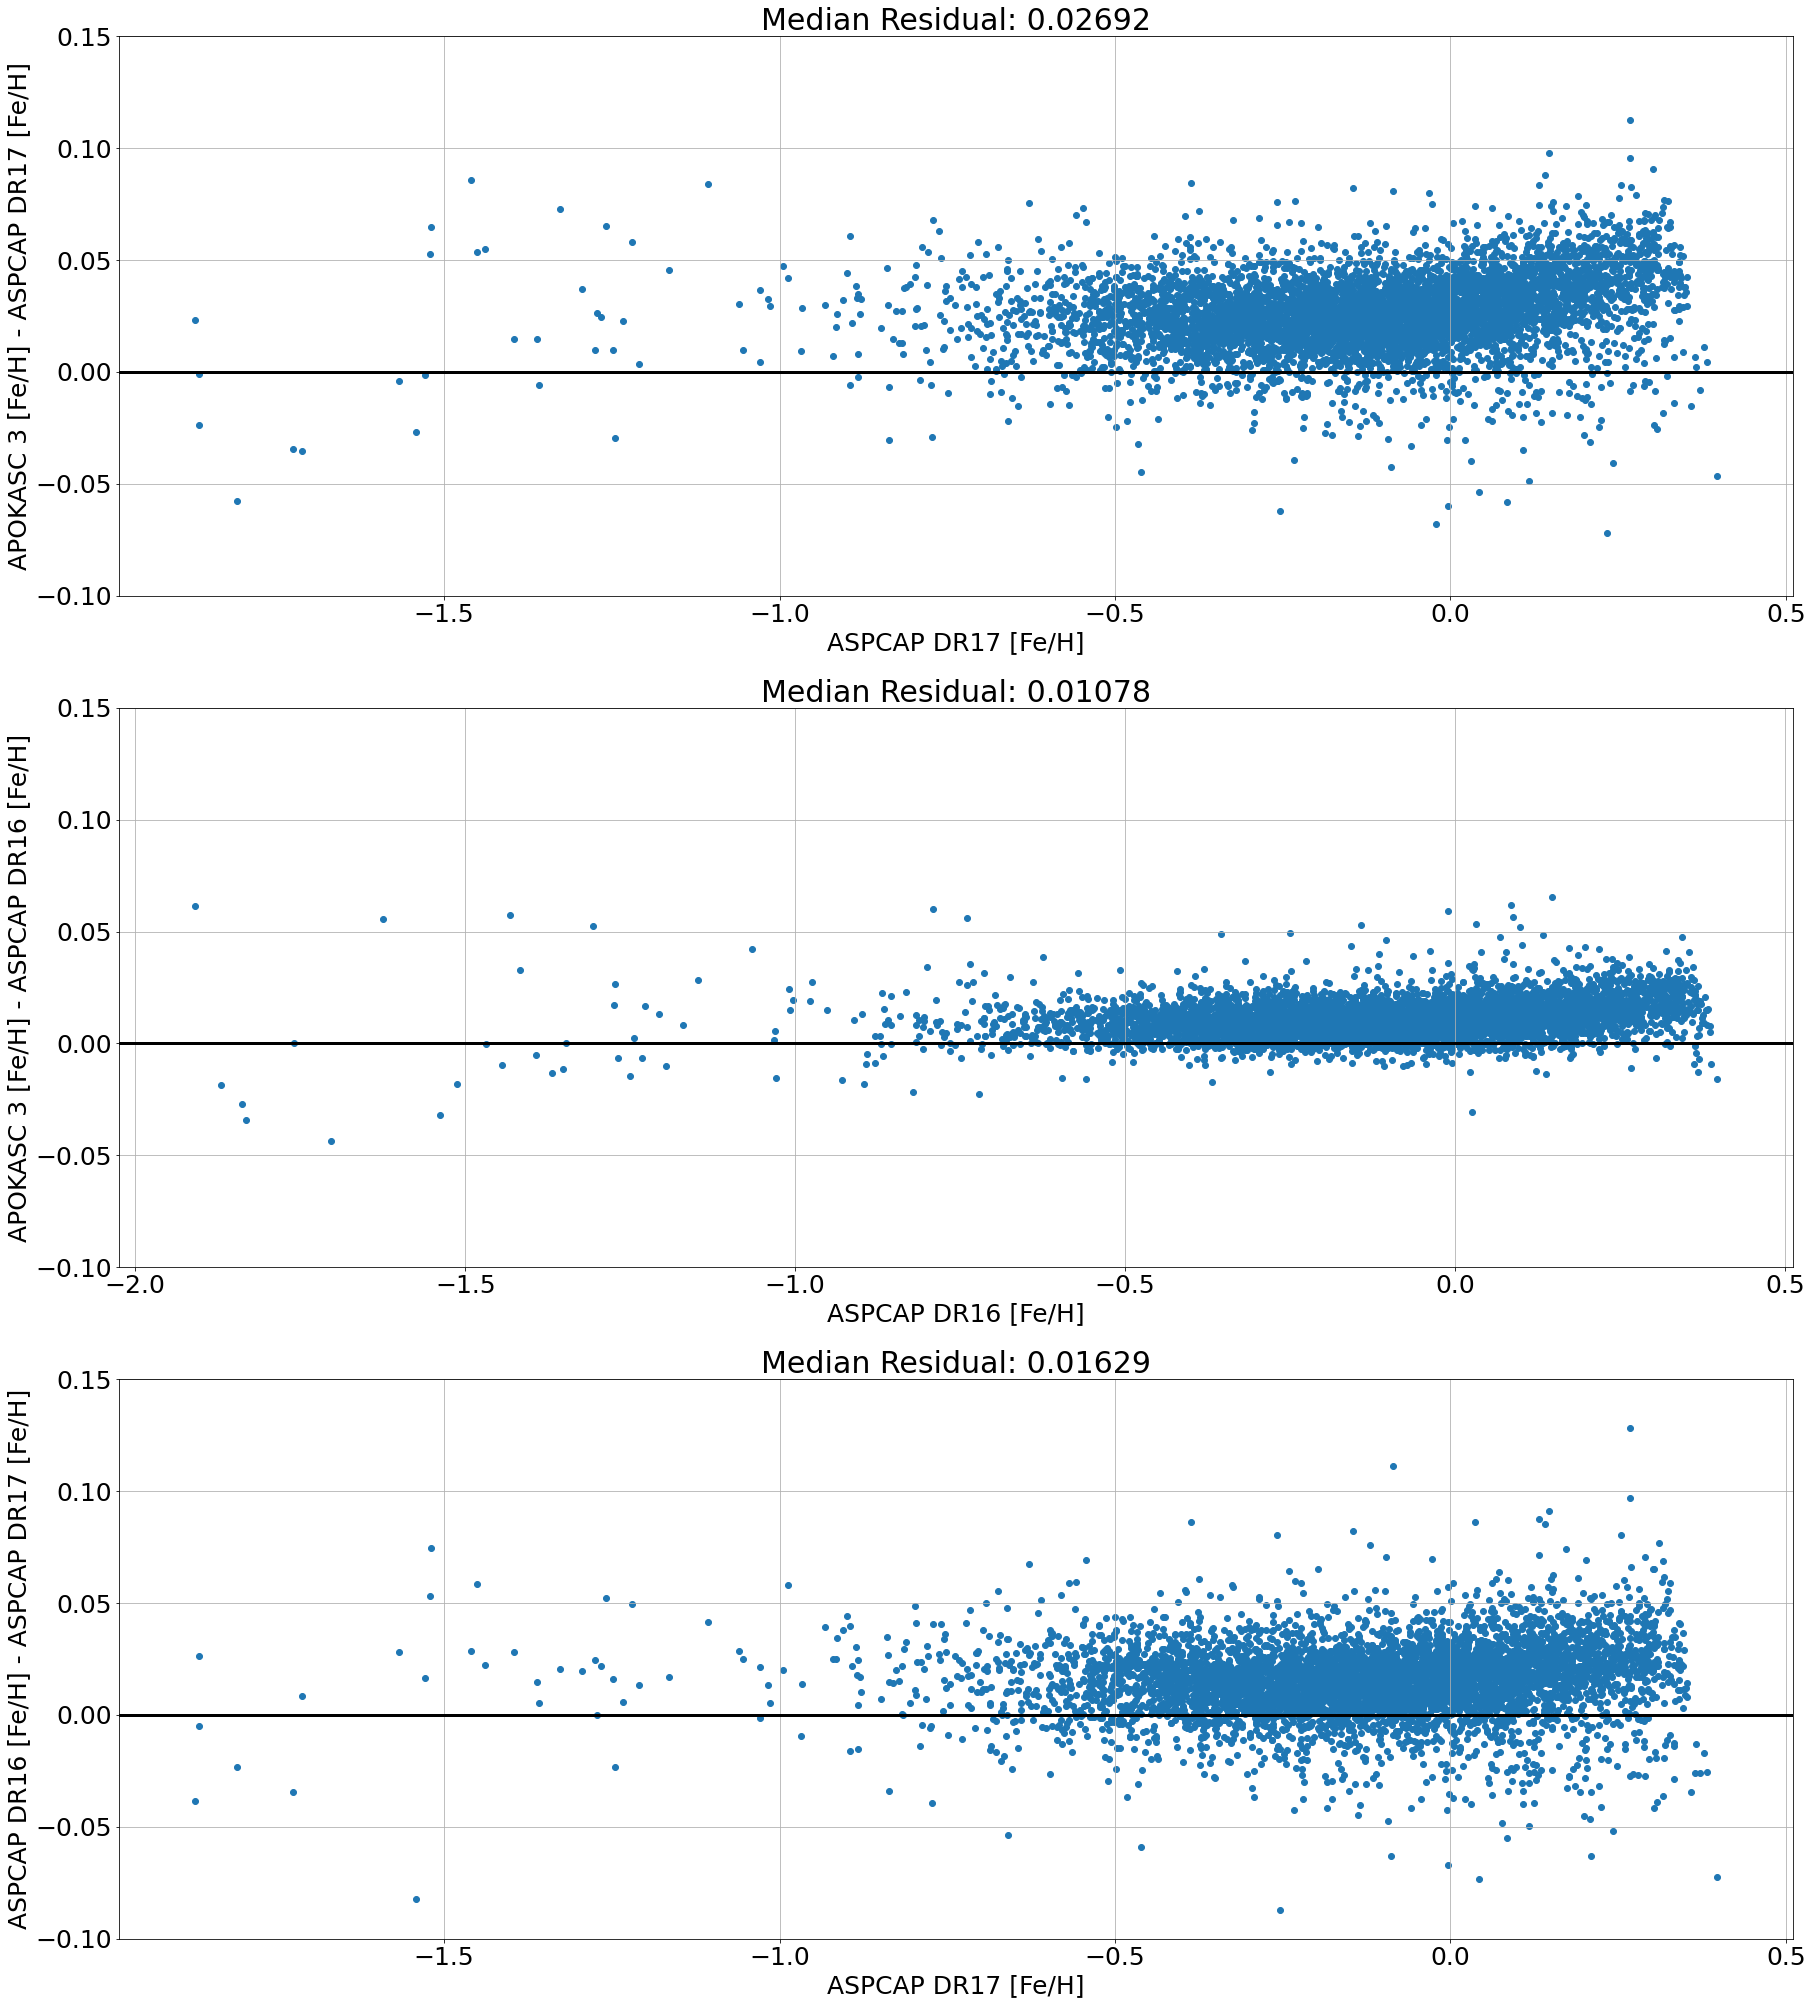

In [374]:
plt.figure(figsize=[30,35])

###
plt.subplot(311)
plt.scatter(kdr17['FE_H'],k3dr17['Fe/H']-kdr17['FE_H'])

plt.axhline(0.0,c='k',lw=3.0)

plt.title(r'Median Residual: {:.5f}'.format(np.nanmedian(k3dr17['Fe/H']-kdr17['FE_H'])))
plt.xlabel(r'ASPCAP DR17 [Fe/H]')
plt.ylabel(r'APOKASC 3 [Fe/H] - ASPCAP DR17 [Fe/H]')

plt.ylim(-0.1,0.15)
plt.grid()

###
plt.subplot(312)
plt.scatter(kdr16['FE_H'],k3dr17['Fe/H']-kdr16['FE_H'])

plt.axhline(0.0,c='k',lw=3.0)

plt.title(r'Median Residual: {:.5f}'.format(np.nanmedian(k3dr17['Fe/H']-kdr16['FE_H'])))
plt.xlabel(r'ASPCAP DR16 [Fe/H]')
plt.ylabel(r'APOKASC 3 [Fe/H] - ASPCAP DR16 [Fe/H]')

plt.ylim(-0.1,0.15)
plt.grid()

###
plt.subplot(313)
plt.scatter(kdr17['FE_H'],kdr16['FE_H']-kdr17['FE_H'])

plt.axhline(0.0,c='k',lw=3.0)

plt.title(r'Median Residual: {:.5f}'.format(np.nanmedian(kdr16['FE_H']-kdr17['FE_H'])))
plt.xlabel(r'ASPCAP DR17 [Fe/H]')
plt.ylabel(r'ASPCAP DR16 [Fe/H] - ASPCAP DR17 [Fe/H]')

plt.ylim(-0.1,0.15)
plt.grid()

plt.savefig('../plots/feh_resids.pdf',dpi=300,bbox_inches='tight')
plt.show()

# ###
# plt.subplot(414)
# plt.scatter(kdr16['FE_H'],kdr17['FE_H']-kdr16['FE_H'])

# plt.axhline(0.0,c='k',lw=3.0)

# plt.title(r'{:.5f}'.format(np.nanmedian(kdr16['FE_H']-kdr17['FE_H'])))
# plt.xlabel(r'ASPCAP DR16 [Fe/H]')
# plt.ylabel(r'ASPCAP DR16 [Fe/H] - ASPCAP DR17 [Fe/H]')

# plt.grid()
# plt.ylim(bottom=-0.1)

# Absolute Magnitude

In [271]:
massive.columns

<TableColumns names=('index','MH','Mass','logAge','logTe','logg','Gmag','G_BPmag','G_RPmag','Jmag','Hmag','Ksmag')>

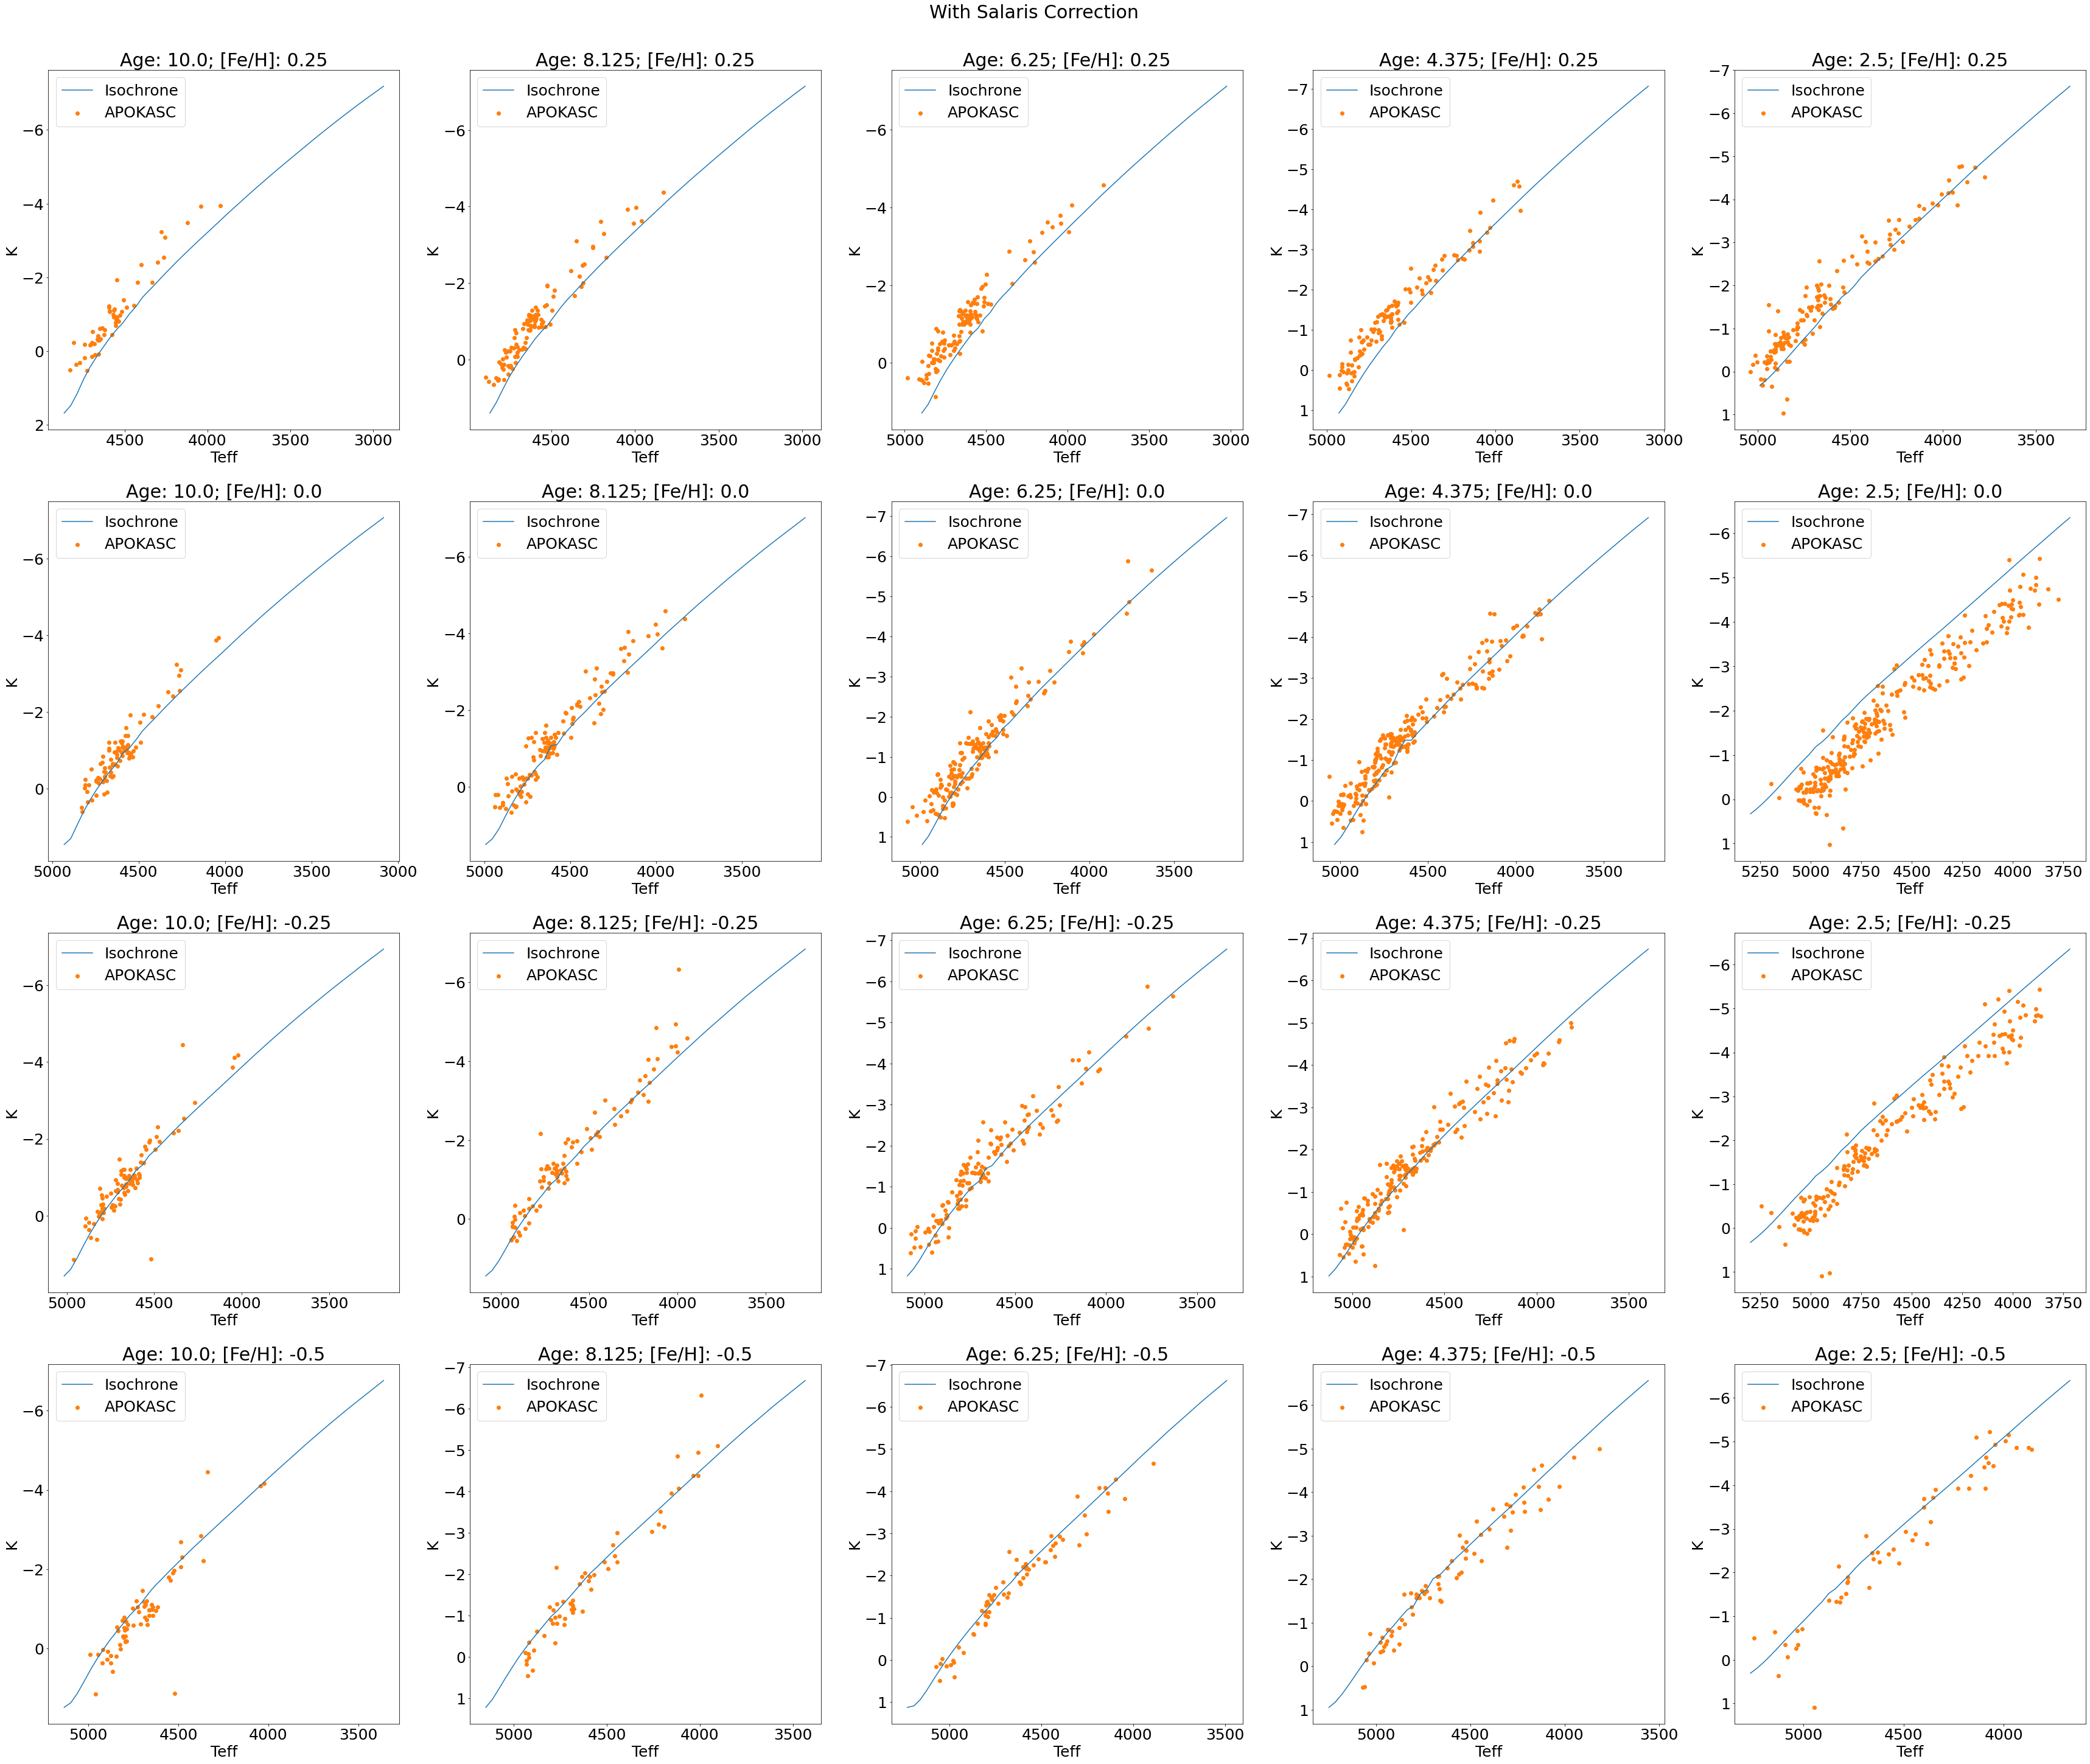

In [281]:
fehs = np.array([0.25,0.0,-0.25,-0.5])
ages = np.array([10,8.125,6.25,4.375,2.5])

mse_arr_absmag = np.zeros((4,5))

fig, ax = plt.subplots(4,5,figsize=[60,50])
for i in range(4):
    for j in range(5):
        
        stars_select = np.where((k3dr17['IntAge']>=ages[j]-0.25)&(k3dr17['IntAge']<=ages[j]+0.25)&
                                (k3dr17['Fe/H']<=fehs[i]+0.25)&(k3dr17['Fe/H']>=fehs[i]-0.25))
        
        stars = k3dr17[stars_select]
        
        stars17 = kdr17[stars_select]
        
        salcorr = np.median(np.log10(0.655*(10**(apoafe[stars_select]))+0.345))
        
        slgte = np.argsort(stars['Teff'])
        stars = stars[slgte]
        stars17 = stars17[slgte]
        
        dmod = 5.*np.log10(1/stars17['GAIAEDR3_PARALLAX']*1000)-5.
        
        stars_iso = massive[np.where((massive['MH']==closest(massive['MH'],fehs[i]+salcorr))&
                                     (massive['logAge']==closest(massive['logAge'],np.log10(ages[j]*10**9))))]
        
        stars_iso = stars_iso[np.argsort(stars_iso['logTe'])]
        
        spl = IUS(10**stars_iso['logTe'][::2],stars_iso['Ksmag'][::2])
        spl_xs = np.linspace(min(10**stars_iso['logTe']),max(10**stars_iso['logTe']))
        
        mse = np.sum(np.square(stars17['K']-spl(stars['Teff'])))/len(stars)
        mse_arr_absmag[i,j] = mse
        
        ax[i,j].scatter(stars['Teff'],stars17['K']-dmod,c='tab:orange',label='APOKASC')
        
        ax[i,j].plot(spl_xs,spl(spl_xs),c='tab:blue',label='Isochrone')
        
        ax[i,j].legend()
        
        ax[i,j].invert_xaxis()
        ax[i,j].invert_yaxis()
        
        ax[i,j].set_title(r'Age: {}; [Fe/H]: {}'.format(ages[j],fehs[i],mse))
        
        ax[i,j].set_xlabel(r'Teff')
        ax[i,j].set_ylabel(r'K')
        
plt.suptitle(r'With Salaris Correction',y=0.91)
plt.savefig('../plots/iso_comp_absmag_salaris.pdf',dpi=300,bbox_inches='tight')
plt.show()

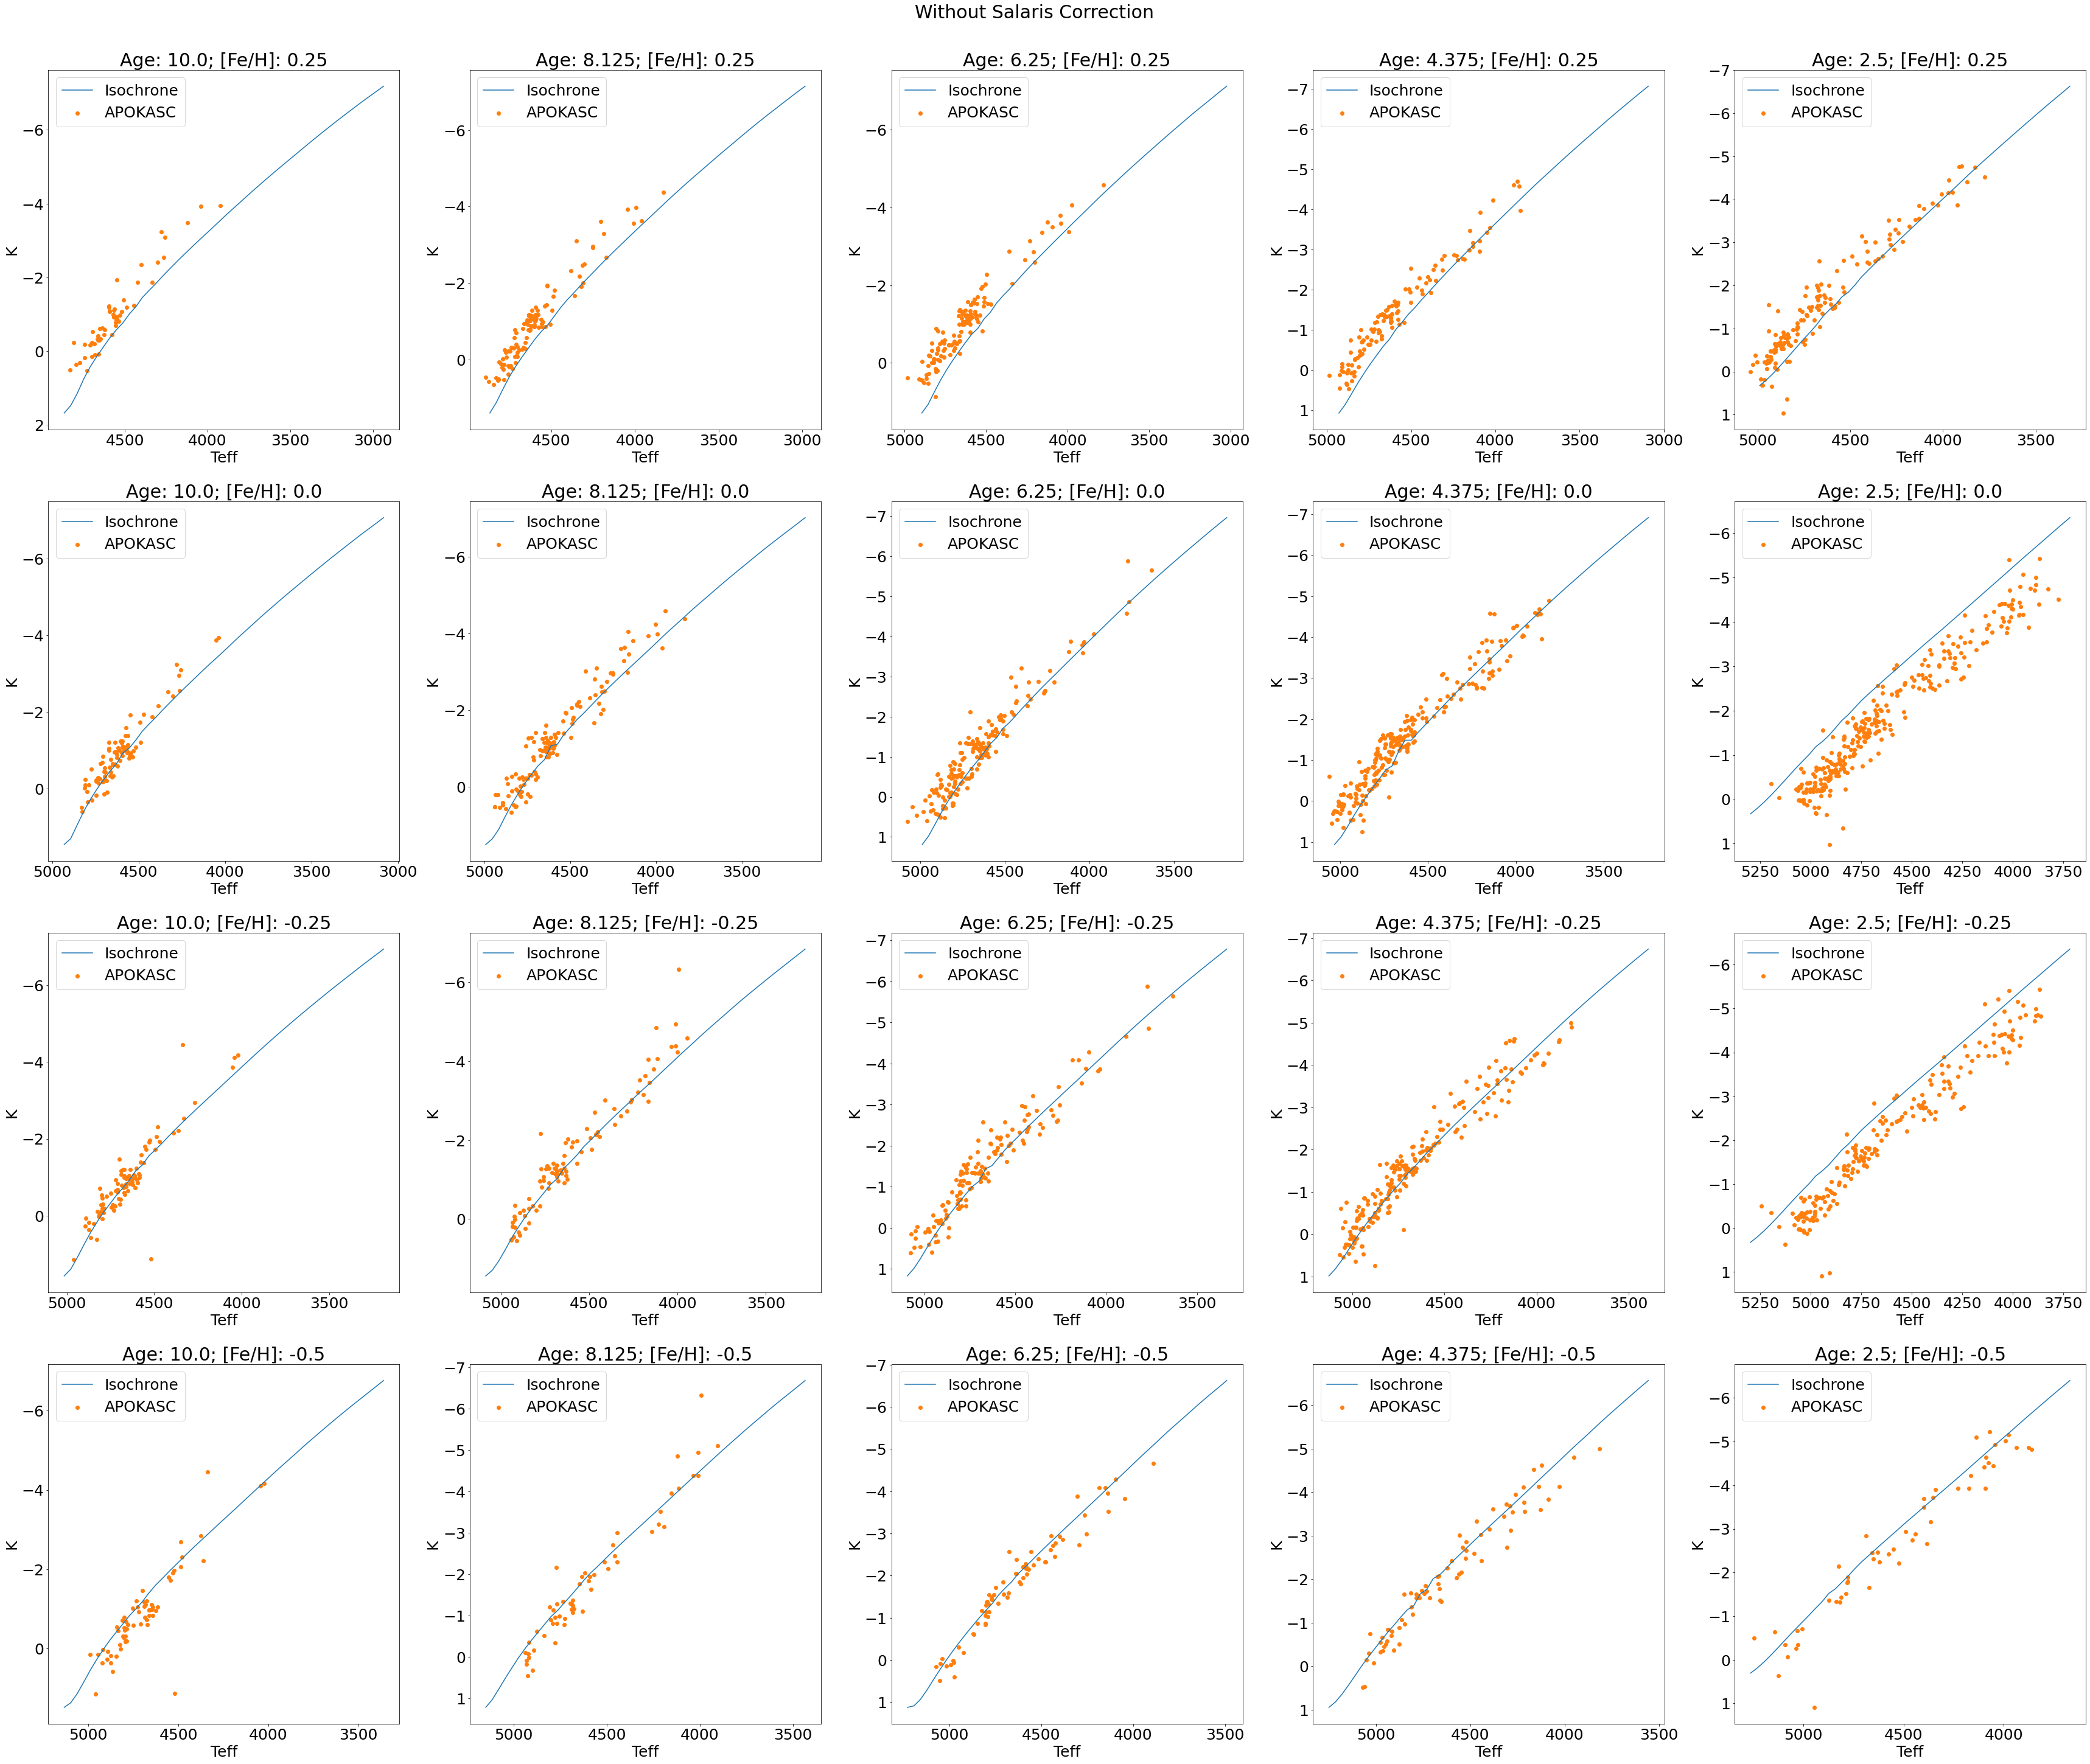

In [280]:
fehs = np.array([0.25,0.0,-0.25,-0.5])
ages = np.array([10,8.125,6.25,4.375,2.5])

fig, ax = plt.subplots(4,5,figsize=[60,50])
for i in range(4):
    for j in range(5):
        
        stars_select = np.where((k3dr17['IntAge']>=ages[j]-0.25)&(k3dr17['IntAge']<=ages[j]+0.25)&
                                (k3dr17['Fe/H']<=fehs[i]+0.25)&(k3dr17['Fe/H']>=fehs[i]-0.25))
        
        stars = k3dr17[stars_select]
        
        stars17 = kdr17[stars_select]
        
        salcorr = np.median(np.log10(0.655*(10**(apoafe[stars_select]))+0.345))
        
        slgte = np.argsort(stars['Teff'])
        stars = stars[slgte]
        stars17 = stars17[slgte]
        
        dmod = 5.*np.log10(1/stars17['GAIAEDR3_PARALLAX']*1000)-5.
        
        stars_iso = massive[np.where((massive['MH']==closest(massive['MH'],fehs[i]+salcorr))&
                                     (massive['logAge']==closest(massive['logAge'],np.log10(ages[j]*10**9))))]
        
        stars_iso = stars_iso[np.argsort(stars_iso['logTe'])]
        
        spl = IUS(10**stars_iso['logTe'][::2],stars_iso['Ksmag'][::2])
        spl_xs = np.linspace(min(10**stars_iso['logTe']),max(10**stars_iso['logTe']))
        
        mse = np.sum(np.square(stars17['K']-spl(stars['Teff'])))/len(stars)
        
        ax[i,j].scatter(stars['Teff'],stars17['K']-dmod,c='tab:orange',label='APOKASC')
        
        ax[i,j].plot(spl_xs,spl(spl_xs),c='tab:blue',label='Isochrone')
        
        ax[i,j].legend()
        
        ax[i,j].invert_xaxis()
        ax[i,j].invert_yaxis()
        
        ax[i,j].set_title(r'Age: {}; [Fe/H]: {}'.format(ages[j],fehs[i],mse))
        
        ax[i,j].set_xlabel(r'Teff')
        ax[i,j].set_ylabel(r'K')
        
plt.suptitle(r'Without Salaris Correction',y=0.91)
plt.savefig('../plots/iso_comp_absmag.pdf',dpi=300,bbox_inches='tight')
plt.show()

In [266]:
# plt.figure(figsize=[12,10])
# for i in range(4):
#     for j in range(5):
#         pl = plt.scatter(ages[j],fehs[i],c=mse_arr[i,j]/np.min(mse_arr),vmin=np.min(mse_arr)/np.min(mse_arr),
#                          vmax=np.max(mse_arr)/np.min(mse_arr),s=450,
#                          cmap='nipy_spectral')
# plt.colorbar(pl)
        
# plt.title(r'Color as MSE')
# plt.xlabel(r'Age (Gyr)')
# plt.ylabel(r'[Fe/H]')
# plt.savefig('../plots/MSE_isochrone_compare.pdf',dpi=300,bbox_inches='tight')
# plt.show()

In [253]:
# fehs = np.array([0.25,0.0,-0.25,-0.5])
# ages = np.array([10,8.125,6.25,4.375,2.5])

# mse_arr_salaris = np.zeros((4,5))

# fig, ax = plt.subplots(4,5,figsize=[60,50])
# for i in range(4):
#     for j in range(5):
        
#         stars_select = np.where((k3dr17['IntAge']>=ages[j]-0.25)&(k3dr17['IntAge']<=ages[j]+0.25)&
#                                 (k3dr17['Fe/H']<=fehs[i]+0.25)&(k3dr17['Fe/H']>=fehs[i]-0.25))
        
#         stars = k3dr17[stars_select]
        
#         med_alpha = np.median(np.log10(0.655*(10**(apoafe[stars_select]))+0.345))
        
#         stars_iso = massive[np.where((massive['MH']==closest(massive['MH'],fehs[i]+med_alpha))&
#                                      (massive['logAge']==closest(massive['logAge'],np.log10(ages[j]*10**9))))]
        
#         stars_iso = stars_iso[np.argsort(stars_iso['logTe'])]
        
#         line = np.poly1d(robust.polyfit(stars['Teff'],stars['Logg'],1))
#         line_xs = np.linspace(min(10**stars_iso['logTe']),max(10**stars_iso['logTe']))
        
#         mse = np.sum(np.square(stars_iso['logg']-line(10**stars_iso['logTe'])))/len(stars_iso)
#         mse_arr_salaris[i,j] = mse
        
#         ax[i,j].scatter(stars['Teff'],stars['Logg'],c='tab:orange',label='APOKASC')
#         ax[i,j].plot(10**stars_iso['logTe'],stars_iso['logg'],c='tab:blue',label='Isochrone')
        
#         ax[i,j].plot(line_xs,line(line_xs),c='tab:green',label='Best Fit')
        
#         ax[i,j].legend()
        
#         ax[i,j].invert_xaxis()
#         ax[i,j].invert_yaxis()
        
#         ax[i,j].set_title(r'Age: {}; [Fe/H]: {}; MSE: {:.5f}'.format(ages[j],fehs[i],mse))
        
#         ax[i,j].set_xlabel(r'Teff')
#         ax[i,j].set_ylabel(r'Log(g)')

# plt.suptitle(r'With Salaris Correction')
# plt.savefig('../plots/isochrone_compare_salaris.pdf',dpi=300,bbox_inches='tight')
# plt.show()

In [254]:
# plt.figure(figsize=[12,10])
# for i in range(4):
#     for j in range(5):
#         pl = plt.scatter(ages[j],fehs[i],c=mse_arr_salaris[i,j],
#                          vmin=np.min(mse_arr_salaris),vmax=np.max(mse_arr_salaris),s=450,
#                          cmap='nipy_spectral')
# plt.colorbar(pl)
        
# plt.title(r'Color as MSE')
# plt.xlabel(r'Age (Gyr)')
# plt.ylabel(r'[Fe/H]')
# plt.savefig('../plots/MSE_isochrone_compare_salaris.pdf',dpi=300,bbox_inches='tight')
# plt.show()

In [255]:
# plt.figure(figsize=[12,10])
# for i in range(4):
#     for j in range(5):
#         pl = plt.scatter(ages[j],fehs[i],c=mse_arr[i,j]-mse_arr_salaris[i,j],
#                          vmin=np.min(mse_arr-mse_arr_salaris),vmax=np.max(mse_arr-mse_arr_salaris),s=450,
#                          cmap='nipy_spectral')
# plt.colorbar(pl)
        
# plt.title(r'Color as MSE')
# plt.xlabel(r'Age (Gyr)')
# plt.ylabel(r'[Fe/H]')
# plt.savefig('../plots/MSE_isochrone_compare_difference.pdf',dpi=300,bbox_inches='tight')
# plt.show()